*This is further EDA and Database Creation from Jaime. Needed to get final databases for further work*

In [1]:
import pandas as pd
import seaborn as sns
import re
import peptides
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import os
import glob
from scipy import stats
import biotite.sequence.graphics as graphics
import biotite.sequence.align as align
import biotite.sequence as seq
from dna_features_viewer import GraphicFeature, GraphicRecord
from collections import Counter
import numpy as np
import pickle 
from statannot import add_stat_annotation

In [2]:
strict = pd.read_csv('austin_db/final_brain_df.csv')

# do I need these data frames?
csfdf = pd.read_csv('jaime_db/csfdf.csv')
ptmclean = pd.read_csv('jaime_db/ptmclean.csv')
proteindomains = pd.read_csv('austin_db/proteindomains.csv')
proteinsummaries = pd.read_csv('austin_db/proteinsummaries.csv')
swisspalm = pd.read_csv('jaime_db/palmprot_by_organism_all_uniq_sites_1.txt',names=['Protein','Site_Position'], skiprows=4,sep='\t')
peptideprobabilities = pd.read_csv('jaime_db/peptides_Predictions.txt',sep='\t')
coveragedf = pd.read_csv('austin_db/coverage.csv')  
theocoverage = pd.read_csv('austin_db/theocoverage.csv') 
theoriticaldf = pd.read_csv('jaime_db/theoreticalscript.csv')

ectodomain = pd.read_csv('jaime_db/ectodomains.txt',sep='\t',names=['Protein','Ectodomain_Sheddin'])
cleavage = pd.read_csv('jaime_db/cleavage.txt',sep='\t')
cleavage = cleavage[cleavage['cleav_prob']>0.75]
cleavage['position'] = cleavage['position']-1

transitiondf = pd.read_csv('austin_db/transitionsdf.csv')

In [3]:
coveragedf.Classification.value_counts()
coveragedf[coveragedf['Protein']=='P02649']
strict['CSF'].value_counts()

Brain Only     58625
Brain + CSF    11567
Name: CSF, dtype: int64

### Combining online datasets with protein annotations

In [4]:
proteindomains[proteindomains['Protein']=='P31946']
#tmclean[ptmclean['ACC_ID']=='P31946']
ptmclean['PTM_TYPE'].unique()
ptmclean.drop(columns=['SITE_+/-7_AA'],inplace=True)
ptmclean['End'] = ptmclean['MOD_RSD']

def change(x):
    t = x['Description']
    if x['Type']=='Lipidation':
        if 'palmitoyl' in t.lower():
            return 'Palmitoylation'
    if x['Type']=='Modified residue':
        if 'acetyl' in t.lower():
            return 'Acetylation'
        elif 'phosph' in t.lower():
            return 'Phosphorylation'
        elif 'methyl' in t.lower():
            return 'Methylation'
        elif 'succin' in t.lower():
            return 'Succinylation'
        elif 'hydroxy' in t.lower():
            return 'Hydroxylation'
    return x['Description']
proteindomains['Description'] = proteindomains.apply(lambda x: change(x),axis=1)


In [5]:
proteindomains
ptmclean['Type'] = 'Modified residue'
ptmclean = ptmclean.rename(columns={"ACC_ID": "Protein","PTM_TYPE": "Description", "MOD_RSD": "Start"})
ptmclean = ptmclean[['Protein','Type','Description','Start','End']]
ptmclean # Type as PTM

Protein              Type     Description  Start   End
0       P31946  Modified residue     Acetylation      4     4
1       P31946  Modified residue     Acetylation     12    12
2       P31946  Modified residue     Acetylation     50    50
3       P31946  Modified residue     Acetylation     69    69
4       P31946  Modified residue     Acetylation     76    76
...        ...               ...             ...    ...   ...
379880  O43149  Modified residue  Ubiquitination   2763  2763
379881  Q8IYH5  Modified residue  Ubiquitination    160   160
379882  Q8IYH5  Modified residue  Ubiquitination    604   604
379883  Q8IYH5  Modified residue  Ubiquitination    646   646
379884  Q8IYH5  Modified residue  Ubiquitination    660   660

[379885 rows x 5 columns]

In [6]:
proteinfeatures = pd.concat([proteindomains,ptmclean])
print(len(proteinfeatures[proteinfeatures.isnull().values]))
proteinfeatures['Start'].fillna(proteinfeatures['End'],inplace=True)
proteinfeatures['End'].fillna(proteinfeatures['Start'],inplace=True)
print(len(proteinfeatures[proteinfeatures.isnull().values]))

proteinfeatures.loc[proteinfeatures.Type=='Glycosylation', 'Description'] = 'Glycosylation'
proteinfeatures.loc[proteinfeatures.Type=='Glycosylation', 'Type'] = 'Modified residue'

proteinfeatures['Start'] = proteinfeatures['Start'].astype('int')
proteinfeatures['End'] = proteinfeatures['End'].astype('int')


print(len(proteinfeatures))
proteinfeatures = proteinfeatures.drop_duplicates(subset=None,keep='first', inplace=False, ignore_index=True)
print(len(proteinfeatures))
# proteinfeatures[proteinfeatures['Protein']=='O43272']
proteinfeatures[proteinfeatures["Description"]=='Glycosylation']

146
0
794367
759062


Protein              Type    Description  Start   End
363     P08195  Modified residue  Glycosylation    364   364
364     P08195  Modified residue  Glycosylation    380   380
365     P08195  Modified residue  Glycosylation    423   423
366     P08195  Modified residue  Glycosylation    505   505
470     P30939  Modified residue  Glycosylation      4     4
...        ...               ...            ...    ...   ...
449379  Q9UKY1  Modified residue  Glycosylation    449   449
449380  Q9Y2X9  Modified residue  Glycosylation    890   890
449381  O15014  Modified residue  Glycosylation   1195  1195
449382  Q15942  Modified residue  Glycosylation    168   168
449383  Q15942  Modified residue  Glycosylation    245   245

[10408 rows x 5 columns]

In [7]:
swisspalm = swisspalm[swisspalm['Protein'].isin(strict['Protein'].unique())]
swisspalm['End'] = swisspalm['Site_Position']
swisspalm['Type'] = 'Lipidation'
swisspalm['Description'] = 'Palmitoylation'
swisspalm = swisspalm.rename(columns={"Site_Position": "Start"})
swisspalm = swisspalm[['Protein','Type','Description','Start','End']]
print(len(swisspalm))
proteinfeatures = pd.concat([proteinfeatures,swisspalm])
proteinfeatures.reset_index(drop=True,inplace=True)

752


In [8]:
proteinfeatures['Description'].value_counts()
print(len(proteinfeatures))
duplicates = proteinfeatures[proteinfeatures.duplicated(subset=['Protein','Type','Start','End'],keep='first')]
proteinfeatures.drop(duplicates[duplicates['Type']=='Lipidation'].index.tolist(),inplace=True)
print(len(proteinfeatures))
proteinfeatures = proteinfeatures[proteinfeatures['Protein'].isin(strict['Protein'].unique())]
print(len(proteinfeatures))

759814
759783
355237


#### Creating datasets with interesting features according to previous research

In [9]:
gpi = proteinfeatures.loc[(proteinfeatures['Type'] == 'Region') & (proteinfeatures['Description'].str.contains('GPI')) | (proteinfeatures['Type'] == 'Lipidation') & (proteinfeatures['Description'].str.contains('GPI'))]
gpi = gpi[gpi['Protein'].isin(strict['Protein'].unique())]
anchor = proteinfeatures.loc[(proteinfeatures['Description'].str.contains('anchor'))|proteinfeatures['Description'].str.contains('Anchor')]
anchor = anchor[anchor['Protein'].isin(strict['Protein'].unique())]
transmembrane = proteinfeatures[proteinfeatures['Type'] == 'Transmembrane']
transmembrane = transmembrane[transmembrane['Protein'].isin(strict['Protein'].unique())]
signalpeptide = proteinfeatures[(proteinfeatures['Type'] == 'Transit peptide') | (proteinfeatures['Type'] == 'Signal')]
signalpeptide = signalpeptide[signalpeptide['Protein'].isin(strict['Protein'].unique())]
signalpeptide_filtered = signalpeptide[signalpeptide['Description']=='Signal']
signalpeptide_Mitochondrion = signalpeptide[signalpeptide['Description']!='Signal']
print(signalpeptide_Mitochondrion.value_counts())

Protein  Type             Description                 Start  End
A3KMH1   Transit peptide  Mitochondrion               0      27     1
Q8N465   Transit peptide  Mitochondrion               0      12     1
Q969Z3   Transit peptide  Mitochondrion               0      34     1
Q969Z0   Transit peptide  Mitochondrion               0      106    1
Q969Y2   Transit peptide  Mitochondrion               0      80     1
                                                                   ..
P45954   Transit peptide  Mitochondrion               0      32     1
P43897   Transit peptide  Mitochondrion               0      44     1
P43304   Transit peptide  Mitochondrion               0      41     1
P42765   Transit peptide  Mitochondrion; not cleaved  0      15     1
Q9Y6N5   Transit peptide  Mitochondrion               0      0      1
Length: 390, dtype: int64


In [10]:
# use mismatchdf to compare effect of removing low detectabillity peptides
transitiondf[transitiondf['Transitions']==1]
strict[strict['Protein']=='P08195']

Peptide_Sequence  Sequence_Length Protein  Brain  \
948                      ADLLLSTQPGR             11.0  P08195   True   
949            ADLLLSTQPGREEGSPLELER             21.0  P08195   True   
7041               DALEFWLQAGVDGFQVR             17.0  P08195   True   
7397              DDVAQTDLLQIDPNFGSK             18.0  P08195   True   
7398   DDVAQTDLLQIDPNFGSKEDFDSLLQSAK             29.0  P08195   True   
8990            DLLLTSSYLSDSGSTGEHTK             20.0  P08195   True   
11897                    EDFDSLLQSAK             11.0  P08195   True   
12241                     EEGSPLELER             10.0  P08195   True   
16573                    EVELNELEPEK             11.0  P08195   True   
16574  EVELNELEPEKQPMNAASGAAMSLAGAEK             29.0  P08195   True   
21032               GENSWFSTQVDTVATK             16.0  P08195   True   
22704                      GLVLGPIHK              9.0  P08195   True   
23500                 GQSEDPGSLLSLFR             14.0  P08195   True   
23588                     GRLDYLSSLK             10.0  P08195   True   
26551                        HWDQNER              7.0  P08195   True   
27823            IGDLQAFQGHGAGNLAGLK             19.0  P08195   True   
28583                IKVAEDEAEAAAAAK             15.0  P08195   True   
34338                       LDYLSSLK              8.0  P08195   True   
34665                     LEPHEGLLLR             10.0  P08195   True   
36460                   LKLEPHEGLLLR             12.0  P08195   True   
37467                   LLTSFLPAQLLR             12.0  P08195   True   
41674              MELQPPEASIAVVSIPR             17.0  P08195   True   
45384          NQKDDVAQTDLLQIDPNFGSK             21.0  P08195   True   
48498             QPMNAASGAAMSLAGAEK             18.0  P08195   True   
54561          SLLHGDFHAFSAGPGLFSYIR             21.0  P08195   True   
61656                  VAEDEAEAAAAAK             13.0  P08195   True   
63684                     VILDLTPNYR             10.0  P08195   True   
63685     VILDLTPNYRGENSWFSTQVDTVATK             26.0  P08195   True   
67269                     WCSWSLSQAR             10.0  P08195   True   
67883                      WWHTGALYR              9.0  P08195   True   

               CSF                  Author  Detectability  \
948    Brain + CSF  Faigle, Rydbirk, Duong            1.0   
949    Brain + CSF  Faigle, Rydbirk, Duong            1.0   
7041   Brain + CSF  Faigle, Rydbirk, Duong            1.0   
7397   Brain + CSF  Faigle, Rydbirk, Duong            1.0   
7398   Brain + CSF         Faigle, Rydbirk            1.0   
8990   Brain + CSF  Faigle, Rydbirk, Duong            1.0   
11897  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
12241  Brain + CSF  Faigle, Rydbirk, Duong            0.0   
16573   Brain Only  Faigle, Rydbirk, Duong            1.0   
16574   Brain Only         Faigle, Rydbirk            1.0   
21032  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
22704  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
23500  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
23588  Brain + CSF  Faigle, Rydbirk, Duong            0.0   
26551  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
27823  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
28583  Brain + CSF         Faigle, Rydbirk            1.0   
34338  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
34665  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
36460  Brain + CSF         Faigle, Rydbirk            1.0   
37467  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
41674   Brain Only         Faigle, Rydbirk            1.0   
45384  Brain + CSF         Faigle, Rydbirk            1.0   
48498   Brain Only  Faigle, Rydbirk, Duong            0.0   
54561  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
61656  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
63684  Brain + CSF  Faigle, Rydbirk, Duong            1.0   
63685  Brain + CSF         Faigle, Rydbirk            1.0   
67269  Brain + CSF

In [11]:
strict['Peptide_Sequence'] # all peptides now found in brain
print(peptideprobabilities['Detectability'].value_counts())
peptideprobabilities1 = peptideprobabilities[peptideprobabilities['Detectability']>0.1]
print(peptideprobabilities1)
peptideprobabilities2 = peptideprobabilities[peptideprobabilities['Detectability']>0.2]

1    68638
0     9412
Name: Detectability, dtype: int64
                                 Protein      Prob  Detectability
1             AAAAAAAAAAAPPAPPEGASPGDSAR  0.581326              1
2          AAAAAAAAAPAAAATAPTTAATTAATAAQ  0.807786              1
3              AAAAAAAAVPSAGPAGPAPTSAAGR  0.501463              1
4                            AAAAAAALQAK  0.673549              1
5      AAAAAASAGSSASSGNQPPQELGLGELLEEFSR  0.707758              1
...                                  ...       ...            ...
78045                   YYVTIIDAPGHRDFIK  0.684231              1
78046                      YYWGGQYTWDMAK  0.785365              1
78047                        YYYALYELVVR  0.780594              1
78048                           YYYIPQYK  0.740213              1
78049                      YYYVPADFVEYEK  0.942642              1

[68638 rows x 3 columns]


In [12]:
print(len(coveragedf))
coveragedf['Classification'].value_counts()

5370


Negative    3499
Mixed       1644
Positive     227
Name: Classification, dtype: int64

#### Exploration of features with plots

1       27.196653
2       33.333333
3       63.403042
5       14.685792
7        3.790087
          ...    
5363    34.198332
5364    29.477612
5366    22.690763
5367    47.910448
5369    21.000000
Name: Coverage, Length: 3499, dtype: float64


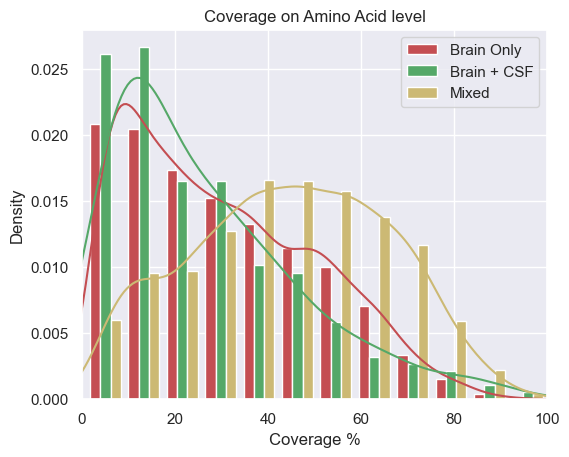

In [13]:
sns.set()
groupedcoverage = coveragedf.groupby(['Classification'])
print(groupedcoverage['Coverage'].get_group('Negative'))
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(6)
ax1.hist([groupedcoverage['Coverage'].get_group('Negative'), groupedcoverage['Coverage'].get_group('Positive'),groupedcoverage['Coverage'].get_group('Mixed')],bins=12, density=True,color=['r','g','y'])
kde = stats.gaussian_kde(groupedcoverage['Coverage'].get_group('Negative'))
xx = np.linspace(0, 100, 1000)
[groupedcoverage['Coverage'].get_group('Negative'), groupedcoverage['Coverage'].get_group('Positive'),groupedcoverage['Coverage'].get_group('Mixed')]
#finishes the plot
ax1.set_title("Coverage on Amino Acid level")
ax1.set_ylabel("Density")
ax1.set_xlabel("Coverage %")
ax1.legend(['Brain Only','Brain + CSF','Mixed'])
sns.kdeplot(ax=ax1, data=coveragedf[coveragedf['Classification']=='Negative'], x='Coverage', color='r').set(xlim=([0,100]))
sns.kdeplot(ax=ax1, data=coveragedf[coveragedf['Classification']=='Positive'], x='Coverage', color='g').set(xlim=(0))
sns.kdeplot(ax=ax1, data=coveragedf[coveragedf['Classification']=='Mixed'], x='Coverage', color='y').set(xlim=(0))

plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Negative v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=6.151e-87 stat=3.928e+02
Positive v.s. Negative: Kruskal-Wallis paired samples with Bonferroni correction, P_val=5.104e-04 stat=1.414e+01
Positive v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.259e-31 stat=1.356e+02


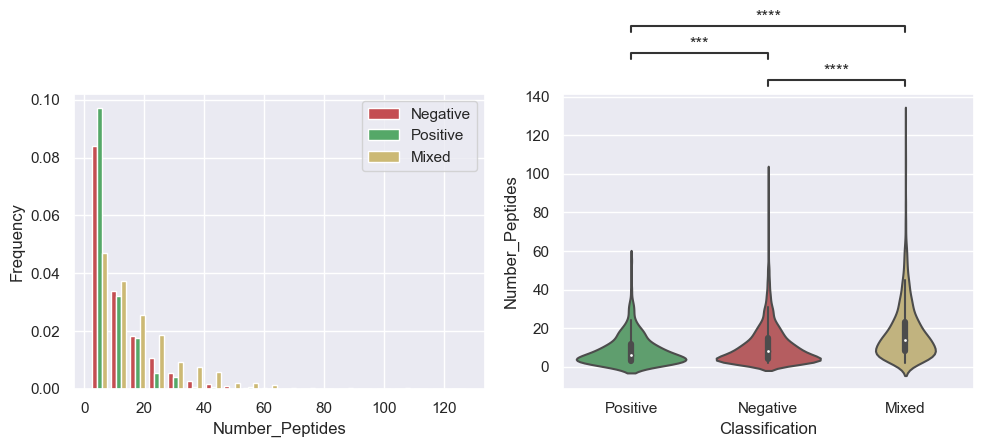

In [14]:
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([groupedcoverage['Number_Peptides'].get_group('Negative'), groupedcoverage['Number_Peptides'].get_group('Positive'),groupedcoverage['Number_Peptides'].get_group('Mixed')],bins=20 ,density=True,color=['r','g','y'])
#finishes the plot
ax1[0].set_ylabel("Frequency")
ax1[0].set_xlabel("Number_Peptides")
ax1[0].legend(['Negative','Positive','Mixed'])
sns.violinplot(data=coveragedf, x="Classification", y="Number_Peptides", ax=ax1[1],palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
add_stat_annotation(ax1[1], data=coveragedf, x='Classification', y='Number_Peptides',
                    box_pairs=[('Negative', 'Mixed'),('Mixed', 'Positive'),('Negative', 'Positive')],
                    test='Kruskal', text_format='star', loc='outside', verbose=2)
plt.tight_layout()
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Negative v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=6.921e-138 stat=6.269e+02
Positive v.s. Negative: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.000e+00 stat=4.355e-01
Positive v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.085e-19 stat=8.200e+01


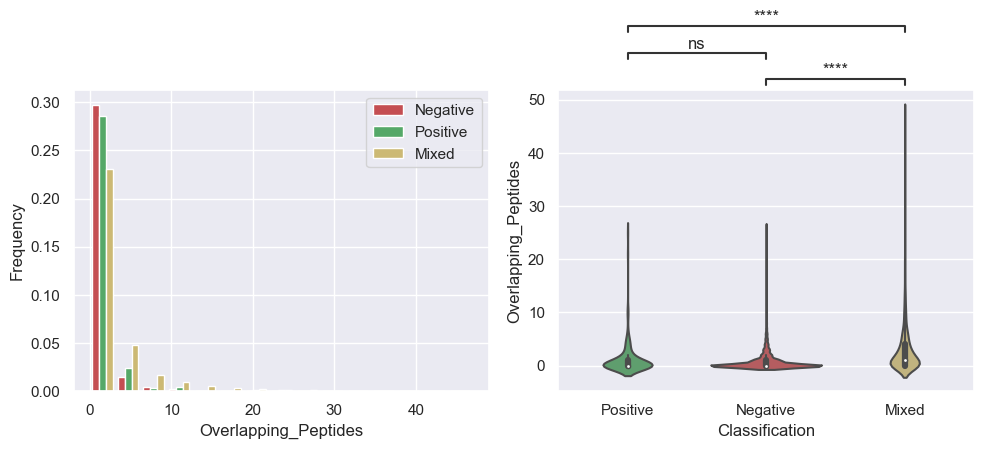

In [15]:
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([groupedcoverage['Overlapping_Peptides'].get_group('Negative'), groupedcoverage['Overlapping_Peptides'].get_group('Positive'),groupedcoverage['Overlapping_Peptides'].get_group('Mixed')],bins=15 ,density=True,color=['r','g','y'])
#finishes the plot
ax1[0].set_ylabel("Frequency")
ax1[0].set_xlabel("Overlapping_Peptides")
ax1[0].legend(['Negative','Positive','Mixed'])
sns.violinplot(data=coveragedf, x="Classification", y="Overlapping_Peptides", ax=ax1[1],palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
add_stat_annotation(ax1[1], data=coveragedf, x='Classification', y='Overlapping_Peptides',
                    box_pairs=[('Negative', 'Mixed'),('Mixed', 'Positive'),('Negative', 'Positive')],
                    test='Kruskal', text_format='star', loc='outside', verbose=2)
plt.tight_layout()
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Negative v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.618e-01 stat=2.033e+00
Positive v.s. Negative: Kruskal-Wallis paired samples with Bonferroni correction, P_val=8.565e-03 stat=8.898e+00
Positive v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.632e-03 stat=1.196e+01


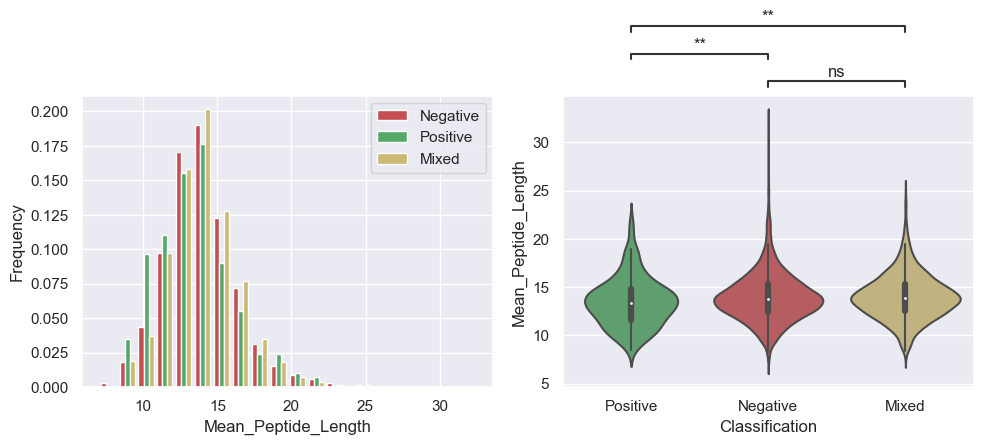

In [16]:
# plot average peptide length
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([groupedcoverage['Mean_Peptide_Length'].get_group('Negative'), groupedcoverage['Mean_Peptide_Length'].get_group('Positive'),groupedcoverage['Mean_Peptide_Length'].get_group('Mixed')],bins=20 ,density=True,color=['r','g','y'])
#finishes the plot
ax1[0].set_ylabel("Frequency")
ax1[0].set_xlabel("Mean_Peptide_Length")
ax1[0].legend(['Negative','Positive','Mixed'])
sns.violinplot(data=coveragedf, x="Classification", y="Mean_Peptide_Length", ax=ax1[1],palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
add_stat_annotation(ax1[1], data=coveragedf, x='Classification', y='Mean_Peptide_Length',
                    box_pairs=[('Negative', 'Mixed'),('Mixed', 'Positive'),('Negative', 'Positive')],
                    test='Kruskal', text_format='star', loc='outside', verbose=2)
plt.tight_layout()
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Negative v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.442e-04 stat=1.488e+01
Positive v.s. Negative: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.670e-03 stat=1.104e+01
Positive v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.545e-01 stat=2.441e+00


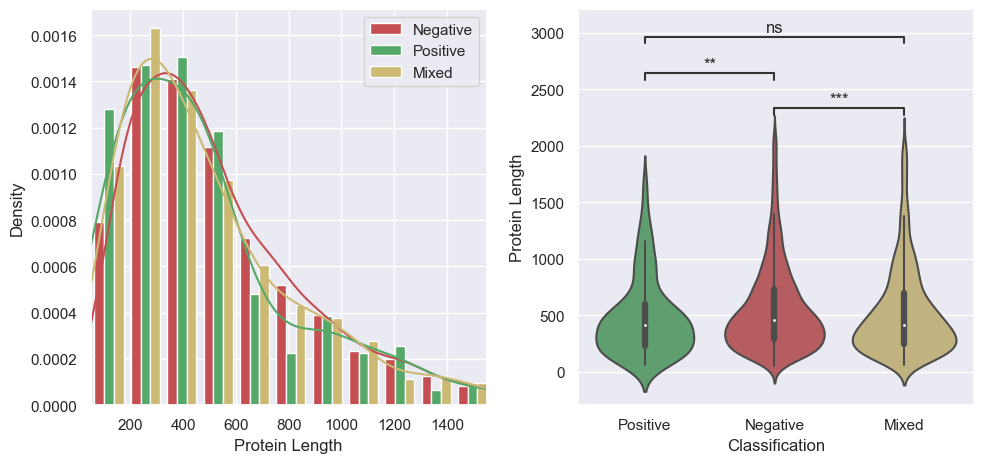

In [17]:
# plot protein length
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([groupedcoverage['Protein_Length'].get_group('Negative'), groupedcoverage['Protein_Length'].get_group('Positive'),groupedcoverage['Protein_Length'].get_group('Mixed')],bins=15 ,density=True,color=['r','g','y'])
ax1[0].set_xlim([50, 1550])
#finishes the plot
ax1[0].set_ylabel("Density")
ax1[0].set_xlabel("Protein Length")
ax1[0].legend(['Negative','Positive','Mixed'])
ax = sns.violinplot(data=coveragedf, x="Classification", y="Protein_Length",palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
add_stat_annotation(ax, data=coveragedf, x="Classification", y="Protein_Length",
                    box_pairs=[("Negative", "Mixed"), ("Mixed", "Positive"), ("Negative", "Positive")],
                    test='Kruskal', text_format='star', loc='inside', verbose=2)
ax1[1].set_ylabel("Protein Length")
sns.kdeplot(ax=ax1[0], data=coveragedf[coveragedf['Classification']=='Negative'], x='Protein_Length', color='r')
sns.kdeplot(ax=ax1[0], data=coveragedf[coveragedf['Classification']=='Positive'], x='Protein_Length', color='g')
sns.kdeplot(ax=ax1[0], data=coveragedf[coveragedf['Classification']=='Mixed'], x='Protein_Length', color='y')
plt.tight_layout()
plt.show()

In [18]:
theocoverage

Protein   Coverage Classification  Positive  Negative  Unfound
0     A0A0B4J2A0  25.000000       Negative         0         9       27
1     A0A0C4DH38  30.000000       Negative         0         3        7
2         A0AVT1  51.327434       Negative         0        58       55
3         A0FGR8  22.314050          Mixed         1        26       94
4         A0JNW5   9.615385       Negative         0        15      141
...          ...        ...            ...       ...       ...      ...
4562      Q9Y6U3  26.436782          Mixed         4        19       64
4563      Q9Y6W5  17.857143       Negative         0        10       46
4564      Q9Y6X4  37.142857       Negative         0        26       44
4565      Q9Y6X5  18.918919          Mixed         1         6       30
4566      Q9Y6Y8  21.276596       Negative         0        20       74

[4567 rows x 6 columns]

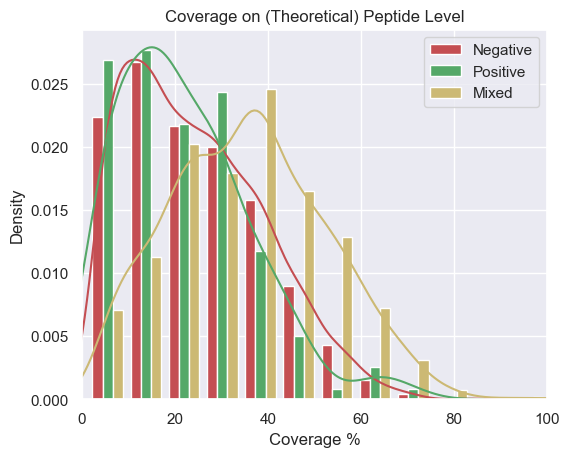

In [19]:
sns.set()
groupedcoverage = theocoverage.groupby(['Classification'])
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(6)
ax1.hist([groupedcoverage['Coverage'].get_group('Negative'), groupedcoverage['Coverage'].get_group('Positive'),groupedcoverage['Coverage'].get_group('Mixed')],bins=12, density=True,color=['r','g','y'])
#finishes the plot
ax1.set_ylabel("Density")
ax1.set_xlabel("Coverage %")
ax1.set_title('Coverage on (Theoretical) Peptide Level')
ax1.legend(['Negative','Positive','Mixed'])
sns.kdeplot(ax=ax1, data=theocoverage[theocoverage['Classification']=='Negative'], x='Coverage', color='r').set(xlim=([0,100]))
sns.kdeplot(ax=ax1, data=theocoverage[theocoverage['Classification']=='Positive'], x='Coverage', color='g').set(xlim=(0))
sns.kdeplot(ax=ax1, data=theocoverage[theocoverage['Classification']=='Mixed'], x='Coverage', color='y').set(xlim=(0))
plt.show()

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Negative v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.490e-112 stat=5.105e+02
Positive v.s. Negative: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.409e-02 stat=7.992e+00
Positive v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.346e-32 stat=1.417e+02


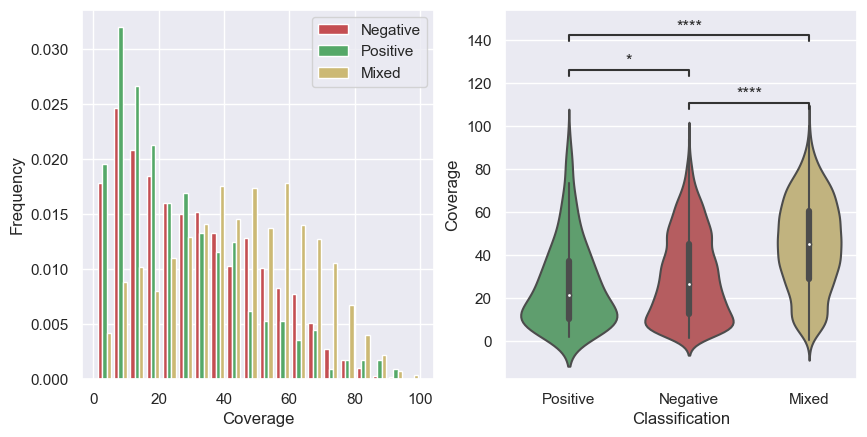

In [20]:
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([groupedcoverage['Coverage'].get_group('Negative'), groupedcoverage['Coverage'].get_group('Positive'),groupedcoverage['Coverage'].get_group('Mixed')],bins=20, density=True,color=['r','g','y'])
#finishes the plot
ax1[0].set_ylabel("Frequency")
ax1[0].set_xlabel("Coverage")
ax1[0].legend(['Negative','Positive','Mixed'])
ax = sns.violinplot(data=coveragedf, x="Classification", y="Coverage", ax=ax1[1],palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
add_stat_annotation(ax, data=coveragedf, x="Classification", y="Coverage",
                    box_pairs=[("Negative", "Mixed"), ("Mixed", "Positive"), ("Negative", "Positive")],
                    test='Kruskal', text_format='star', loc='inside', verbose=2)
plt.show()

#### Difference of number transitions with different detectability ranges (high are only high detectability peptides)

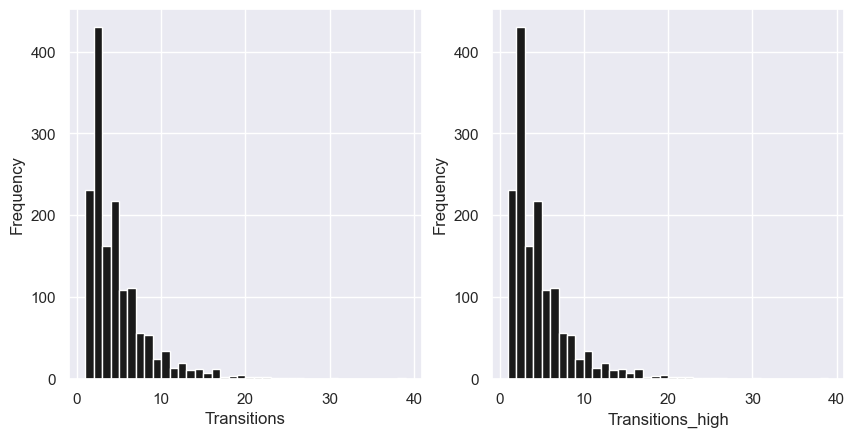

Protein   Coverage Classification  Positive  Negative  Unfound  \
0     A0FGR8  22.314050          Mixed         1        26       94   
1     A0MZ66  40.404040          Mixed         3        37       59   
2     A2RU67  22.916667          Mixed         2         9       37   
3     A6NE02  13.636364          Mixed         2         4       38   
4     A6NGB9  23.913043          Mixed         1        10       35   
...      ...        ...            ...       ...       ...      ...   
1521  Q9Y6I3  33.333333          Mixed         1        15       32   
1522  Q9Y6M5  18.604651          Mixed         1         7       35   
1523  Q9Y6N8  19.753086          Mixed        13         3       65   
1524  Q9Y6U3  26.436782          Mixed         4        19       64   
1525  Q9Y6X5  18.918919          Mixed         1         6       30   

      Transitions  
0               2  
1               4  
2               4  
3               2  
4               1  
...           ...  
1521            2  
1522            2  
1523            1  
1524            7  
1525            2  

[1526 rows x 7 columns]

In [21]:
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([transitiondf['Transitions']],bins=range(min(transitiondf['Transitions']), max(transitiondf['Transitions']) + 1), density=False,color=['k'])
#finishes the plot
ax1[0].set_ylabel("Frequency")
ax1[0].set_xlabel("Transitions")
#ax1[0].legend(['Negative','Positive','Mixed'])
ax1[1].hist([transitiondf['Transitions']],bins=range(min(transitiondf['Transitions']), max(transitiondf['Transitions']) + 1), density=False,color=['k'])
#finishes the plot
ax1[1].set_ylabel("Frequency")
ax1[1].set_xlabel("Transitions_high")
#ax1[0].legend(['Negative','Positive','Mixed'])

plt.show()
transitiondf

NameError: name 'transitiondf_high' is not defined

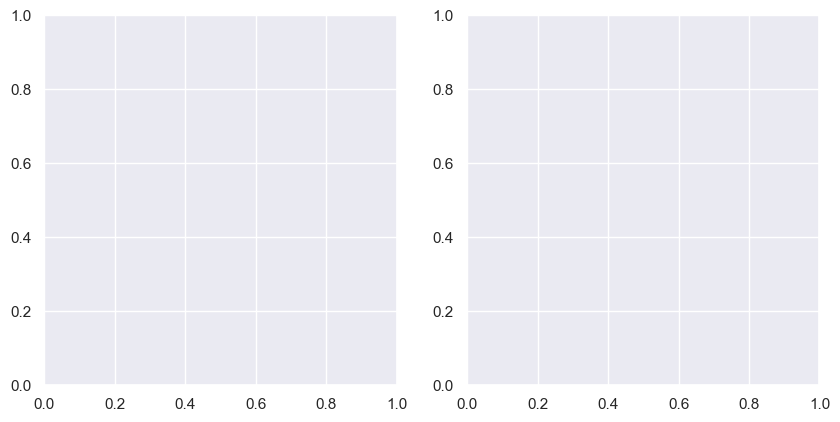

In [22]:
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([transitiondf['Transitions'], transitiondf_high['Transitions'],transitiondf_two['Transitions'],transitiondf_one['Transitions']],bins=np.arange(100) - 0.5,density=True)
#finishes the plot
ax1[0].set_ylabel("Density")
ax1[0].set_xlabel("Number of Transitions")
ax1[0].legend(['All Peptides','>0.5 Detection Rate','>0.2 Detection Rate','>0.1 Detection Rate'])
plt.tight_layout()
ax1[0].set_xlim([-0.5, 10.5])
ax1[0].set_xticks([num for num in np.arange(1, 12, step=1) if num % 2 != 0])
sns.kdeplot(ax=ax1[0], data=transitiondf, x='Transitions', color='b')
sns.kdeplot(ax=ax1[0], data=transitiondf_high, x='Transitions', color='orange')
sns.kdeplot(ax=ax1[0], data=transitiondf_two, x='Transitions', color='g')
sns.kdeplot(ax=ax1[0], data=transitiondf_one, x='Transitions', color='r')
#sns.violinplot(data=transitiondf,x='Classification', y="Mismatch", ax=ax1[1])
data = {
    'All' : transitiondf['Transitions'],
    'High' : transitiondf_high['Transitions'],
    'Two' : transitiondf_two['Transitions'],
    'One': transitiondf_one['Transitions']
}

def dict2pandas(d, keyname, valname):
    dframes = []
    for k,v in d.items():
        dframes += [pd.DataFrame({keyname : [k] * len(v), valname : v})]
    return pd.concat(dframes)

dataDF = dict2pandas(data, 'Different Detection Rates', 'Number of Transitions')
sns.violinplot(data=dataDF, x='Different Detection Rates', y='Number of Transitions', scale='width', axis=ax1[1])
# add_stat_annotation(ax1[1], data=dataDF, x="Different Detection Rates", y="Number of Transitions",
#                     box_pairs=[("All", "High"), ("Two", "One"), ("All", "Two"),("High", "Two") ,("High", "One"), ("All", "One")],
#                     test='Mann-Whitney', text_format='star', loc='outside', verbose=3)
plt.show()

In [23]:
transitiondf[transitiondf['Transitions']==1]

Protein   Coverage Classification  Positive  Negative  Unfound  \
4     A6NGB9  23.913043          Mixed         1        10       35   
5     A6NL88  15.789474          Mixed         1         8       48   
7     B4DS77   7.843137          Mixed         1         3       47   
10    O00142  20.512821          Mixed         1         7       31   
21    O00305  15.068493          Mixed         1        10       62   
...      ...        ...            ...       ...       ...      ...   
1487  Q9Y2G8   3.092784          Mixed         1         2       94   
1492  Q9Y2R0  29.411765          Mixed         1         4       12   
1498  Q9Y328  22.727273          Mixed         1         4       17   
1514  Q9Y5Y7   8.108108          Mixed         2         1       34   
1523  Q9Y6N8  19.753086          Mixed        13         3       65   

      Transitions  
4               1  
5               1  
7               1  
10              1  
21              1  
...           ...  
1487            1  
1492            1  
1498            1  
1514            1  
1523            1  

[231 rows x 7 columns]

#### Add the sequence based features from peptides library

In [24]:
# create new features such as:
# - amino acid counts -> frequencies() or counts()
peptidefrequencies = strict['Peptide_Sequence'].apply(lambda x: {k:v for k,v in peptides.Peptide(x).frequencies().items()})
strict['A'] = [dic['A'] for dic in peptidefrequencies]
strict['R'] = [dic['R'] for dic in peptidefrequencies]
strict['N'] = [dic['N'] for dic in peptidefrequencies]
strict['D'] = [dic['D'] for dic in peptidefrequencies]
strict['C'] = [dic['C'] for dic in peptidefrequencies]
strict['Q'] = [dic['Q'] for dic in peptidefrequencies]
strict['E'] = [dic['E'] for dic in peptidefrequencies]
strict['G'] = [dic['G'] for dic in peptidefrequencies]
strict['H'] = [dic['H'] for dic in peptidefrequencies]
strict['I'] = [dic['I'] for dic in peptidefrequencies]
strict['L'] = [dic['L'] for dic in peptidefrequencies]
strict['K'] = [dic['K'] for dic in peptidefrequencies]
strict['M'] = [dic['M'] for dic in peptidefrequencies]
strict['F'] = [dic['F'] for dic in peptidefrequencies]
strict['P'] = [dic['P'] for dic in peptidefrequencies]
strict['S'] = [dic['S'] for dic in peptidefrequencies]
strict['T'] = [dic['T'] for dic in peptidefrequencies]
strict['W'] = [dic['W'] for dic in peptidefrequencies]
strict['Y'] = [dic['Y'] for dic in peptidefrequencies]
strict['V'] = [dic['V'] for dic in peptidefrequencies]
strict['O'] = [dic['O'] for dic in peptidefrequencies]
strict['U'] = [dic['U'] for dic in peptidefrequencies]
strict['B'] = [dic['B'] for dic in peptidefrequencies]
strict['Z'] = [dic['Z'] for dic in peptidefrequencies]
strict['J'] = [dic['J'] for dic in peptidefrequencies]
strict['X'] = [dic['X'] for dic in peptidefrequencies]
# - global charge -> peptide.mz() or charge
strict['MZ'] = strict['Peptide_Sequence'].apply(lambda x: peptides.Peptide(x).mz())
strict['Charge'] = strict['Peptide_Sequence'].apply(lambda x: peptides.Peptide(x).charge())
# - moleculair weight -> peptide.molecular_weight()
strict['Weight'] = strict['Peptide_Sequence'].apply(lambda x: peptides.Peptide(x).molecular_weight())
# - length distribution
# - global hydrophobicity -> peptide.hydrophobicity(scale="Aboderin")
strict['Hydrophobicity'] = strict['Peptide_Sequence'].apply(lambda x: peptides.Peptide(x).hydrophobicity()) 
# - global hydrophobic movement -> peptide.hydrophobic_moment(angle=100)
strict['Hydrophobic_Moment'] = strict['Peptide_Sequence'].apply(lambda x: peptides.Peptide(x).hydrophobic_moment()) 
# - instability -> round(peptide.instability_index(), 2)
strict['Instability'] = strict['Peptide_Sequence'].apply(lambda x: round(peptides.Peptide(x).instability_index(), 2)) 
# structure -> p.structural_class("Chou", distance="correlation")
strict['Structure'] = strict['Peptide_Sequence'].apply(lambda x: peptides.Peptide(x).structural_class())
# plot above features with CSF column as seperator
strict.describe()

Sequence_Length  Detectability  Detection_Probability  Protein_Length  \
count     70192.000000   70192.000000           70192.000000    70192.000000   
mean         13.979770       0.878861               0.733404      704.159206   
std           5.969858       0.326291               0.207520      442.126309   
min           6.000000       0.000000               0.000000       51.000000   
25%          10.000000       1.000000               0.664242      373.000000   
50%          12.000000       1.000000               0.783814      589.000000   
75%          17.000000       1.000000               0.879839      932.000000   
max          51.000000       1.000000               0.999162     2115.000000   

       Position_in_Protein             A             R             N  \
count         70192.000000  70192.000000  70192.000000  70192.000000   
mean            349.697173      0.075822      0.045678      0.038789   
std             322.055891      0.082422      0.052458      0.055807   
min               0.000000      0.000000      0.000000      0.000000   
25%             117.000000      0.000000      0.000000      0.000000   
50%             254.000000      0.066667      0.033333      0.000000   
75%             478.000000      0.125000      0.083333      0.076923   
max            2063.000000      0.818182      0.428571      0.500000   

                  D             C  ...        B        Z        J        X  \
count  70192.000000  70192.000000  ...  70192.0  70192.0  70192.0  70192.0   
mean       0.058688      0.011781  ...      0.0      0.0      0.0      0.0   
std        0.065885      0.033142  ...      0.0      0.0      0.0      0.0   
min        0.000000      0.000000  ...      0.0      0.0      0.0      0.0   
25%        0.000000      0.000000  ...      0.0      0.0      0.0      0.0   
50%        0.050000      0.000000  ...      0.0      0.0      0.0      0.0   
75%        0.100000      0.000000  ...      0.0      0.0      0.0      0.0   
max        0.500000      0.500000  ...      0.0      0.0      0.0      0.0   

                 MZ        Charge        Weight  Hydrophobicity  \
count  70192.000000  70192.000000  70192.000000    70192.000000   
mean     786.776450     -0.794138   1563.012464       -0.326412   
std      319.477382      1.574965    634.819157        0.783030   
min      308.176651    -16.970056    614.699440       -3.675000   
25%      547.298026     -1.908255   1088.144140       -0.825000   
50%      706.827362     -0.907851   1403.488690       -0.300000   
75%      945.950073      0.088486   1879.056915        0.200000   
max     2371.172606      3.179793   4743.177240        2.914286   

       Hydrophobic_Moment   Instability  
count        70192.000000  70192.000000  
mean             0.348919     40.395484  
std              0.138517     34.926613  
min              0.001774    -65.460000  
25%              0.251268     14.840000  
50%              0.341594     36.800000  
75%              0.439452     61.570000  
max              1.009464    240.850000  

[8 rows x 37 columns]

In [25]:
def box_and_whisker(data, title, ylabel, xticklabels):
    """
    Create a box-and-whisker plot with significance bars.
    """
    ax = plt.axes()
    bp = ax.boxplot(data, widths=0.6, patch_artist=True)
    # Graph title
    ax.set_title(title, fontsize=14)
    # Label y-axis
    ax.set_ylabel(ylabel)
    # Label x-axis ticks
    ax.set_xticklabels(xticklabels)
    # Hide x-axis major ticks
    ax.tick_params(axis='x', which='major', length=0)
    # Show x-axis minor ticks
    xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
    ax.set_xticks(xticks, minor=True)
    # Clean up the appearance
    ax.tick_params(axis='x', which='minor', length=3, width=1)

    # Change the colour of the boxes to Seaborn's 'pastel' palette
    colors = sns.color_palette('pastel')
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    # Colour of the median lines
    plt.setp(bp['medians'], color='k')

    # Check for statistical significance
    significant_combinations = []
    # Check from the outside pairs of boxes inwards
    ls = list(range(1, len(data) + 1))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]
    for c in combinations:
        data1 = data[c[0] - 1]
        data2 = data[c[1] - 1]
        # Significance
        U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        if p < 0.05:
            significant_combinations.append([c, p])

    # Get info about y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom

    # Significance bars
    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = len(significant_combinations) - i
        # Plot the bar
        bar_height = (yrange * 0.08 * level) + top
        bar_tips = bar_height - (yrange * 0.02)
        plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        # Significance level
        p = significant_combination[1]
        if p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
        text_height = bar_height + (yrange * 0.01)
        plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', c='k')

    # Adjust y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom
    ax.set_ylim(bottom - 0.02 * yrange, top)

    # Annotate sample size below each box
    for i, dataset in enumerate(data):
        sample_size = len(dataset)
        ax.text(i + 1, bottom, fr'n = {sample_size}', ha='center', size='x-small')

    plt.show()

#### Visualize amino acid frequencies for the peptide sequences

0.07582210288542272


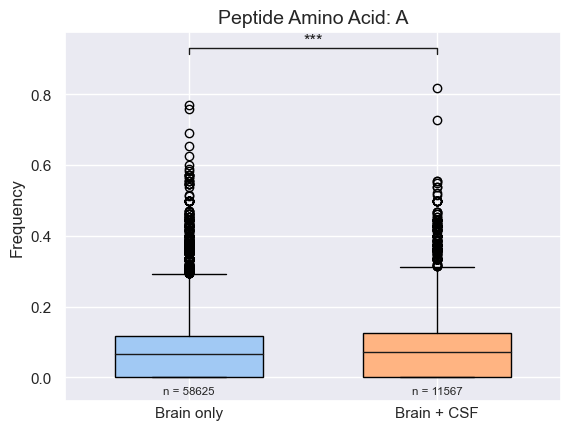

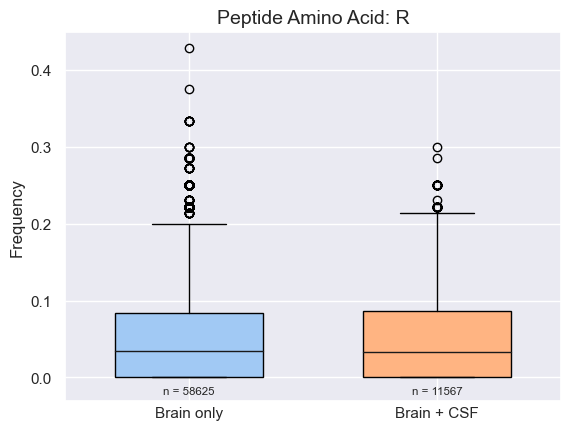

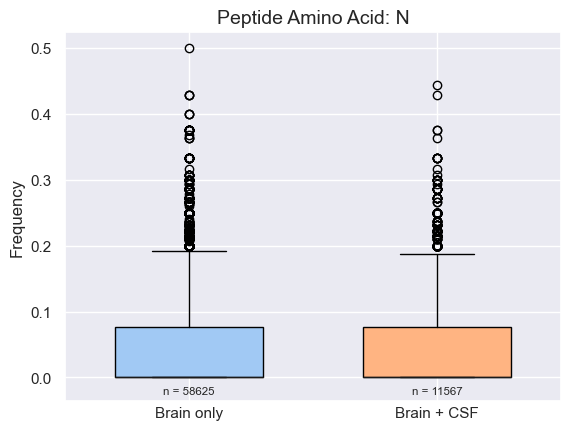

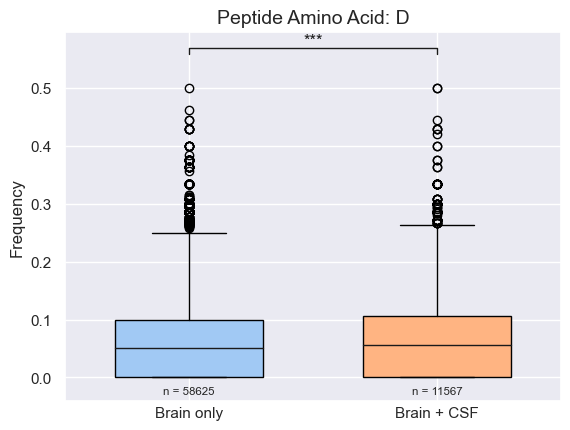

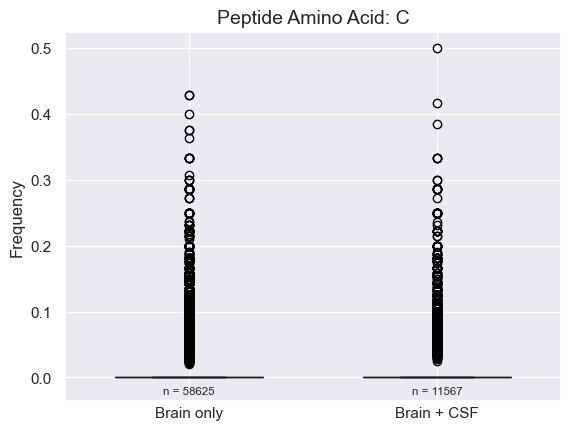

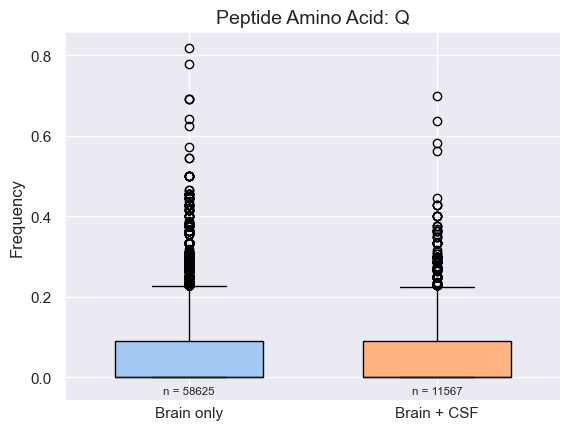

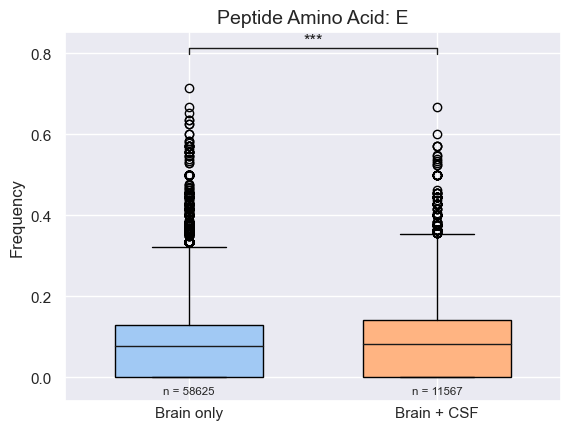

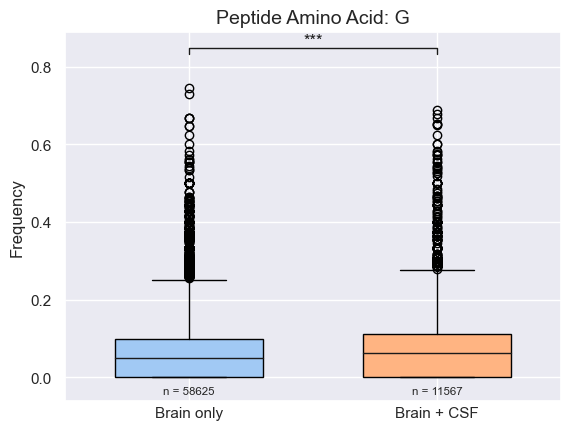

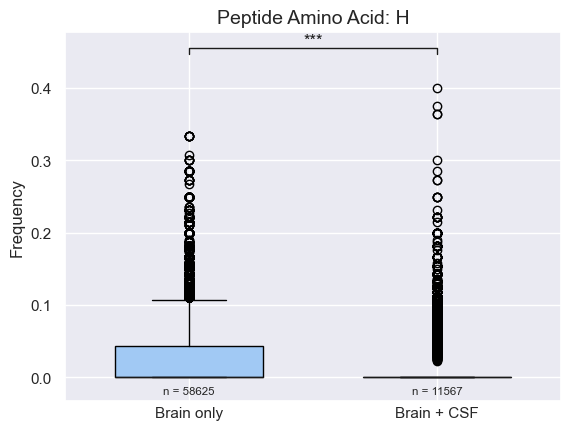

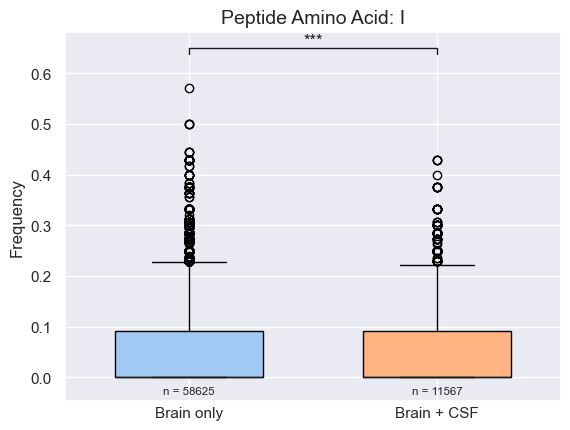

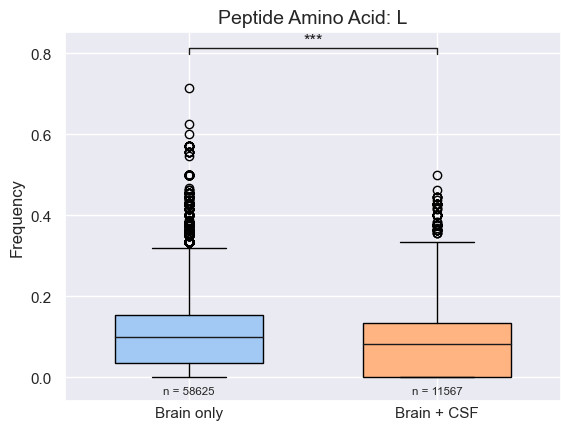

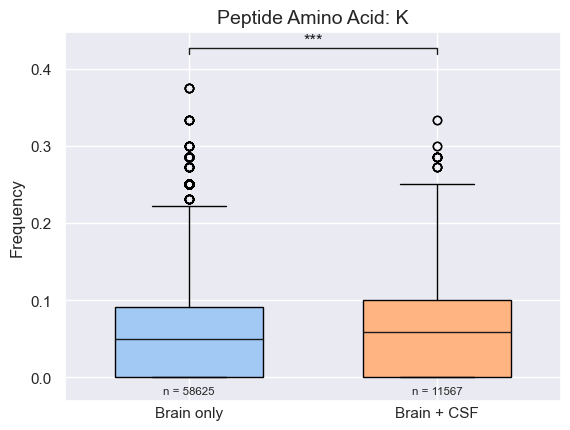

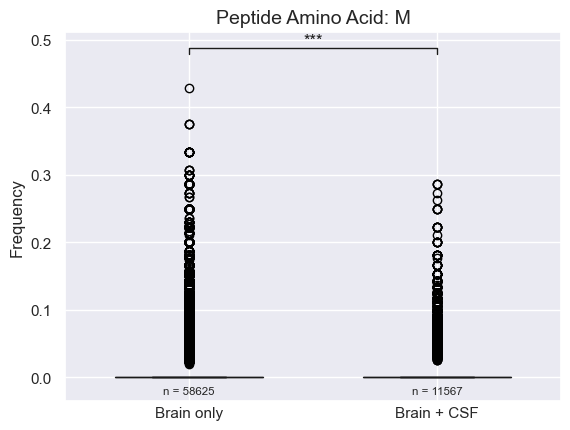

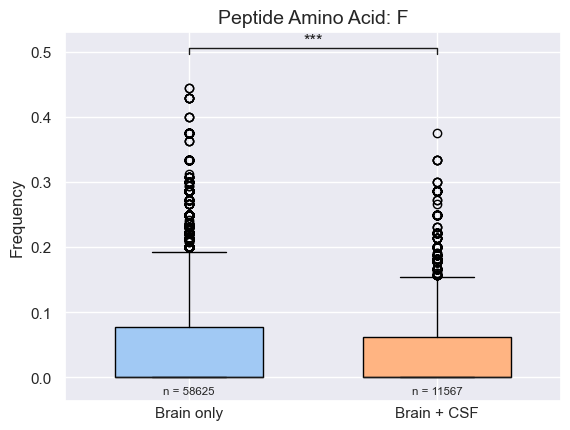

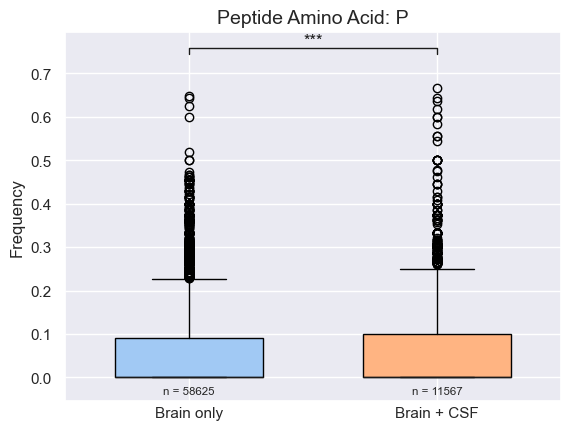

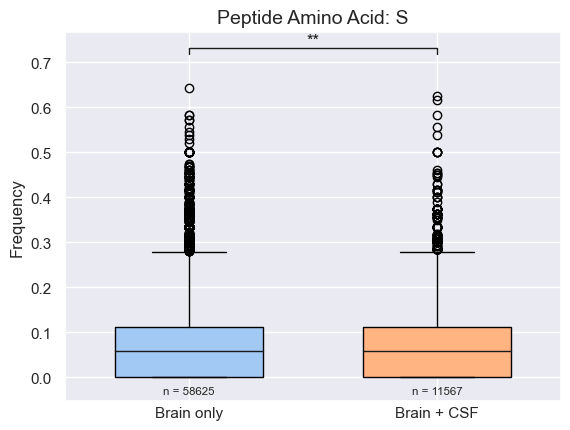

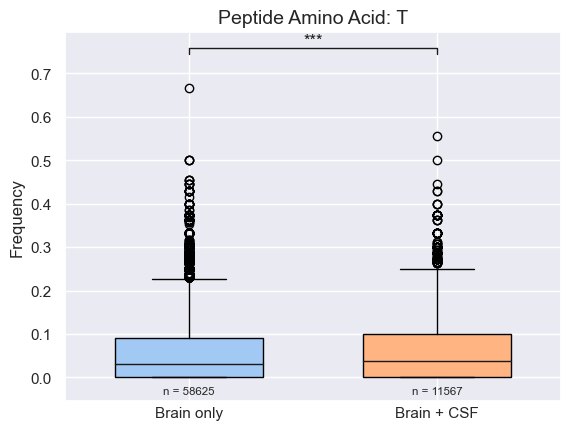

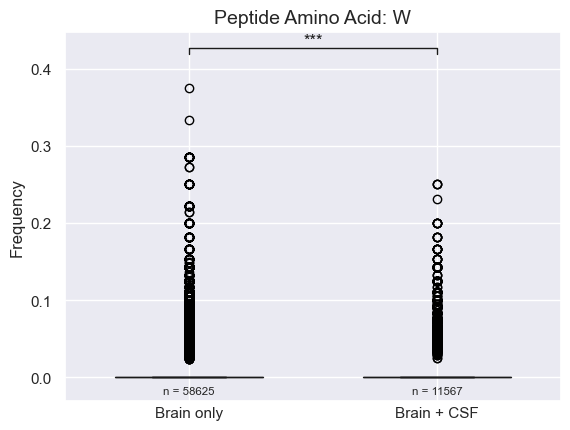

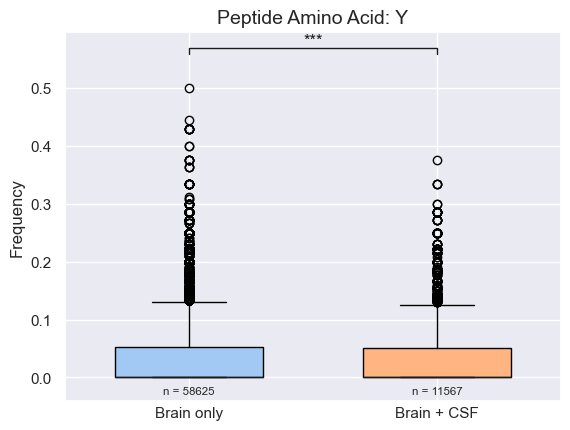

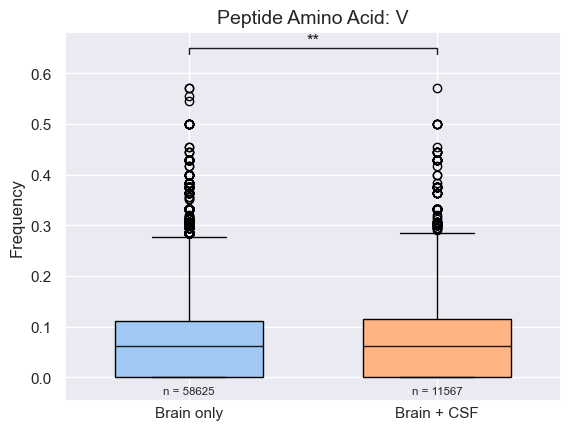

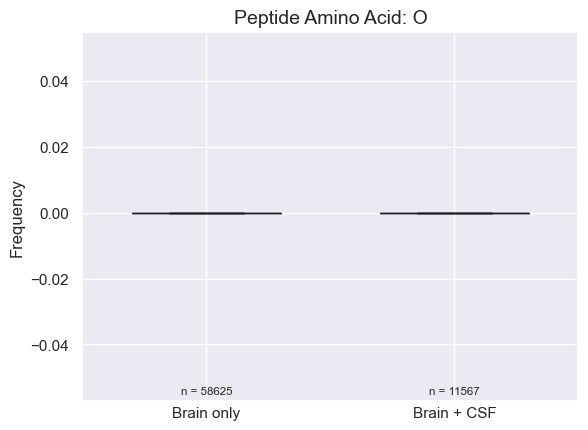

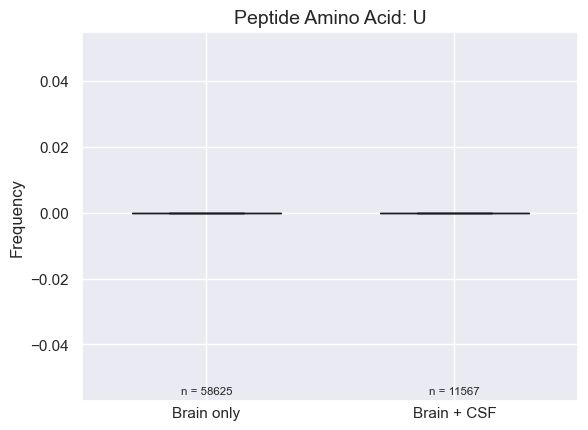

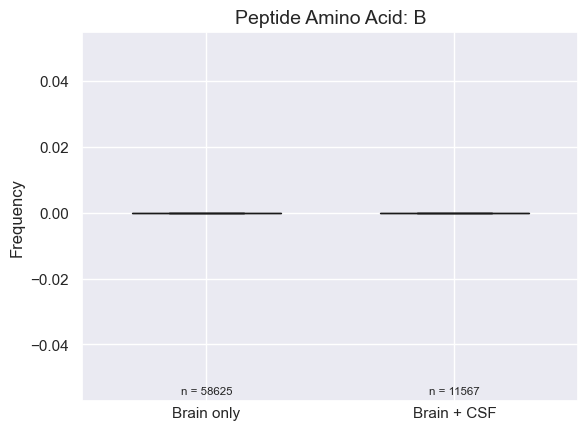

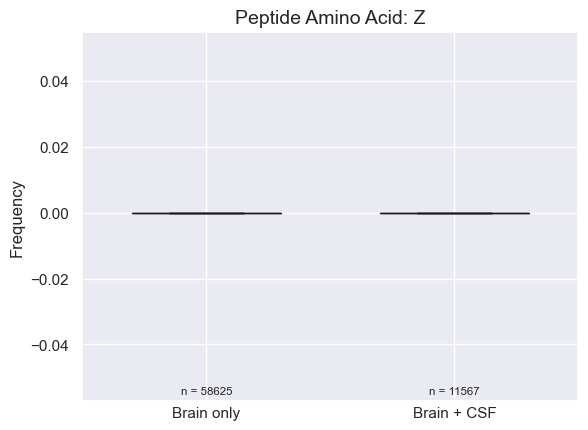

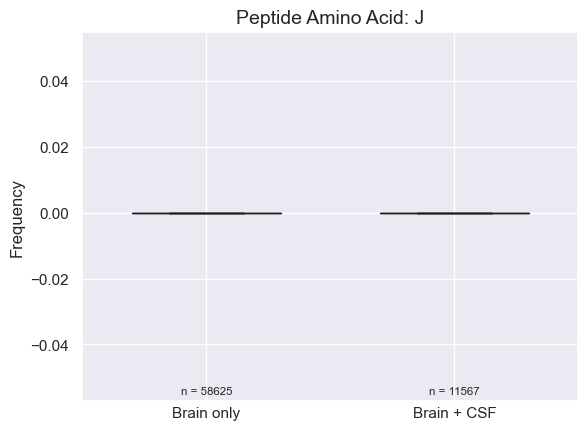

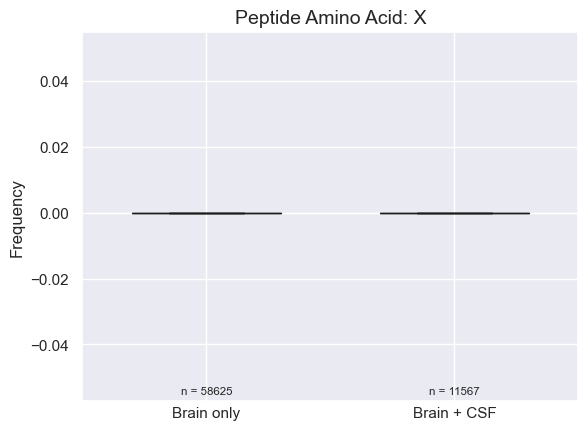

In [26]:
groupdata = strict.groupby(['CSF'])
print(strict['A'].mean())
temp = 0
k = 0
AA = ['A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V', 'O', 'U', 'B', 'Z', 'J', 'X']
for i,c in enumerate(AA):
    if i % 5 == 0:
        k = k + 1
    i = i % 5
    data = [groupdata.get_group('Brain Only')[c],groupdata.get_group('Brain + CSF')[c]]
    title = f'Peptide Amino Acid: {c}'
    ylabel = r'Frequency'
    xticklabels = ['Brain only', 'Brain + CSF']
    box_and_whisker(data, title, ylabel, xticklabels)
    plt.show()
plt.show()

#### Visualize amino acied frequencies for the proteins

5370
index
False    0.074059
True     0.076777
Name: A, dtype: float64


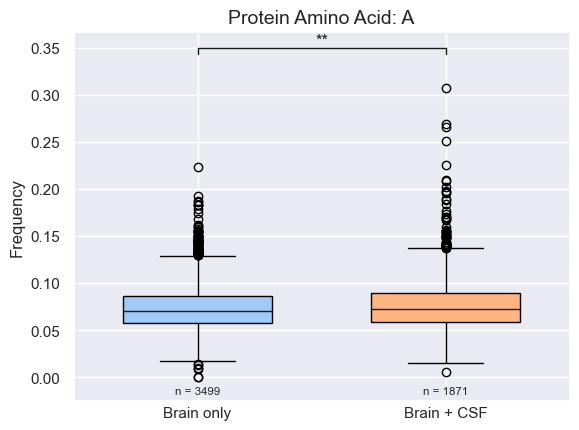

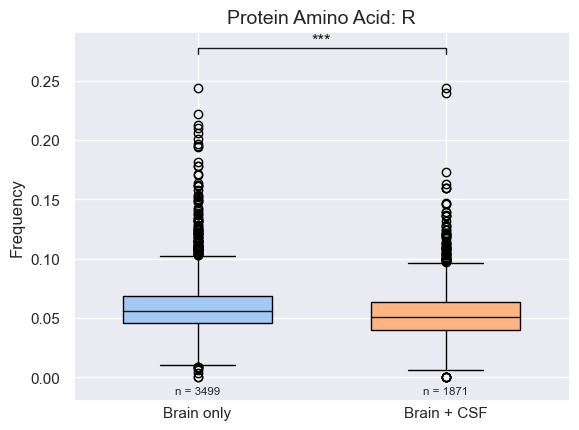

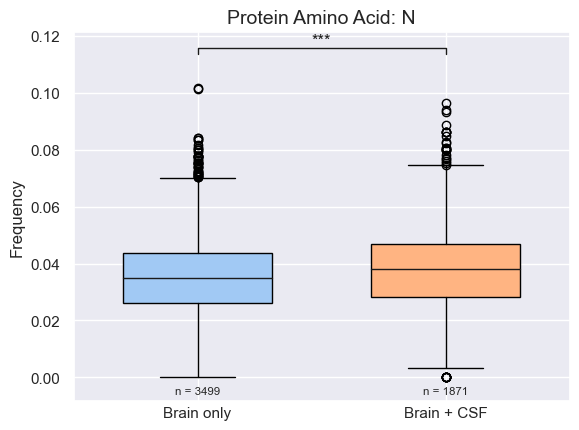

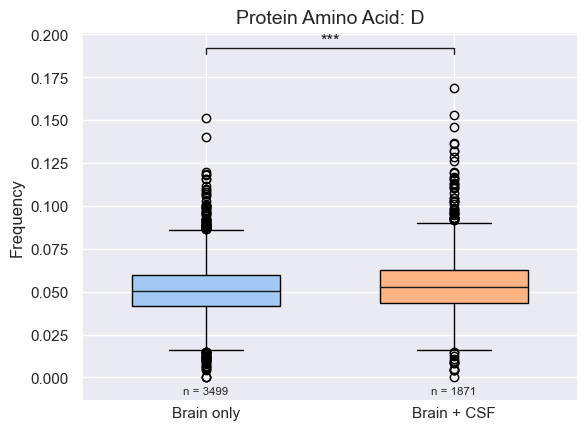

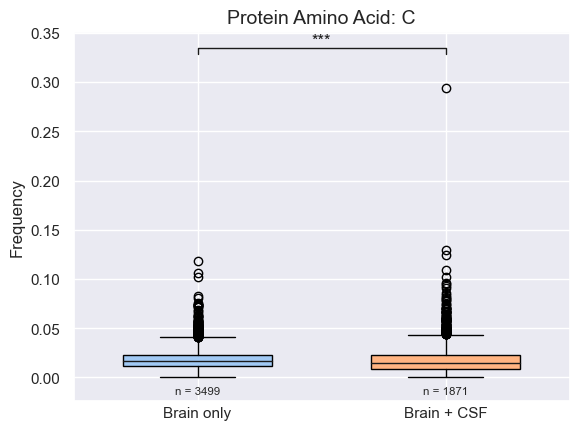

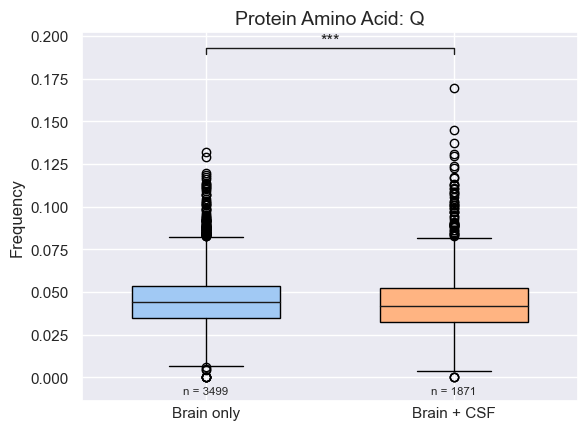

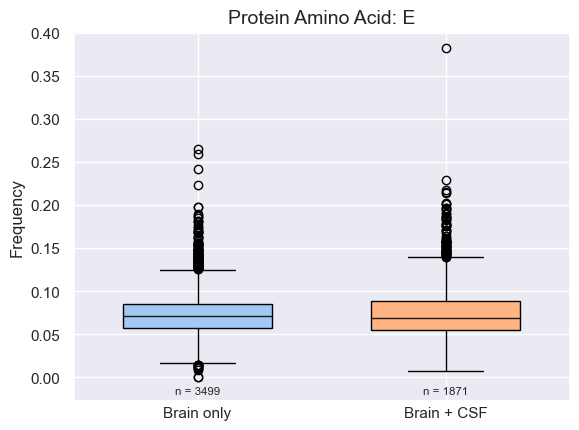

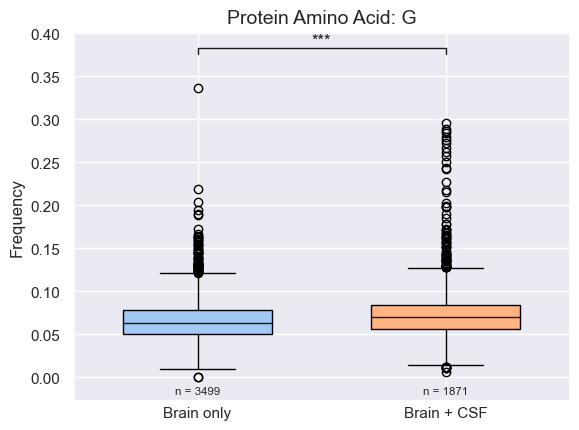

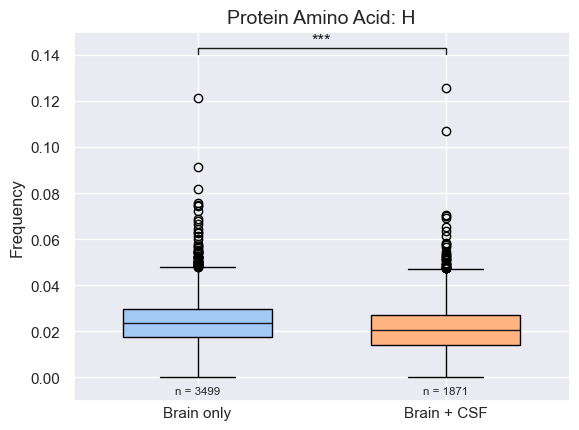

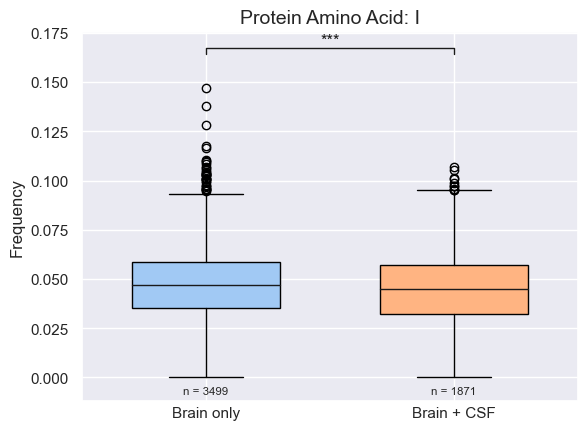

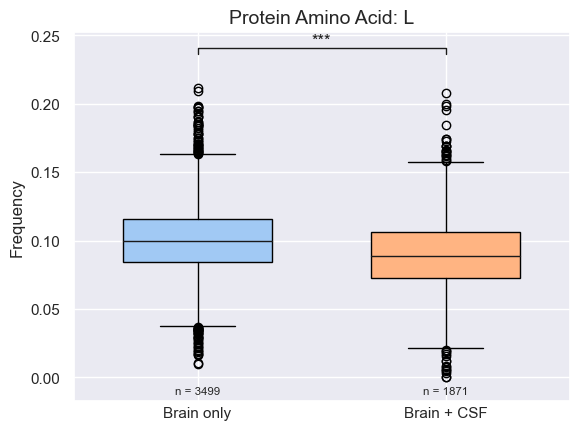

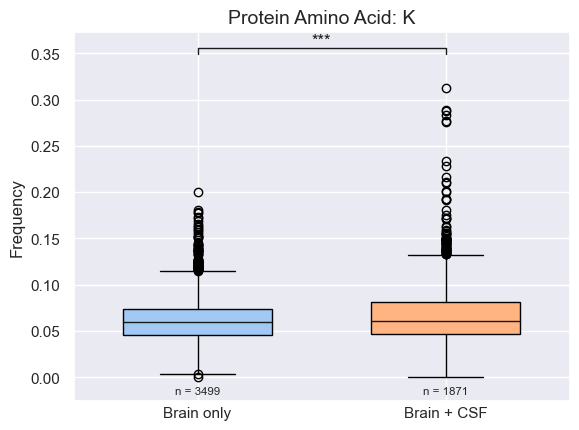

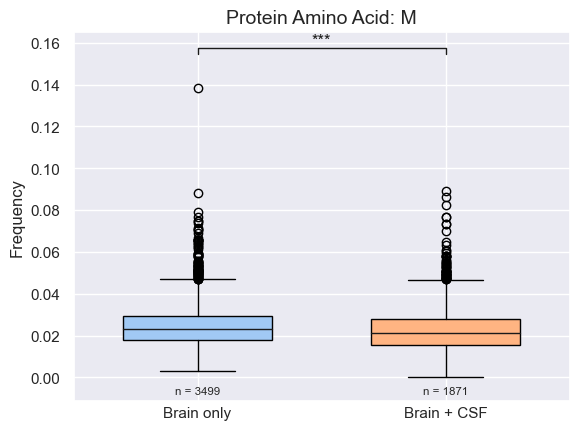

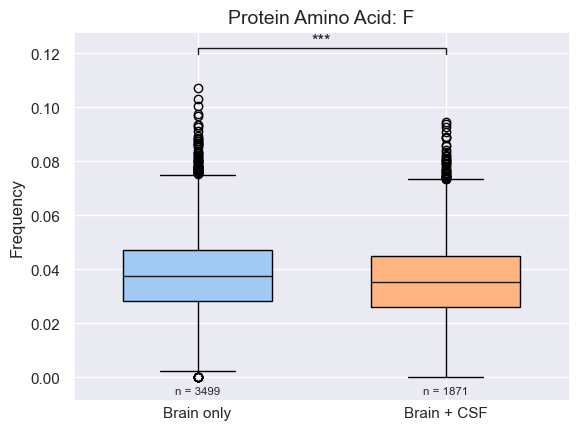

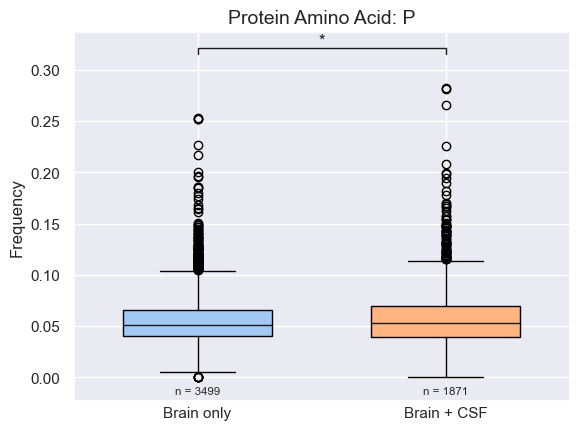

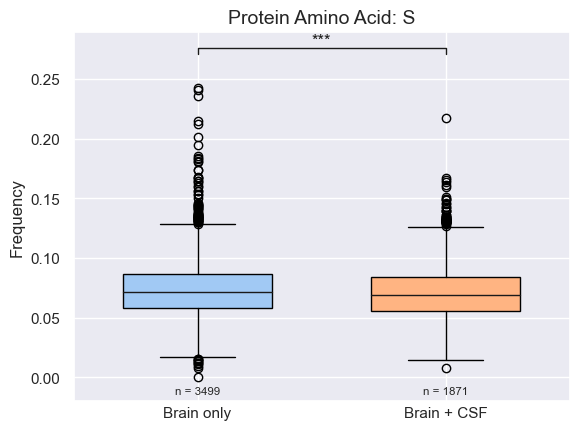

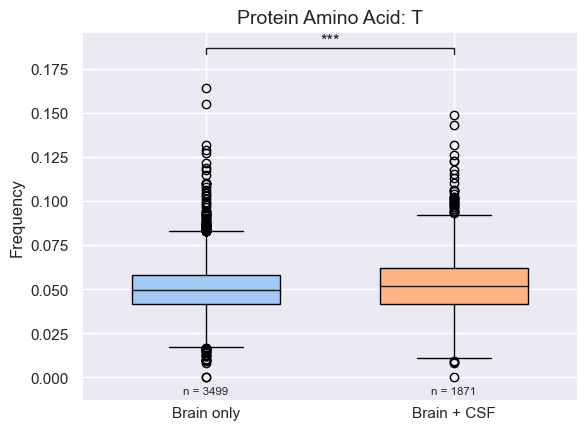

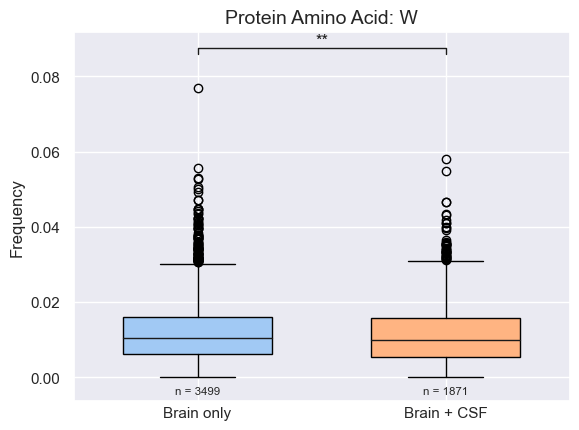

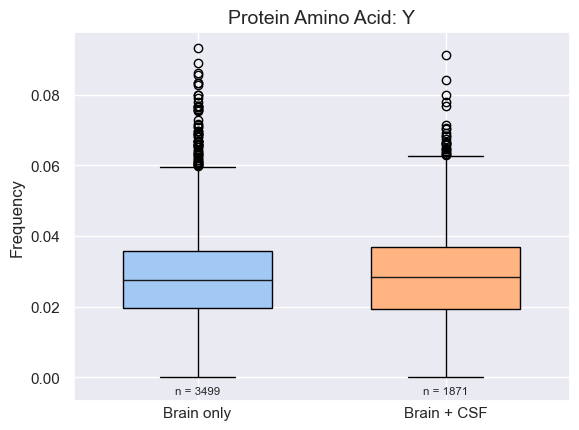

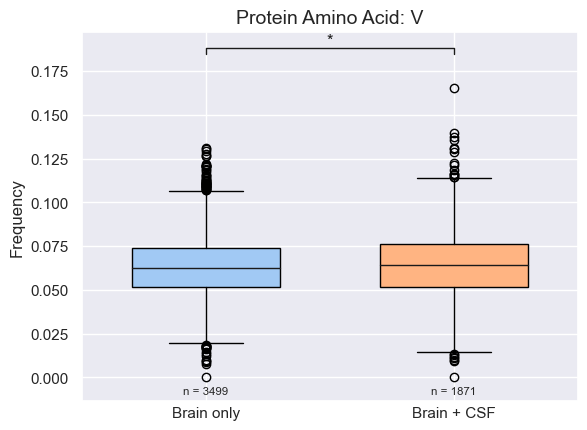

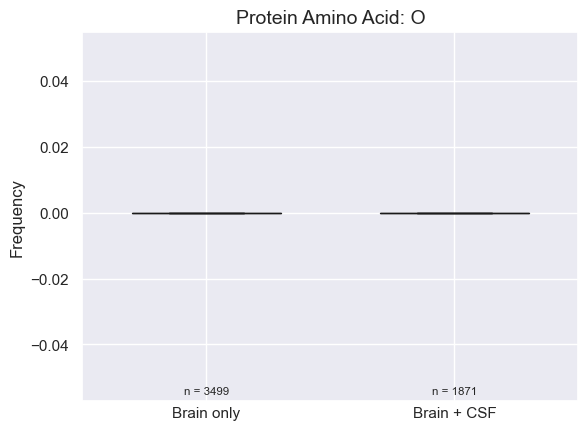

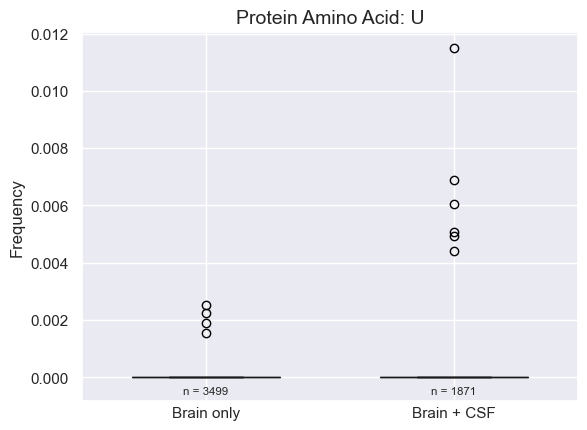

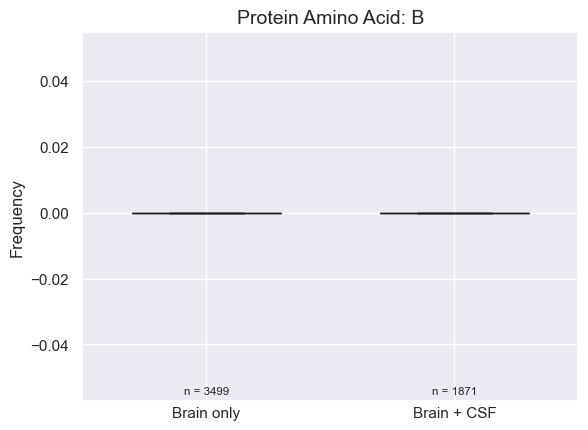

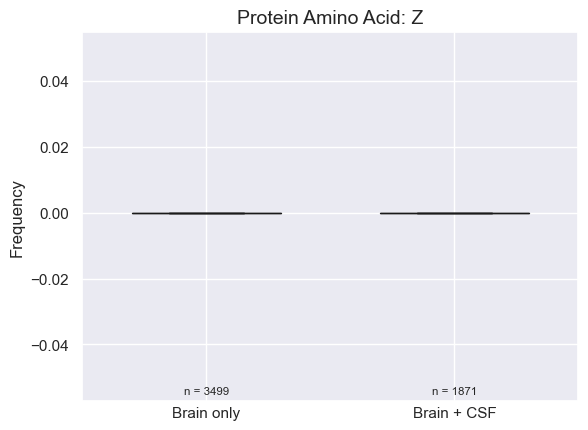

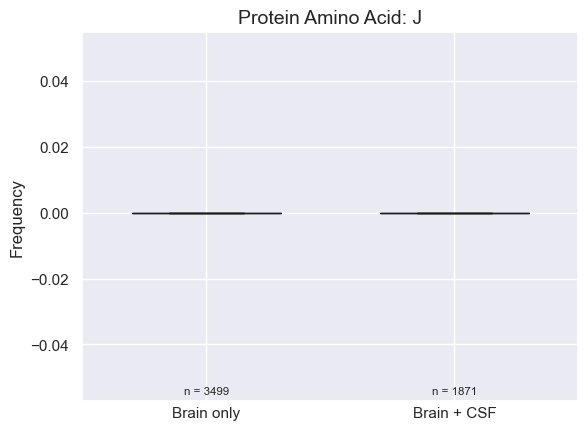

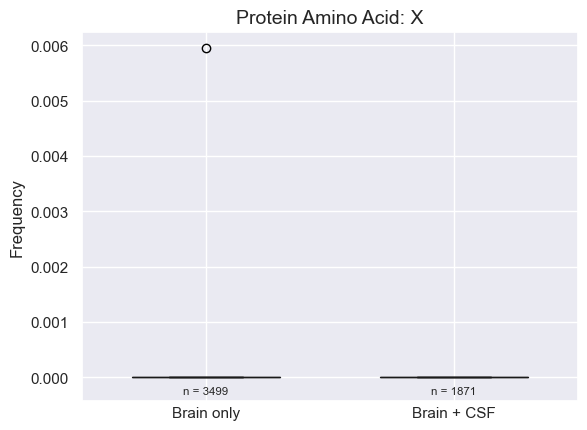

In [48]:
def checker(x):
    for pep in x['CSF']:
        if pep == 'Brain + CSF':
            return True
    return False
csflist = []
proteinseq = pd.Series(strict['Protein_Sequence'].unique())
print(len(proteinseq))
temp = strict.groupby(['Protein_Sequence'])
for x in proteinseq:
    csflist.append(checker(temp.get_group(x)))
pro = proteinseq.apply(lambda x: {k:v for k,v in peptides.Peptide(x).frequencies().items()})
proAAF = pd.DataFrame(list(pro),csflist)
proAAF.reset_index(inplace=True)

groupdata = proAAF.groupby(['index'])
print(groupdata['A'].mean())
for i,c in enumerate(AA):
    if i % 5 == 0:
        k = k + 1
    i = i % 5
    data = [groupdata.get_group(False)[c],groupdata.get_group(True)[c]]
    title = f'Protein Amino Acid: {c}'
    ylabel = r'Frequency'
    xticklabels = ['Brain only', 'Brain + CSF']
    box_and_whisker(data, title, ylabel, xticklabels)
    plt.show()
plt.show()

In [49]:
featuredata = strict.groupby(['CSF'])
print(strict['MZ'].describe())
featuredata['MZ'].get_group('Brain Only')

count    70192.000000
mean       786.776450
std        319.477382
min        308.176651
25%        547.298026
50%        706.827362
75%        945.950073
max       2371.172606
Name: MZ, dtype: float64


1        1094.043036
2        1184.608746
5        1587.270871
6         445.227931
7         670.370026
            ...     
70187     804.378076
70188     996.462003
70189     423.205611
70190     945.908743
70191     647.311136
Name: MZ, Length: 58625, dtype: float64

#### Visualize sequence based features for proteins

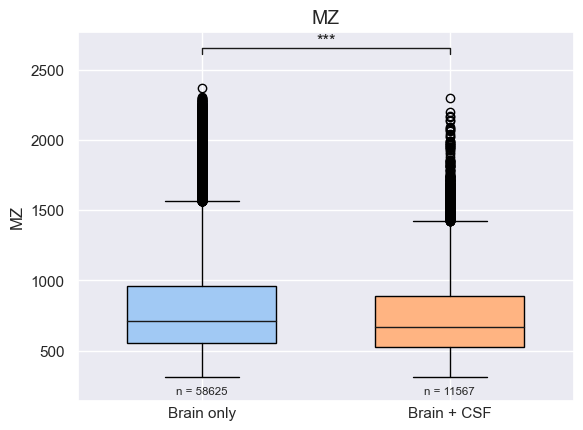

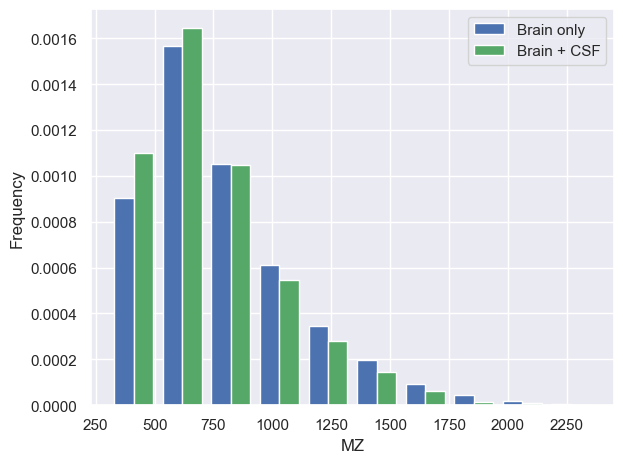

<AxesSubplot:xlabel='MZ', ylabel='Density'>

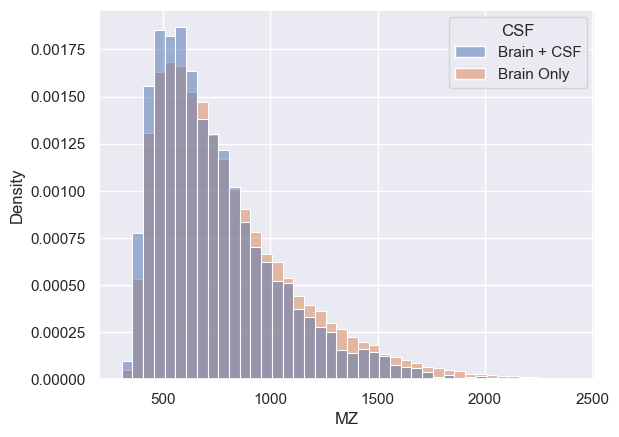

In [50]:
colors=['b','g']
data =[featuredata['MZ'].get_group('Brain Only'), featuredata['MZ'].get_group('Brain + CSF')]
title = 'MZ'
ylabel = r'MZ'
xticklabels = ['Brain only', 'Brain + CSF']
box_and_whisker(data, title, ylabel, xticklabels)
#sets up the axis and gets histogram data
fig, ax1 = plt.subplots()
ax1.hist([featuredata['MZ'].get_group('Brain Only'), featuredata['MZ'].get_group('Brain + CSF')], density=True,color=colors)
#finishes the plot
ax1.set_ylabel("Frequency")
ax1.set_xlabel("MZ")
ax1.legend(['Brain only','Brain + CSF'])
plt.tight_layout()
plt.show()

sns.histplot(data=strict,x='MZ',binwidth=50,hue='CSF',stat = 'density',common_norm = False)

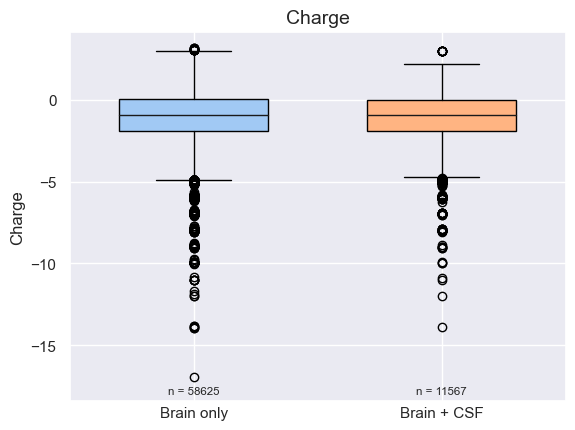

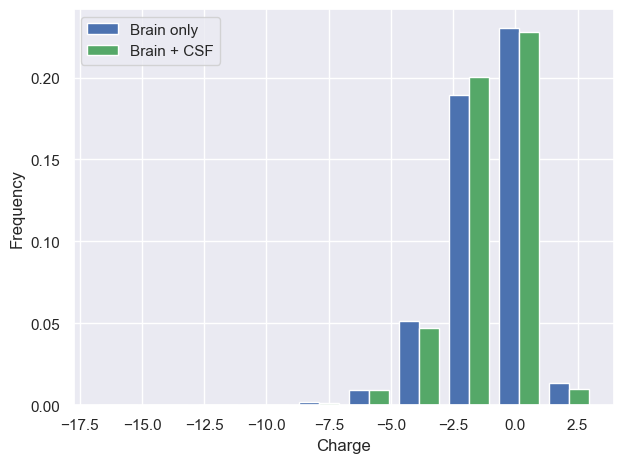

In [51]:
data =[featuredata['Charge'].get_group('Brain Only'), featuredata['Charge'].get_group('Brain + CSF')]
title = 'Charge'
ylabel = r'Charge'
xticklabels = ['Brain only', 'Brain + CSF']
box_and_whisker(data, title, ylabel, xticklabels)
#sets up the axis and gets histogram data
fig, ax1 = plt.subplots()
ax1.hist([featuredata['Charge'].get_group('Brain Only'), featuredata['Charge'].get_group('Brain + CSF')], density=True,color=colors)
#finishes the plot
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Charge")
ax1.legend(['Brain only','Brain + CSF'])
plt.tight_layout()
plt.show()

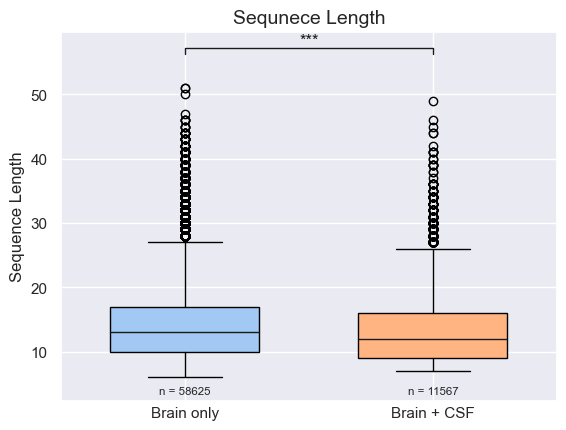

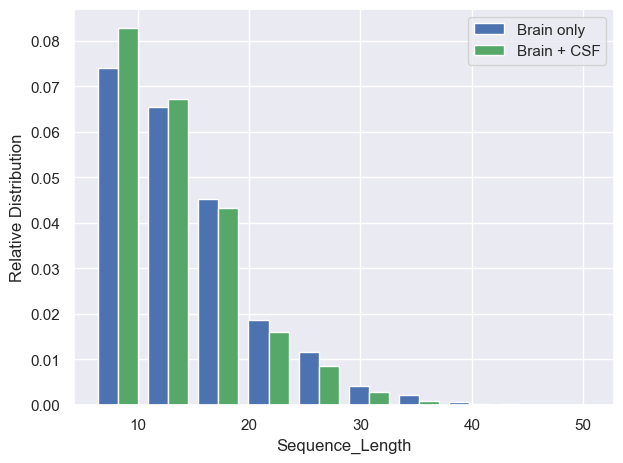

In [52]:
data =[featuredata['Sequence_Length'].get_group('Brain Only'), featuredata['Sequence_Length'].get_group('Brain + CSF')]
title = 'Sequnece Length'
ylabel = r'Sequence Length'
xticklabels = ['Brain only', 'Brain + CSF']
box_and_whisker(data, title, ylabel, xticklabels)
fig, ax1 = plt.subplots()
ax1.hist([featuredata['Sequence_Length'].get_group('Brain Only'), featuredata['Sequence_Length'].get_group('Brain + CSF')], density=True,color=colors)
#finishes the plot
ax1.set_ylabel("Relative Distribution")
ax1.set_xlabel("Sequence_Length")
ax1.legend(['Brain only','Brain + CSF'])
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Hydrophobicity', ylabel='Density'>

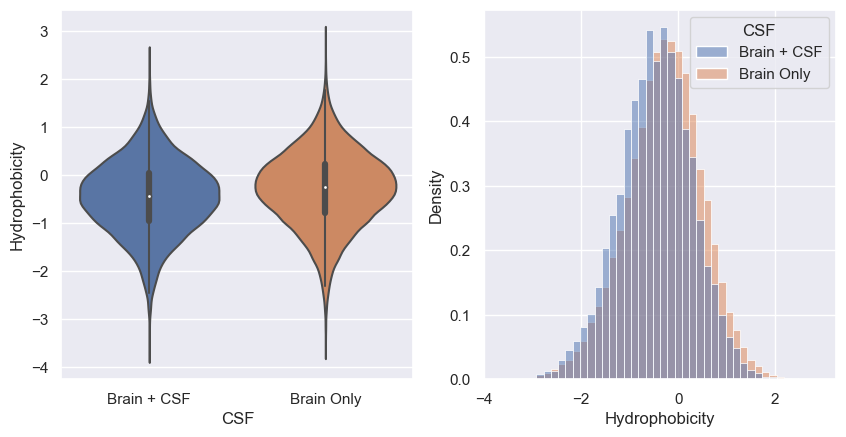

In [53]:
fig, ax =plt.subplots(1,2)
fig.set_figwidth(10)
sns.violinplot(data=strict, x="CSF", y="Hydrophobicity", ax=ax[0])
sns.histplot(data=strict,x='Hydrophobicity',binwidth=0.15,hue='CSF',stat = 'density',common_norm = False, ax=ax[1])

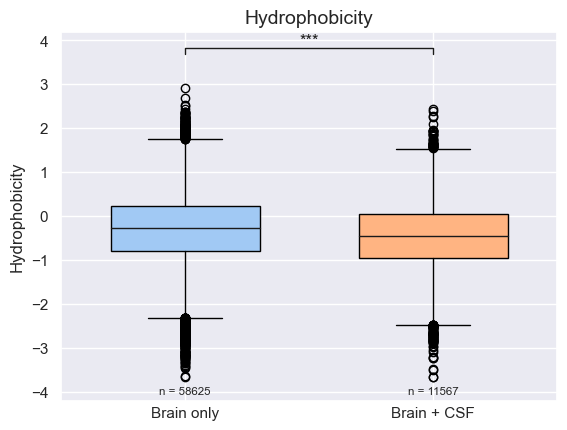

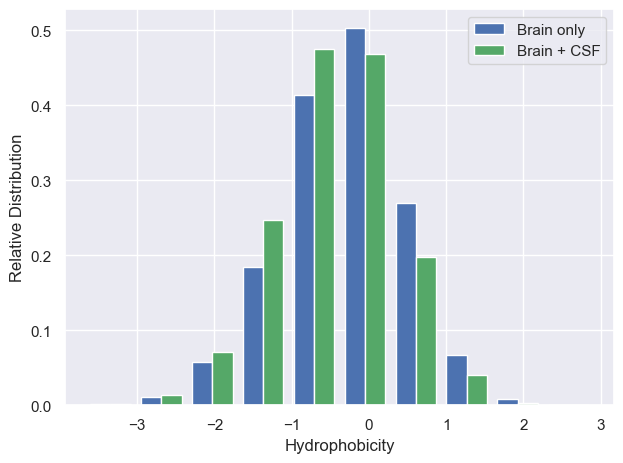

In [54]:
data =[featuredata['Hydrophobicity'].get_group('Brain Only'), featuredata['Hydrophobicity'].get_group('Brain + CSF')]
title = 'Hydrophobicity'
ylabel = r'Hydrophobicity'
xticklabels = ['Brain only', 'Brain + CSF']
box_and_whisker(data, title, ylabel, xticklabels)
fig, ax1 = plt.subplots()
ax1.hist([featuredata['Hydrophobicity'].get_group('Brain Only'), featuredata['Hydrophobicity'].get_group('Brain + CSF')], density=True,color=colors)
#finishes the plot
ax1.set_ylabel("Relative Distribution")
ax1.set_xlabel("Hydrophobicity")
ax1.legend(['Brain only','Brain + CSF'])
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Hydrophobic_Moment', ylabel='Density'>

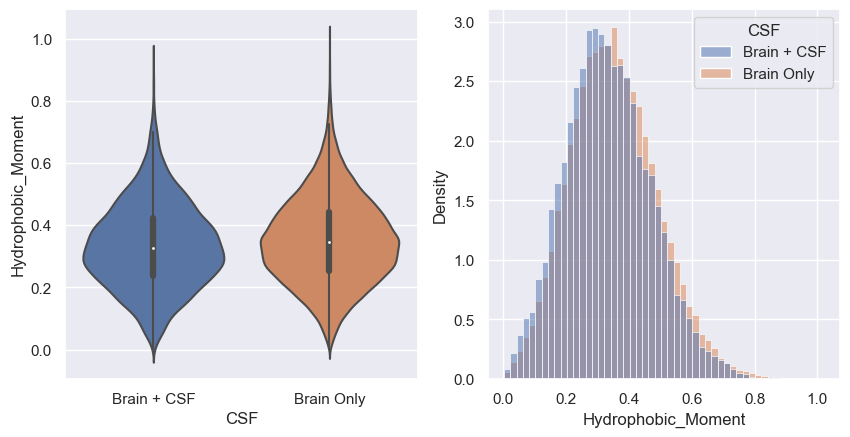

In [55]:
fig, ax =plt.subplots(1,2)
fig.set_figwidth(10)
sns.violinplot(data=strict, x="CSF", y='Hydrophobic_Moment', ax=ax[0])
sns.histplot(data=strict,x='Hydrophobic_Moment',binwidth=0.02,hue='CSF',stat = 'density',common_norm = False, ax=ax[1])

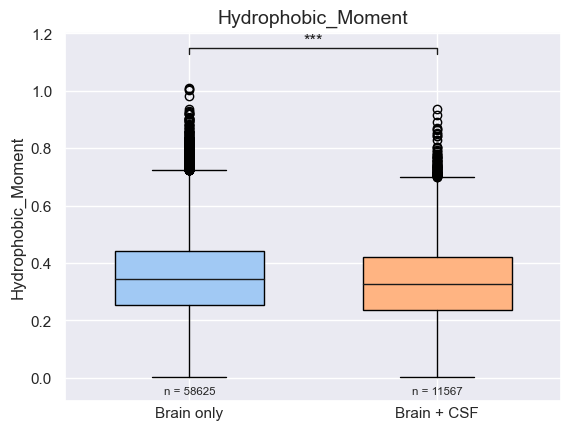

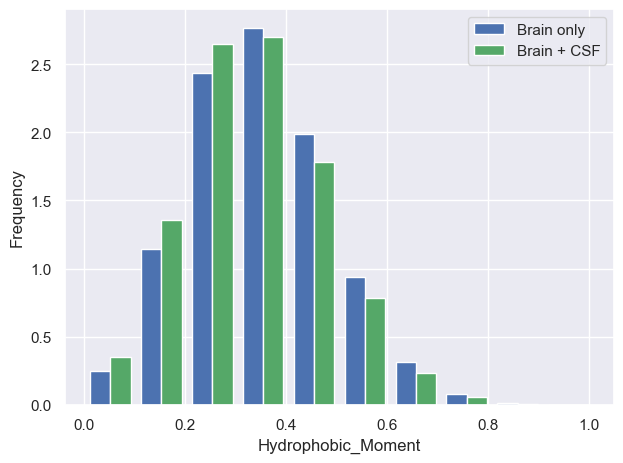

In [56]:
data =[featuredata['Hydrophobic_Moment'].get_group('Brain Only'), featuredata['Hydrophobic_Moment'].get_group('Brain + CSF')]
title = 'Hydrophobic_Moment'
ylabel = r'Hydrophobic_Moment'
xticklabels = ['Brain only', 'Brain + CSF']
box_and_whisker(data, title, ylabel, xticklabels)
fig, ax1 = plt.subplots()
ax1.hist([featuredata['Hydrophobic_Moment'].get_group('Brain Only'), featuredata['Hydrophobic_Moment'].get_group('Brain + CSF')], density=True,color=colors)
#finishes the plot
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Hydrophobic_Moment")
ax1.legend(['Brain only','Brain + CSF'])
plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Instability', ylabel='Density'>

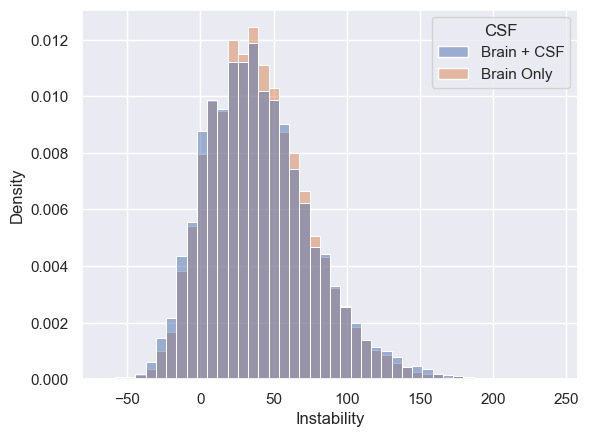

In [57]:
sns.histplot(data=strict,x='Instability',binwidth=7,hue='CSF',stat = 'density',common_norm = False)

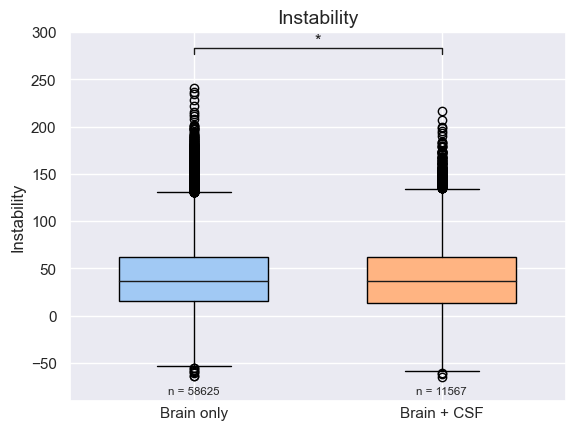

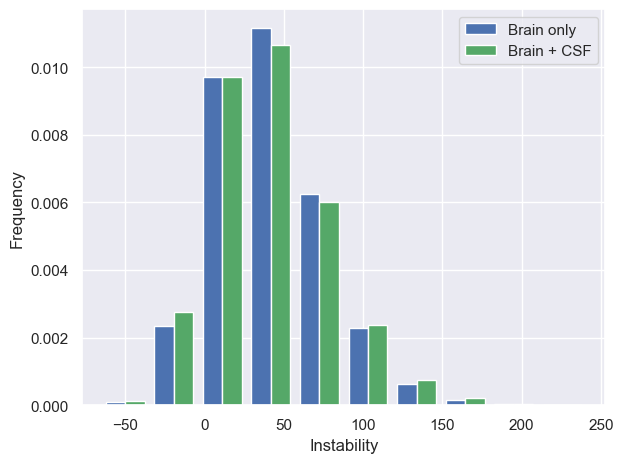

In [58]:
data =[featuredata['Instability'].get_group('Brain Only'), featuredata['Instability'].get_group('Brain + CSF')]
title = 'Instability'
ylabel = r'Instability'
xticklabels = ['Brain only', 'Brain + CSF']
box_and_whisker(data, title, ylabel, xticklabels)
fig, ax1 = plt.subplots()
ax1.hist([featuredata['Instability'].get_group('Brain Only'), featuredata['Instability'].get_group('Brain + CSF')], density=True,color=colors)
#finishes the plot
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Instability")
ax1.legend(['Brain only','Brain + CSF'])
plt.tight_layout()
plt.show()

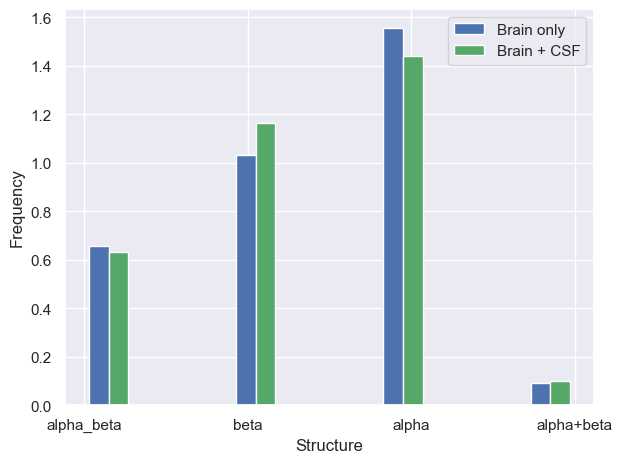

In [59]:
fig, ax1 = plt.subplots()
ax1.hist([featuredata['Structure'].get_group('Brain Only'), featuredata['Structure'].get_group('Brain + CSF')], density=True,color=colors)
#finishes the plot
ax1.set_ylabel("Frequency")
ax1.set_xlabel("Structure")
ax1.legend(['Brain only','Brain + CSF'])
plt.tight_layout()
plt.show()

#### Visualize protein sequence based features

0       1212
1       1431
2        136
3       1338
4        427
        ... 
5365     427
5366    1007
5367     450
5368     430
5369    1530
Length: 5370, dtype: int64
False    3499
True     1871
Name: index, dtype: int64
      index     0
0      True  1212
1      True  1431
2      True   136
3      True  1338
4      True   427
...     ...   ...
5365  False   427
5366   True  1007
5367   True   450
5368  False   430
5369  False  1530

[5370 rows x 2 columns]


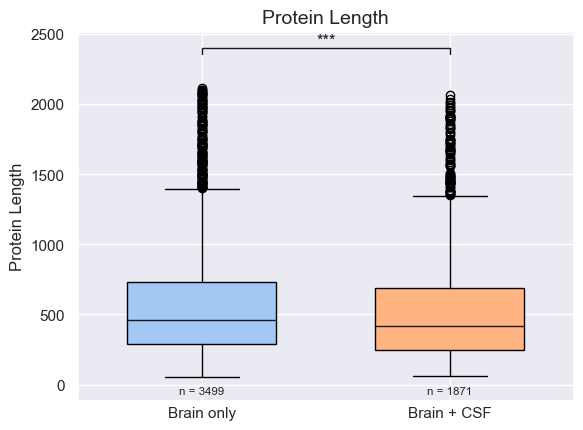

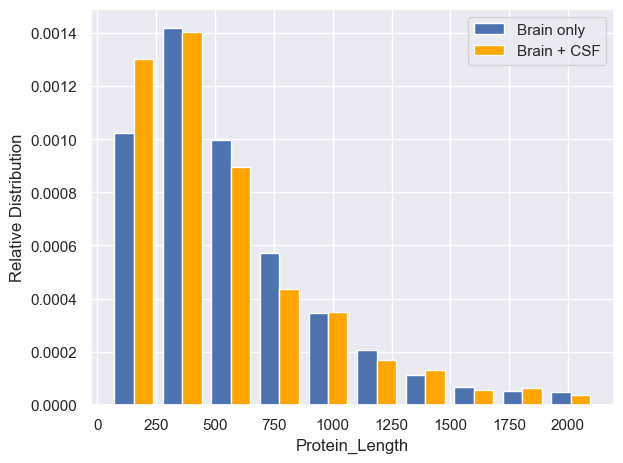

In [60]:
# compare hist length protein vs length peptides
def checker(x):
    for pep in x['CSF']:
        if pep == 'Brain + CSF':
            return True
    return False
csflist = []
proteinseq = pd.Series(strict['Protein_Sequence'].unique())
temp = strict.groupby(['Protein_Sequence'])
for x in proteinseq:
    csflist.append(checker(temp.get_group(x)))
pro = proteinseq.apply(lambda x: len(x))
print(pro)
proAAF = pd.DataFrame(list(pro),csflist)
proAAF.reset_index(inplace=True)
print(proAAF['index'].value_counts())
print(proAAF)
groupdata = proAAF.groupby(['index'])
data =[groupdata[0].get_group(False), groupdata[0].get_group(True)]
title = 'Protein Length'
ylabel = r'Protein Length'
xticklabels = ['Brain only', 'Brain + CSF']
#box_and_whisker(data, title, ylabel, xticklabels)
box_and_whisker(data, title, ylabel, xticklabels)
fig, ax1 = plt.subplots()
ax1.hist([groupdata[0].get_group(False), groupdata[0].get_group(True)], density=True,color=['b','orange'])
#finishes the plot
ax1.set_ylabel("Relative Distribution")
ax1.set_xlabel("Protein_Length")
ax1.legend(['Brain only','Brain + CSF'])
plt.tight_layout()
plt.show()
#fig.show()

In [61]:
positive = sum(proAAF['index'] == True)
print('Of the',len(proAAF),'csf peptides,',positive,'were found in the brain')
print('This means ',round((positive)/len(proAAF)*100),'% of the csfpeptides also occur in the brain')
# Higgenbotham found 67% of csf proteins also detected in brain
print('In the strictdf the positive classification is',round(positive/len(proAAF)*100),'% of the total')

Of the 5370 csf peptides, 1871 were found in the brain
This means  35 % of the csfpeptides also occur in the brain
In the strictdf the positive classification is 35 % of the total


#### Counts number of brain peptides cut correctly: 84% are cut correctly according to trypsin cutting sites

In [62]:
# make sure this number is correct
def inpeptide(x):
    if 'K' in x['Peptide_Sequence'][1:-1]:
        return None
    if 'R' in x['Peptide_Sequence'][1:-1]:
        return None
    return x
cutted = strict.apply(lambda x: inpeptide(x),axis=1)
cutted.dropna(inplace=True)
len(cutted)/len(strict)*100

84.48256211534077

#### Counts number of brain peptides also found in CSF per author

In [63]:
# check author information -> percentage positive negative of brain df
classi = strict.groupby(['CSF'])

authorspositive = []
authorsnegative = []
for row in strict.iterrows():
    if row[1]['CSF'] == 'Brain + CSF':
        for w in row[1]['Author'].split():
            authorspositive.append(re.sub(",", "", w))
    else:
        for w in row[1]['Author'].split():
            authorsnegative.append(re.sub(",", "", w))
# print(len(authorspositive))
# print(authorsnegative)
counts = Counter(authorspositive)
print('Positive:',counts)
counts = Counter(authorsnegative)
print('Negative:',counts)

Positive: Counter({'Rydbirk': 10918, 'Faigle': 9402, 'Duong': 9288})
Negative: Counter({'Rydbirk': 50421, 'Duong': 47489, 'Faigle': 46543})


#### Counts number of CSF brain peptides cut correctly: 75% are cut according to trypsin cutting sites

In [64]:
def inpeptide(x):
    if 'K' in x['Peptide_Sequence'][:-1]:
        return None
    if 'R' in x['Peptide_Sequence'][:-1]:
        return None
    return x
cuttedcsf = csfdf.apply(lambda x: inpeptide(x),axis=1)
cuttedcsf.dropna(inplace=True)
cuttedcsf
len(cuttedcsf)/len(csfdf)*100

75.16574823488892

#### Checks uniqueness and number of peptides and proteins from diffrent datasets and labels

In [65]:
print('length strict',len(strict))
print('duplicates strict',len(strict[strict['Peptide_Sequence'].duplicated()]))
print('unique strict peptides',len(strict['Peptide_Sequence'].unique()))
print('unique strict proteins',len(strict['Protein'].unique()))
print('length csf',len(csfdf))
print('duplicates csf',len(csfdf[csfdf['Peptide_Sequence'].duplicated()]))
print('unique csf peptides',len(csfdf['Peptide_Sequence'].unique()))
print('unique csf proteins',len(csfdf['Protein'].unique()))
classitrue = strict[strict['CSF'] == 'Brain + CSF']
print('orignial length strict CSF == TRUE', len(classitrue))
print('duplicates strict CSF == TRUE',len(classitrue[classitrue['Peptide_Sequence'].duplicated()]))
print('unique strict peptides CSF == TRUE',len(classitrue['Peptide_Sequence'].unique()))
print('unique strict proteins CSF == TRUE',len(classitrue['Protein'].unique()))
classif = strict[strict['CSF'] == 'Brain Only']
print('orignial length strict CSF == F', len(classif))
print('duplicates strict CSF == F',len(classif[classif['Peptide_Sequence'].duplicated()]))
print('unique strict peptides CSF == F',len(classif['Peptide_Sequence'].unique()))
print('unique strict proteins CSF == F',len(classif['Protein'].unique()))


length strict 70192
duplicates strict 0
unique strict peptides 70192
unique strict proteins 5370
length csf 46456
duplicates csf 2314
unique csf peptides 44142
unique csf proteins 4276
orignial length strict CSF == TRUE 11567
duplicates strict CSF == TRUE 0
unique strict peptides CSF == TRUE 11567
unique strict proteins CSF == TRUE 1871
orignial length strict CSF == F 58625
duplicates strict CSF == F 0
unique strict peptides CSF == F 58625
unique strict proteins CSF == F 5143


#### Removes annotated feature data from proteins not in dataset

In [66]:
proteinsum = proteinsummaries[proteinsummaries['Protein'].isin(strict['Protein'].unique())]
proteinsum['Isoforms'].value_counts().sum()
proteinsum['Isoforms'].fillna(0,inplace=True)
proteinsum

Protein  Function  Subunit  Domain  Interaction  Subcellular_Location  \
0     P31946       1.0      3.0     NaN         43.0                   2.0   
1     P62258       1.0      2.0     NaN         36.0                   1.0   
2     Q04917       1.0      1.0     NaN         32.0                   NaN   
3     P61981       1.0      1.0     NaN        144.0                   1.0   
4     P27348       1.0      1.0     NaN         26.0                   1.0   
...      ...       ...      ...     ...          ...                   ...   
5365  Q9BUW7       1.0      NaN     NaN         11.0                   1.0   
5366  P0CG08       1.0      1.0     NaN          1.0                   1.0   
5367  P22792       1.0      1.0     NaN          NaN                   1.0   
5368  Q16585       1.0      1.0     NaN         16.0                   1.0   
5369  P00739       1.0      NaN     1.0          NaN                   1.0   

      Isoforms  PTM  Similarity  Miscellaneous  ...  Pathway  \
0          2.0  1.0         1.0            NaN  ...      NaN   
1          2.0  NaN         1.0            1.0  ...      NaN   
2          0.0  1.0         1.0            NaN  ...      NaN   
3          0.0  1.0         1.0            NaN  ...      NaN   
4          0.0  1.0         1.0            NaN  ...      NaN   
...        ...  ...         ...            ...  ...      ...   
5365       0.0  NaN         1.0            NaN  ...      NaN   
5366       0.0  NaN         1.0            1.0  ...      NaN   
5367       0.0  1.0         NaN            NaN  ...      NaN   
5368       2.0  1.0         1.0            NaN  ...      NaN   
5369       2.0  NaN         1.0            NaN  ...      NaN   

      Catalytic_Activity  Activity_Regulation  Biophysicohemical_Properties  \
0                    NaN                  NaN                           NaN   
1                    NaN                  NaN                           NaN   
2                    NaN                  NaN                           NaN   
3                    NaN                  NaN                           NaN   
4                    NaN                  NaN                           NaN   
...                  ...                  ...                           ...   
5365                 NaN                  NaN                           NaN   
5366                 NaN                  NaN                           NaN   
5367                 NaN                  NaN                           NaN   
5368                 NaN                  NaN                           NaN   
5369                 NaN                  NaN                           NaN   

      Induction  Mass_Spec  Developmental_Stage  Cofactor  Polymorphism  \
0           NaN        NaN                  NaN       NaN           NaN   
1           NaN        NaN                  NaN       NaN           NaN   
2           NaN        NaN                  NaN       NaN           NaN   
3           NaN        NaN                  NaN       NaN           NaN   
4           NaN        NaN                  NaN       NaN           NaN   
...         ...        ...                  ...       ...           ...   
5365        NaN        NaN                  NaN       NaN           NaN   
5366        NaN        NaN                  NaN       NaN           NaN   
5367        NaN        NaN                  NaN       NaN           NaN   
5368        NaN        NaN                  NaN       NaN           NaN   
5369        NaN        NaN                  NaN       NaN           NaN   

      Web_Resource  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN  
...            ...  
5365           NaN  
5366           NaN  
5367           NaN  
5368           1.0  
5369           NaN  

[5370 rows x 24 columns]

In [68]:
# remove na values and remove proteins not found in brain or csf -> how are they there?
proteinfeatures = proteinfeatures[proteinfeatures['Protein'].isin(strict['Protein'].unique())]
proteinfeatures.reset_index(inplace=True,drop=True)
proteinfeatures['Classification'] = proteinfeatures['Protein'].apply(lambda x: coveragedf[coveragedf['Protein']==x]['Classification'].values[0])


#### Inspecting features data for relevant features

In [69]:
proteinfeatures[proteinfeatures['Protein']=='O43272'] # end transite peptide should be 58
proteinfeatures[proteinfeatures['Protein']=='P61088']

# What is difference,  add feature
trans = proteinfeatures[proteinfeatures['Type'] == 'Transmembrane']
trans['Protein']

proteinfeatures[proteinfeatures['Type'] == 'Intramembrane']

# relevant PTM
proteinfeatures[proteinfeatures['Type'] == 'Glycosylation']

# relevant for lipidation PTMS, also saw GPI anchor in description
proteinfeatures[proteinfeatures['Type'] == 'Lipidation']

# Could be relevant -> where protein is mainly located?
proteinfeatures[proteinfeatures['Type'] == 'Topological domain']

# need to look up what active and binding site actually are
proteinfeatures[proteinfeatures['Type'] == 'Active site']
proteinfeatures[proteinfeatures['Type'] == 'Binding site']

# useful information in description of domain
proteinfeatures[proteinfeatures['Type'] == 'Domain']
proteinfeatures[proteinfeatures['Type'] == 'Region'] # contains information for GPI anchor

# could use for structural information
proteinfeatures[proteinfeatures['Type'] == 'Beta strand']
proteinfeatures[proteinfeatures['Type'] == 'Helix']
proteinfeatures[proteinfeatures['Type'] == 'Turn']

# double check not missing relevant information not used from proteindataframe
gpi = proteinfeatures.loc[(proteinfeatures['Type'] == 'Region') & (proteinfeatures['Description'].str.contains('GPI')) | (proteinfeatures['Type'] == 'Lipidation') & (proteinfeatures['Description'].str.contains('GPI'))]
gpi = gpi[gpi['Protein'].isin(strict['Protein'].unique())]
proteinfeatures.loc[(proteinfeatures['Type'] == 'Domain') & (proteinfeatures['Description'].str.contains('PTM'))]
test = proteinfeatures.loc[(proteinfeatures['Type'] == 'Intramembrane')]
anchor = proteinfeatures.loc[(proteinfeatures['Description'].str.contains('anchor'))|proteinfeatures['Description'].str.contains('Anchor')]

In [70]:
print(proteinfeatures['Type'].unique())
signal = proteinfeatures.loc[(proteinfeatures['Type'] == 'Glycosylation') |(proteinfeatures['Type'] == 'Lipidation') |(proteinfeatures['Type'] == 'Transmembrane') |(proteinfeatures['Type'] == 'Intramembrane') |(proteinfeatures['Type'] == 'Signal') | (proteinfeatures['Type'] == 'Domain')| (proteinfeatures['Type'] == 'Transit peptide')]

['Chain' 'Initiator methionine' 'Site' 'Modified residue' 'Cross-link'
 'Alternative sequence' 'Natural variant' 'Helix' 'Turn' 'Region'
 'Compositional bias' 'Sequence conflict' 'Mutagenesis' 'Repeat'
 'Beta strand' 'Transit peptide' 'Active site' 'Binding site'
 'Topological domain' 'Transmembrane' 'Disulfide bond' 'Signal' 'Peptide'
 'Domain' 'Motif' 'Coiled coil' 'Propeptide' 'Intramembrane' 'Lipidation'
 'Zinc finger' 'Non-standard residue' 'DNA binding' 'Non-terminal residue']


In [71]:
signal[signal.isnull().any(axis=1)]
proteinfeatures[proteinfeatures['Type']=='Disulfide bond']

Protein            Type  \
367     P08195  Disulfide bond   
525     P01023  Disulfide bond   
526     P01023  Disulfide bond   
527     P01023  Disulfide bond   
528     P01023  Disulfide bond   
...        ...             ...   
226062  O95185  Disulfide bond   
226230  Q16585  Disulfide bond   
226231  Q16585  Disulfide bond   
226250  P00739  Disulfide bond   
226251  P00739  Disulfide bond   

                                              Description  Start  End  \
367     Interchain (with C-164 in SLC7A5 and C-158 in ...    209  209   
525                                        Disulfide bond     47   85   
526                                        Disulfide bond    250  298   
527                                        Disulfide bond    268  286   
528                               Interchain (with C-431)    277  277   
...                                                   ...    ...  ...   
226062                                     Disulfide bond    339  351   
226230                                     Disulfide bond    287  313   
226231                                     Disulfide bond    289  306   
226250                                     Disulfide bond    250  281   
226251                                     Disulfide bond    292  322   

       Classification  
367             Mixed  
525             Mixed  
526             Mixed  
527             Mixed  
528             Mixed  
...               ...  
226062          Mixed  
226230       Negative  
226231       Negative  
226250       Negative  
226251       Negative  

[3166 rows x 6 columns]

In [72]:
signal['Type'].unique()
signal[signal['Protein']=='Q8WXD9']
signal.loc[signal['Type'] == 'Transit peptide', 'Description'] = "Transit peptide"
signal.loc[signal['Type'] == 'Signal', 'Description'] = "Signal peptide"
signal.loc[signal['Type'] == 'Glycosylation', 'Description'] = "Glycosylation"
signal.drop(signal[(signal['Type'] == 'Domain') & (~signal['Description'].str.contains('terminal'))].index,inplace=True)
signal[signal['Protein'] == 'A0A0C4DH38']
signal

/var/folders/zx/9wq85h090yj8pmk6sbvl93n80000gn/T/ipykernel_1814/1196526190.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  signal.drop(signal[(signal['Type'] == 'Domain') & (~signal['Description'].str.contains('terminal'))].index,inplace=True)


Protein             Type  \
292     P31937  Transit peptide   
350     P08195    Transmembrane   
511     P01023           Signal   
576     P05067           Signal   
593     P05067    Transmembrane   
...        ...              ...   
355232  P60866       Lipidation   
355233  Q9NP58       Lipidation   
355234  P01023       Lipidation   
355235  Q15637       Lipidation   
355236  P16144       Lipidation   

                                              Description  Start  End  \
292                                       Transit peptide      0   35   
350     Helical; Signal-anchor for type II membrane pr...    184  204   
511                                        Signal peptide      0   22   
576                                        Signal peptide      0   16   
593                                               Helical    701  721   
...                                                   ...    ...  ...   
355232                                     Palmitoylation     70   70   
355233                                     Palmitoylation     50   50   
355234                                     Palmitoylation    431  431   
355235                                     Palmitoylation    282  282   
355236                                     Palmitoylation    742  742   

       Classification  
292             Mixed  
350             Mixed  
511             Mixed  
576             Mixed  
593             Mixed  
...               ...  
355232          Mixed  
355233       Negative  
355234          Mixed  
355235          Mixed  
355236          Mixed  

[6214 rows x 6 columns]

#### Counts of features in different groups

In [73]:
onemismatch = transitiondf[transitiondf['Positive']>1]
onemismatch = onemismatch[onemismatch['Negative']>1]
onemismatch = onemismatch[onemismatch['Transitions']==1]
print(len(onemismatch))
strict[strict['Protein']=='P35052']
print('Disulfide',proteinfeatures[proteinfeatures['Description']=='Disulfide bond']['Classification'].value_counts())
print('Beta',proteinfeatures[proteinfeatures['Description']=='Beta strand']['Classification'].value_counts())
print('Helix',proteinfeatures[proteinfeatures['Description']=='Helix']['Classification'].value_counts())
print('Binding',proteinfeatures[proteinfeatures['Description']=='Binding site']['Classification'].value_counts())
print('Disordered',proteinfeatures[proteinfeatures['Description']=='Disordered']['Classification'].value_counts())
print('Turn',proteinfeatures[proteinfeatures['Description']=='Turn']['Classification'].value_counts())
print('Polar',proteinfeatures[proteinfeatures['Description']=='Polar residues']['Classification'].value_counts())
print('Helical',proteinfeatures[proteinfeatures['Description']=='Helical']['Classification'].value_counts())
print('Basic',proteinfeatures[proteinfeatures['Description']=='Basic and acidic residues']['Classification'].value_counts())
print('Cytoplasmic',proteinfeatures[proteinfeatures['Description']=='Cytoplasmic']['Classification'].value_counts())
print('Extracellular',proteinfeatures[proteinfeatures['Description']=='Extracellular']['Classification'].value_counts())
print('Coiled',proteinfeatures[proteinfeatures['Description']=='Coiled coil']['Classification'].value_counts())
print('Initiator Methione',proteinfeatures[proteinfeatures['Type']=='Initiator methionine']['Classification'].value_counts())
print('Initiator Methione',proteinfeatures[proteinfeatures['Type']=='Binding site']['Classification'].value_counts())

82
Disulfide Mixed       1639
Positive     826
Negative     446
Name: Classification, dtype: int64
Beta Negative    19919
Mixed       13888
Positive     2313
Name: Classification, dtype: int64
Helix Negative    22835
Mixed       11633
Positive     1105
Name: Classification, dtype: int64
Binding Negative    6303
Mixed       3157
Positive     258
Name: Classification, dtype: int64
Disordered Negative    4193
Mixed       1909
Positive     152
Name: Classification, dtype: int64
Turn Negative    5448
Mixed       3137
Positive     419
Name: Classification, dtype: int64
Polar Negative    1954
Mixed        932
Positive      55
Name: Classification, dtype: int64
Helical Negative    1890
Mixed        649
Positive      49
Name: Classification, dtype: int64
Basic Negative    1451
Mixed        817
Positive      61
Name: Classification, dtype: int64
Cytoplasmic Negative    1025
Mixed        568
Positive      45
Name: Classification, dtype: int64
Extracellular Negative    552
Mixed       413
Positive

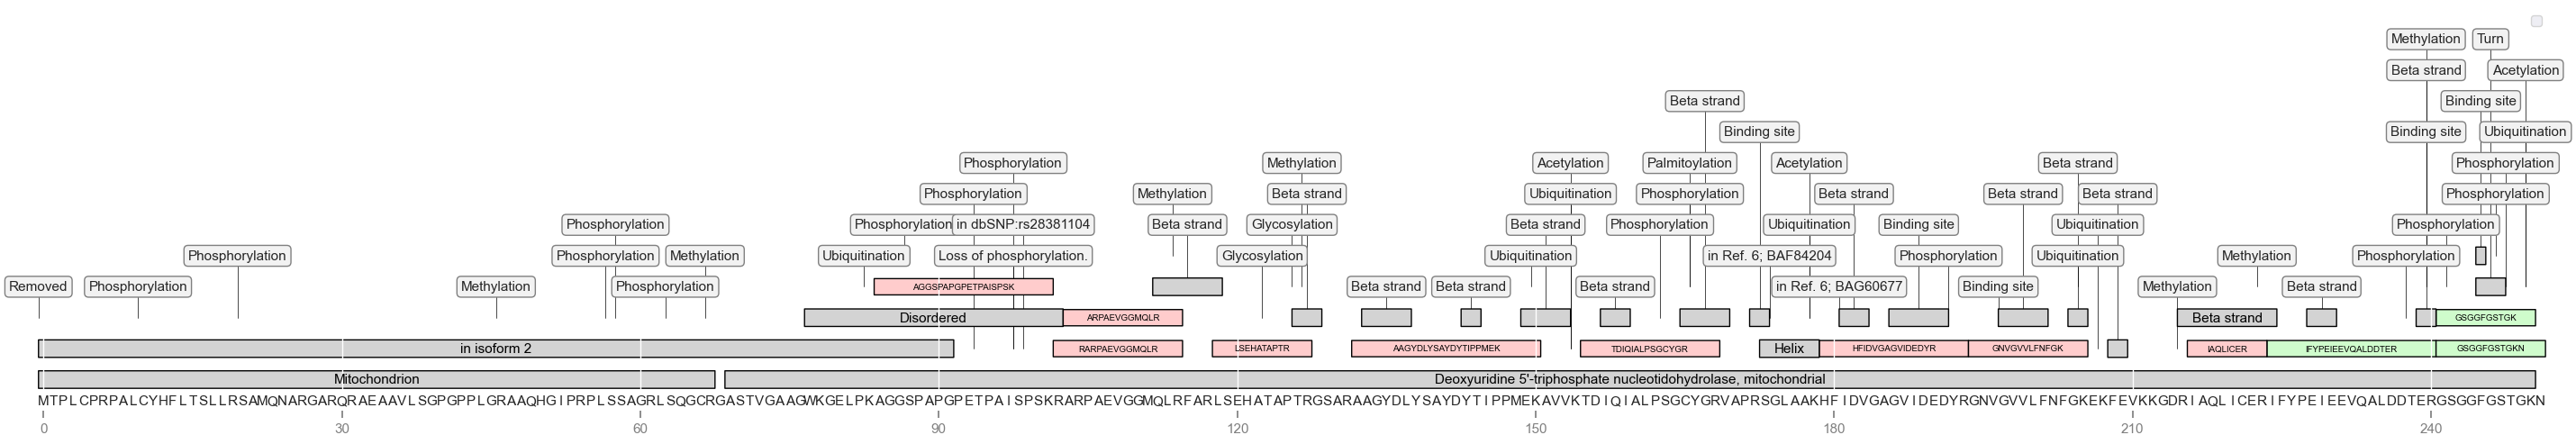

In [74]:
# Q06418, Q16620, P54764, Q96FE5, Q9ULF5 shows importance glycolysation and transmembrane domain
# Most plots contain either all red or all green. Most of the plots with both red and green, are mixed. 
# Protein Accession: P02792 -> has overlapping peptides which are classified differntly -> due to different cutting locations
# P20618 best plot found -> one side red and other side green
# looking at percentage of 'R' and 'K' not at the end of the peptide sequences -> 75% of braindf peptides have 'R' or 'K' in
# in sequence, but only 25 % of CSFdf sequences do

# improve visibility of PTM's
# P26641,Q15293,P55011  looks interestingv
legend_elements = [Patch(facecolor='#cffccc', edgecolor='k',label='Brain and CSF'),
                   Patch(facecolor='#ffcccc', edgecolor='k',label='Only Brain'),
                  Patch(facecolor='#ffd700', edgecolor='k',label='PTMs'),
                  Patch(facecolor='lightgray', edgecolor='k',label='Domains')]
sample = strict['Protein'].unique()
for protein in ['P33316']:
    legend_elements = []
    temp = strict[strict['Protein']==protein]
    featureslist = []
    for t in temp.iterrows():
        if t[1]['CSF'] == 'Brain + CSF':
            c = "#cffccc"
        else: c = "#ffcccc"
        featureslist.append( GraphicFeature(start=t[1]["Position_in_Protein"], end=t[1]["Position_in_Protein"]+len(t[1]['Peptide_Sequence']), strand=0, color=c,
                       label=t[1]['Peptide_Sequence'],legend_text='True',linewidth=1,thickness=13,box_linewidth=0,fontdict={'fontsize': 7}))
    for n,s in proteinfeatures[proteinfeatures['Protein']==protein].iterrows():
        featureslist.append(GraphicFeature(start=int(s['Start']), end=int(s['End']),strand=0, color="lightgray", label=f"{s['Description']}"))
    record = GraphicRecord(sequence_length = len(temp['Protein_Sequence'].values[0]),
                           sequence=temp['Protein_Sequence'].values[0],features=featureslist, 
                            plots_indexing='biopython', labels_spacing=1, ticks_resolution='auto')
    ax1, _ = record.plot(figure_width=len(temp['Protein_Sequence'].values[0])/7,annotate_inline=True,level_offset=0,draw_line=False,plot_sequence=True)
    plt.legend(handles=legend_elements, loc='upper right')
    ax1.figure.savefig('sequence_and_translation.png', bbox_inches='tight')
    plt.show()

#### Annotated features count in protein feature data

5370
0
Modified residue        157807
Beta strand              36120
Helix                    35573
Natural variant          23246
Sequence conflict        11245
Mutagenesis              10754
Binding site              9988
Region                    9564
Turn                      9004
Alternative sequence      8898
Compositional bias        6428
Chain                     5676
Domain                    5499
Repeat                    4428
Transmembrane             3579
Topological domain        3281
Disulfide bond            3166
Cross-link                2096
Active site               1310
Lipidation                1263
Initiator methionine      1235
Site                      1142
Motif                     1086
Coiled coil                886
Signal                     700
Transit peptide            385
Zinc finger                330
Propeptide                 237
Peptide                    124
Intramembrane              120
DNA binding                 47
Non-standard residue        10
N

Protein
A6NCS6    3
F5H5P2    3
Q96EX1    3
Q96F85    3
dtype: int64

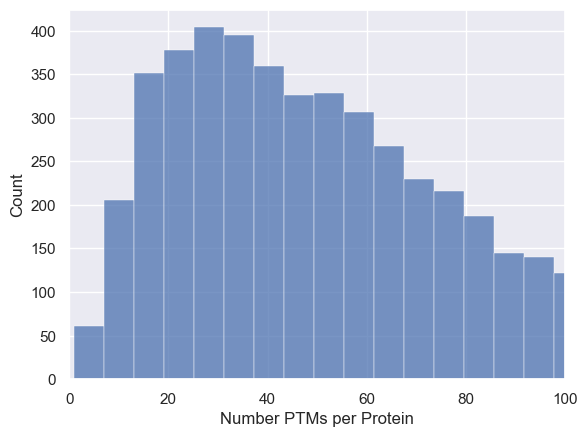

In [75]:
print(len(proteinfeatures['Protein'].unique()))
protein_ptms = proteinfeatures.groupby("Protein").size()
print(len(protein_ptms[protein_ptms==0]))
sns.histplot(data=protein_ptms,bins=105)
plt.xlabel('Number PTMs per Protein')
plt.xlim(0,100)
print(proteinfeatures['Type'].value_counts())
protein_ptms[protein_ptms==3]

In [76]:
# add cleaned residues to ptmclean
residues = proteinfeatures[proteinfeatures['Start']==proteinfeatures['End']]
print(residues['Type'].unique())
residues[residues['Type']=='Initiator methionine']
residues[residues['Type']=='Site']
residues[residues['Type']=='Modified residue'] # use this, atleats the modifications we already have
residues[residues['Type']=='Cross-link']
residues[residues['Type']=='Disulfide bond']
residues[residues['Type']=='Active site']
residues[residues['Type']=='Binding site'] # potentially usefull information?
residues[residues['Type']=='Glycosylation'] # use this

glycosylation = proteinfeatures[proteinfeatures['Description']=='Phosphorylation']
glycosylation

['Initiator methionine' 'Site' 'Modified residue' 'Cross-link'
 'Natural variant' 'Sequence conflict' 'Mutagenesis' 'Active site'
 'Binding site' 'Disulfide bond' 'Alternative sequence' 'Lipidation'
 'Topological domain' 'Region' 'Transit peptide' 'Chain'
 'Non-standard residue' 'Non-terminal residue' 'Propeptide' 'Signal']


Protein              Type      Description  Start  End Classification
7       P31946  Modified residue  Phosphorylation      1    1          Mixed
10      P31946  Modified residue  Phosphorylation     59   59          Mixed
15      P31946  Modified residue  Phosphorylation    185  185          Mixed
16      P31946  Modified residue  Phosphorylation    231  231          Mixed
41      P62258  Modified residue  Phosphorylation     64   64          Mixed
...        ...               ...              ...    ...  ...            ...
312256  Q15942  Modified residue  Phosphorylation    312  312          Mixed
312257  Q15942  Modified residue  Phosphorylation    314  314          Mixed
312258  Q15942  Modified residue  Phosphorylation    315  315          Mixed
312259  Q15942  Modified residue  Phosphorylation    351  351          Mixed
312260  Q15942  Modified residue  Phosphorylation    504  504          Mixed

[87614 rows x 6 columns]

#### PTM plots

Acetylation
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Negative v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.635e-36 stat=1.605e+02
Positive v.s. Negative: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.071e-09 stat=3.805e+01
Positive v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=8.235e-22 stat=9.428e+01


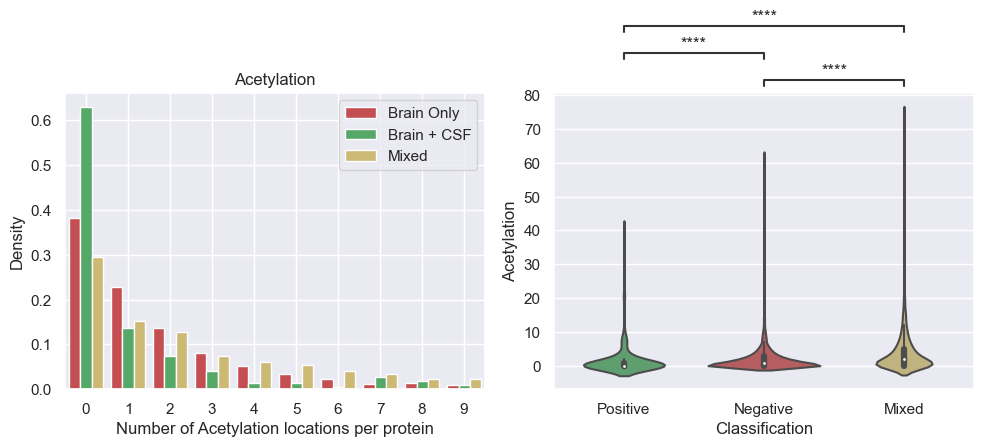

Methylation
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Negative v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.090e-19 stat=8.461e+01
Positive v.s. Negative: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.957e-15 stat=6.388e+01
Positive v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=7.622e-26 stat=1.127e+02


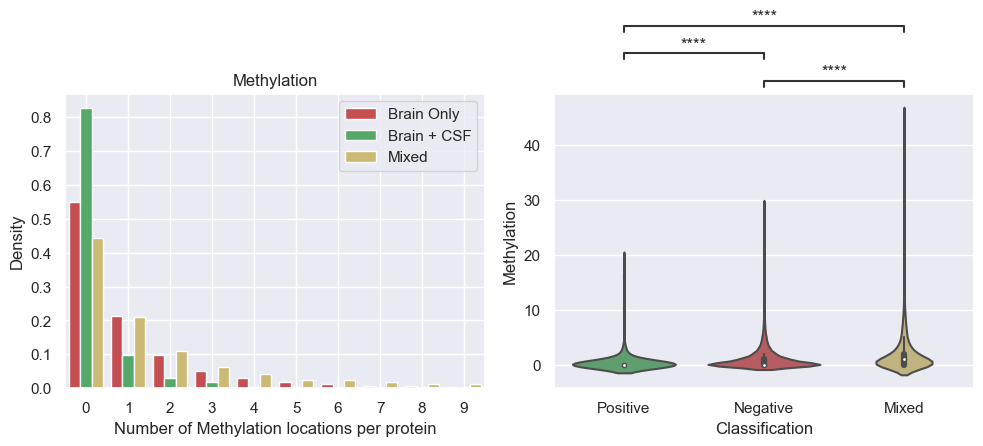

Glycosylation
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Negative v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.097e-90 stat=4.087e+02
Positive v.s. Negative: Kruskal-Wallis paired samples with Bonferroni correction, P_val=4.077e-203 stat=9.270e+02
Positive v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.015e-40 stat=1.794e+02


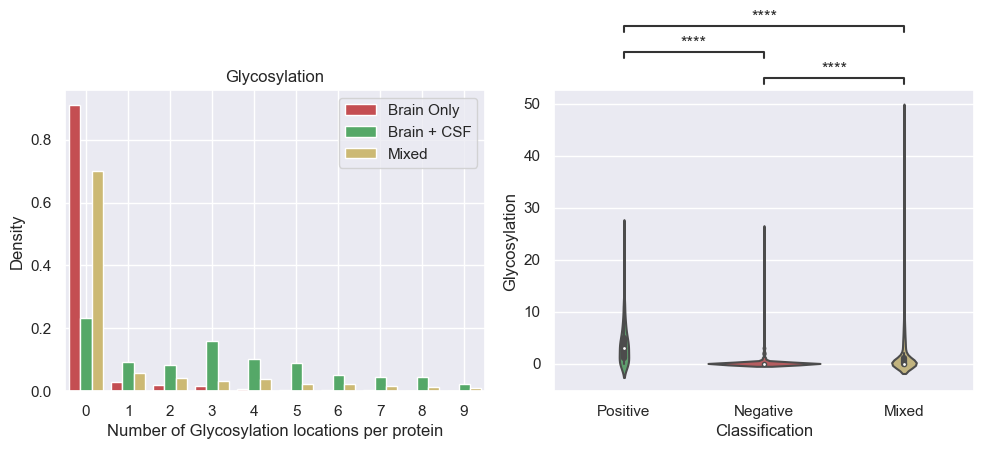

Phosphorylation
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Negative v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=2.335e-14 stat=6.039e+01
Positive v.s. Negative: Kruskal-Wallis paired samples with Bonferroni correction, P_val=3.691e-12 stat=5.044e+01
Positive v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.500e-23 stat=1.022e+02


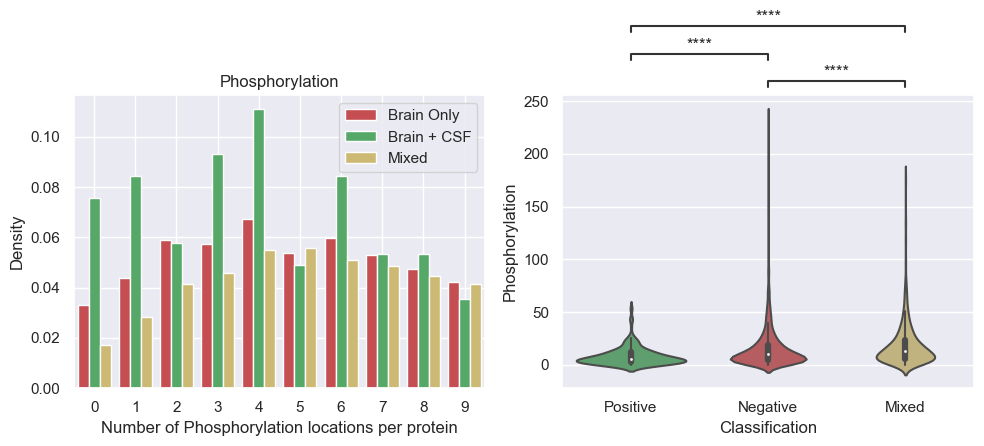

Ubiquitination
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Negative v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.197e-02 stat=8.289e+00
Positive v.s. Negative: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.460e-42 stat=1.892e+02
Positive v.s. Mixed: Kruskal-Wallis paired samples with Bonferroni correction, P_val=1.140e-38 stat=1.713e+02


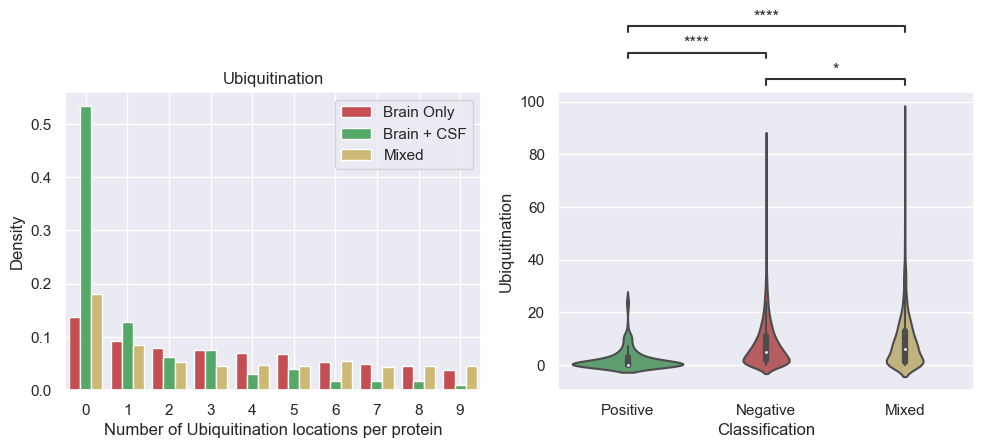

In [77]:
for ptm in ptmclean['Description'].unique():
    print(ptm)
    glycosylation = proteinfeatures[proteinfeatures['Description']==ptm]
    coveragedf[ptm] = coveragedf['Protein'].apply(lambda x: len(glycosylation[glycosylation['Protein']==x]))
    groupedcoverage = coveragedf.groupby(['Classification'])
    fig, ax1 = plt.subplots(1,2)
    fig.set_figwidth(10)
    ax1[0].hist([groupedcoverage[ptm].get_group('Negative'), groupedcoverage[ptm].get_group('Positive'),groupedcoverage[ptm].get_group('Mixed')],bins=np.arange(50) - 0.5
     ,density=True,color=['r','g','y'])
    ax1[0].set_xlim([-0.5, 9.5])
    #finishes the plot
    ax1[0].set_title(ptm)
    ax1[0].set_ylabel("Density")
    ax1[0].set_xlabel(f"Number of {ptm} locations per protein")
    ax1[0].legend(['Brain Only','Brain + CSF','Mixed'])
    ax1[0].set_xticks(np.arange(0, 10, step=1))
    ax1[1] = sns.violinplot(data=coveragedf, x="Classification", y=ptm,palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
    add_stat_annotation(ax1[1], data=coveragedf, x="Classification", y=ptm,
                        box_pairs=[("Negative", "Mixed"), ("Mixed", "Positive"), ("Negative", "Positive")],
                        test='Kruskal', text_format='star', loc='outside', verbose=3)
    plt.tight_layout()
    plt.show()

In [78]:
print(proteinfeatures[proteinfeatures['Type'] == 'Peptide'])
print(proteinfeatures[proteinfeatures['Type'] == 'Binding Site'])
print(proteinfeatures[proteinfeatures['Type'] == 'Motif'])
print(proteinfeatures[proteinfeatures['Type'] == 'DNA binding'])

       Protein     Type                    Description  Start  End  \
585     P05067  Peptide                         P3(42)    687  712   
586     P05067  Peptide                         P3(40)    687  710   
3545    P04083  Peptide                 Annexin Ac2-26      1   25   
13147   P02671  Peptide               Fibrinopeptide A     19   34   
13268   P02675  Peptide               Fibrinopeptide B     30   43   
...        ...      ...                            ...    ...  ...   
222807  P00747  Peptide             Activation peptide     19   96   
223263  P00734  Peptide  Activation peptide fragment 1     43  197   
223264  P00734  Peptide  Activation peptide fragment 2    198  326   
224799  P59665  Peptide          Neutrophil defensin 1     64   93   
224800  P59665  Peptide          Neutrophil defensin 2     65   93   

       Classification  
585             Mixed  
586             Mixed  
3545            Mixed  
13147           Mixed  
13268           Mixed  
...            

In [79]:
signalpeptide = proteinfeatures[(proteinfeatures['Type'] == 'Transit peptide') | (proteinfeatures['Type'] == 'Signal')]
signalpeptide = signalpeptide[signalpeptide['Protein'].isin(strict['Protein'].unique())]
signalpeptide['Description'].value_counts()

Signal                            695
Mitochondrion                     379
Not cleaved                         3
Mitochondrion; not cleaved          2
Peroxisome                          2
Mitochondrion; in renal form        1
Mitochondrion; in hepatic form      1
Or 38                               1
Or 22                               1
Name: Description, dtype: int64

In [80]:
# investigate transmembrane domains
print(proteinfeatures['Type'].unique())
transmembrane = proteinfeatures[proteinfeatures['Type'] == 'Transmembrane']
signalpeptide = proteinfeatures[(proteinfeatures['Type'] == 'Transit peptide') | (proteinfeatures['Type'] == 'Signal')]
transmembrane = transmembrane[transmembrane['Protein'].isin(strict['Protein'].unique())]
signalpeptide = signalpeptide[signalpeptide['Protein'].isin(strict['Protein'].unique())]

disulfidebond = proteinfeatures[proteinfeatures['Type'] == 'Disulfide bond']
print(disulfidebond)

print(signalpeptide.value_counts().sum())
print(signalpeptide['Description'].value_counts())
 
signalpeptide_filtered = signalpeptide[signalpeptide['Description']=='Signal']
signalpeptide_Mitochondrion = signalpeptide[signalpeptide['Description']!='Signal']
print('signalpeptide_Mitochondrion',signalpeptide_Mitochondrion['Classification'].value_counts())
print(signalpeptide_filtered['Classification'].value_counts())

anchor = anchor[anchor['Protein'].isin(strict['Protein'].unique())]
anchor = anchor[anchor['Type']!='Lipidation']
print(anchor['Classification'].value_counts())

['Chain' 'Initiator methionine' 'Site' 'Modified residue' 'Cross-link'
 'Alternative sequence' 'Natural variant' 'Helix' 'Turn' 'Region'
 'Compositional bias' 'Sequence conflict' 'Mutagenesis' 'Repeat'
 'Beta strand' 'Transit peptide' 'Active site' 'Binding site'
 'Topological domain' 'Transmembrane' 'Disulfide bond' 'Signal' 'Peptide'
 'Domain' 'Motif' 'Coiled coil' 'Propeptide' 'Intramembrane' 'Lipidation'
 'Zinc finger' 'Non-standard residue' 'DNA binding' 'Non-terminal residue']
       Protein            Type  \
367     P08195  Disulfide bond   
525     P01023  Disulfide bond   
526     P01023  Disulfide bond   
527     P01023  Disulfide bond   
528     P01023  Disulfide bond   
...        ...             ...   
226062  O95185  Disulfide bond   
226230  Q16585  Disulfide bond   
226231  Q16585  Disulfide bond   
226250  P00739  Disulfide bond   
226251  P00739  Disulfide bond   

                                              Description  Start  End  \
367     Interchain (with C-164

In [81]:
proteinfeatures
cleavage = cleavage[cleavage['cleav_prob']>0.97]
coveragedf['Cleavage']= coveragedf['Protein'].apply(lambda x: 0 if len(cleavage[cleavage['protein_id']==x]) == 0 else 1)
coveragedf

Protein   Coverage  \
0     A0A096LPE2   9.134615   
1     A0A0B4J2A0  27.196653   
2     A0A0C4DH38  33.333333   
3         A0AVT1  63.403042   
4         A0FGR8  35.939197   
...          ...        ...   
5365      Q9Y6U3  41.258741   
5366      Q9Y6W5  22.690763   
5367      Q9Y6X4  47.910448   
5368      Q9Y6X5  17.880795   
5369      Q9Y6Y8  21.000000   

                                       Protein_Sequence  Number_Peptides  \
0     MKLLTGLVFCSLVLSVSSRSFFSFLGEAFDGARDMWRAYSDMREAN...                2   
1     MAARPITLGIDLGTTSVKAALLRAAPDDPSGFAVLASCARAARAEA...                8   
2     MGSTAILALLLAVLQGVCAEVQLVQSGAEVKKPGESLKISCKGSGY...                3   
3     MEGSEPVAAHQGEEASCSSWGTGSTNKNLPIMSTASVEIDDALYSR...               48   
4     MTANRDAALSSHRHPGCAQRPRTPTFASSSQRRSAFGFDDGNFPGL...               25   
...                                                 ...              ...   
5365  MARELYHEEFARAGKQAGLQVWRIEKLELVPVPQSAHGDFYVGDAY...               22   
5366  MPLVTRNIEPRHLCRQTLPSVRSELECVTNITLANVIRQLGSLSKY...                8   
5367  MAFPVDMLENCSHEELENSAEDYMSDLRCGDPENPECFSLLNITIP...               20   
5368  MKLLVILLFSGLITGFRSDSSSSLPPKLLLVSFDGFRADYLKNYEF...                7   
5369  MAERKPNGGSGGASTSSSGTNLLFSSSATEFSFNVPFIPVTQASAS...               16   

      Overlapping_Peptides  Mean_Peptide_Length  Protein_Length  \
0                        0             9.500000             208   
1                        0            16.250000             478   
2                        0            13.000000             117   
3                        1            14.250000            1052   
4                        1            13.880000             921   
...                    ...                  ...             ...   
5365                     1            14.181818             715   
5366                     1            15.625000             498   
5367                     1            16.600000             670   
5368                     1            13.142857             453   
5369                     1            13.875000            1000   

     Classification Filtered_Classification  \
0          Positive                Positive   
1          Negative                Negative   
2          Negative                Negative   
3          Negative                Negative   
4             Mixed                Negative   
...             ...                     ...   
5365          Mixed                   Mixed   
5366       Negative                Negative   
5367       Negative                Negative   
5368          Mixed                Negative   
5369       Negative                Negative   

                                                Seqdict Region_Classification  \
0     {0: ['M', 0], 1: ['K', 0], 2: ['L', 0], 3: ['L...              Positive   
1     {0: ['M', 0], 1: ['A', 0], 2: ['A', 0], 3: ['R...              Negative   
2     {0: ['M', 0], 1: ['G', 0], 2: ['S', 0], 3: ['T...              Negative   
3     {0: ['M', 0], 1: ['E', 0], 2: ['G', 0], 3: ['S...              Negative   
4     {0: ['M', 0], 1: ['T', 0], 2: ['A', 0], 3: ['N...              Negative   
...                                                 ...                   ...   
5365  {0: ['M', 0], 1: ['A', 0], 2: ['R', 0], 3: ['E...              Negative   
5366  {0: ['M', 0], 1: ['P', 0], 2: ['L', 0], 3: ['V...              Negative   
5367  {0: ['M', 0], 1: ['A', 0], 2: ['F', 0], 3: ['P...              Negative   
5368  {0: ['M', 0], 1: ['K', 0], 2: ['L', 0], 3: ['L...              Negative   
5369  {0: ['M', 0], 1: ['A', 0], 2: ['E', 0], 3: ['R...              Negative   

      Acetylation  Methylation  Glycosylation  Phosphorylation  \
0               0            0              0                0   
1               0            0              0                0   
2               0            0              0                0   
3               4            0              0               16   
4               0            1              0     

In [82]:
coveragedf['Cleavage'].value_counts()

0    4256
1    1114
Name: Cleavage, dtype: int64

In [83]:
def cleavages(x):
    #print(proteinfeatures[proteinfeatures['Protein']==x]['Description'].values)
    if 'Cleavage' in proteinfeatures[proteinfeatures['Protein']==x]['Description'].values:
        return 1
    else: return 0

#### Creating binary annotated features

In [84]:
Beta = proteinfeatures[proteinfeatures['Description']=='Beta strand']
coveragedf['Beta']= coveragedf['Protein'].apply(lambda x: 0 if len(Beta[Beta['Protein']==x]) == 0 else 1)
Helix = proteinfeatures[proteinfeatures['Description']=='Helix']
coveragedf['Helix']= coveragedf['Protein'].apply(lambda x: 0 if len(Helix[Helix['Protein']==x]) == 0 else 1)
Binding = proteinfeatures[proteinfeatures['Description']=='Binding site']
coveragedf['Binding']= coveragedf['Protein'].apply(lambda x: 0 if len(Binding[Binding['Protein']==x]) == 0 else 1)
Disordered = proteinfeatures[proteinfeatures['Description']=='Disordered']
coveragedf['Disordered']= coveragedf['Protein'].apply(lambda x: 0 if len(Disordered[Disordered['Protein']==x]) == 0 else 1)
Turn = proteinfeatures[proteinfeatures['Description']=='Turn']
coveragedf['Turn']= coveragedf['Protein'].apply(lambda x: 0 if len(Turn[Turn['Protein']==x]) == 0 else 1)
Polar = proteinfeatures[proteinfeatures['Description']=='Polar residues']
coveragedf['Polar']= coveragedf['Protein'].apply(lambda x: 0 if len(Polar[Polar['Protein']==x]) == 0 else 1)
Helical = proteinfeatures[proteinfeatures['Description']=='Helical']
coveragedf['Helical']= coveragedf['Protein'].apply(lambda x: 0 if len(Helical[Helical['Protein']==x]) == 0 else 1)
Basic = proteinfeatures[proteinfeatures['Description']=='Basic and acidic residues']
coveragedf['Basic']= coveragedf['Protein'].apply(lambda x: 0 if len(Basic[Basic['Protein']==x]) == 0 else 1)
Cytoplasmic = proteinfeatures[proteinfeatures['Description']=='Cytoplasmic']
coveragedf['Cytoplasmic']= coveragedf['Protein'].apply(lambda x: 0 if len(Cytoplasmic[Cytoplasmic['Protein']==x]) == 0 else 1)
Extracellular = proteinfeatures[proteinfeatures['Description']=='Extracellular']
coveragedf['Extracellular']= coveragedf['Protein'].apply(lambda x: 0 if len(Extracellular[Extracellular['Protein']==x]) == 0 else 1)
Coiled = proteinfeatures[proteinfeatures['Description']=='Coiled coil']
coveragedf['Coiled']= coveragedf['Protein'].apply(lambda x: 0 if len(Coiled[Coiled['Protein']==x]) == 0 else 1)
Methionine = proteinfeatures[proteinfeatures['Type']=='Initiator methionine']
coveragedf['Initiator_Methionine']= coveragedf['Protein'].apply(lambda x: 0 if len(Methionine[Methionine['Protein']==x]) == 0 else 1)
coveragedf['Cleavage']= coveragedf['Protein'].apply(lambda x: 0 if len(cleavage[cleavage['protein_id']==x]) == 0 else 1)
features = ['Beta','Helix','Binding','Disordered','Turn','Polar','Helical','Basic','Cytoplasmic','Extracellular','Coiled','Initiator_Methionine','Cleavage']

In [85]:
# newsignals['Protein']
ectodomain[ectodomain['Protein']=='A0AVT1']['Ectodomain_Sheddin'].values[0]

len(ectodomain)
len(coveragedf)
coveragedf[~coveragedf['Protein'].isin(ectodomain['Protein'])]

Protein   Coverage  \
0     A0A096LPE2   9.134615   
7         A1A5C7   3.790087   
13        A2RU30   4.798464   
15        A3KMH1  12.335958   
17        A4D161   9.731544   
...          ...        ...   
5340      Q9Y6A9  18.934911   
5343      Q9Y6D5  24.537815   
5344      Q9Y6D6  10.654408   
5352      Q9Y6I9   8.306709   
5360      Q9Y6N7   5.208964   

                                       Protein_Sequence  Number_Peptides  \
0     MKLLTGLVFCSLVLSVSSRSFFSFLGEAFDGARDMWRAYSDMREAN...                2   
7     MAIDRRREAAGGGPGRQPAPAEENGSLPPGDAAASAPLGGRAGPGG...                2   
13    MEASVLSPTSWEKRRAWLRQSRNWQTQVLEEEAAAALQDVPDPEPS...                2   
15    MQSRLLLLGAPGGHGGPASRRMRLLLRQVVQRRPGGDRQRPEVRLL...               18   
17    MERLTLPLGGAAAVDEYLEYRRIVGEDDGGKLFTPEEYEEYKRKVL...                2   
...                                                 ...              ...   
5340  MARGGDTGCTGPSETSASGAAAIALPGLEGPATDAQCQTLPLTVLK...                2   
5343  MQESQTKSMFVSRALEKILADKEVKRPQHSQLRRACQVALDEIKAE...               33   
5344  MYEGKKTKNMFLTRALEKILADKEVKKAHHSQLRKACEVALEEIKA...               14   
5352  MSDLLLLGLIGGLTLLLLLTLLAFAGYSGLLAGVEVSAGSPPIRNV...                2   
5360  MKWKHVPFLVMISLLSLSPNHLFLAQLIPDPEDVERGNDHGTPIPT...                5   

      Overlapping_Peptides  Mean_Peptide_Length  Protein_Length  \
0                        0             9.500000             208   
7                        0            13.000000             686   
13                       0            12.500000             521   
15                       0            13.055556            1905   
17                       0            14.500000             298   
...                    ...                  ...             ...   
5340                     0            16.000000             169   
5343                     1            14.090909            1785   
5344                     0            14.071429            1849   
5352                     0            13.000000             313   
5360                     0            17.200000            1651   

     Classification Filtered_Classification  \
0          Positive                Positive   
7          Negative                Negative   
13         Negative                Negative   
15         Negative                Negative   
17         Negative                Negative   
...             ...                     ...   
5340       Negative                Negative   
5343       Negative                Negative   
5344       Negative                Negative   
5352       Negative                Negative   
5360       Positive                Positive   

                                                Seqdict  ... Binding  \
0     {0: ['M', 0], 1: ['K', 0], 2: ['L', 0], 3: ['L...  ...       0   
7     {0: ['M', 0], 1: ['A', 0], 2: ['I', 0], 3: ['D...  ...       0   
13    {0: ['M', 0], 1: ['E', 0], 2: ['A', 0], 3: ['S...  ...       0   
15    {0: ['M', 0], 1: ['Q', 0], 2: ['S', 0], 3: ['R...  ...       1   
17    {0: ['M', 0], 1: ['E', 0], 2: ['R', 0], 3: ['L...  ...       0   
...                                                 ...  ...     ...   
5340  {0: ['M', 0], 1: ['A', 0], 2: ['R', 0], 3: ['G...  ...       0   
5343  {0: ['M', 0], 1: ['Q', 0], 2: ['E', 0], 3: ['S...  ...       0   
5344  {0: ['M', 0], 1: ['Y', 0], 2: ['E', 0], 3: ['G...  ...       0   
5352  {0: ['M', 0], 1: ['S', 0], 2: ['D', 0], 3: ['L...  ...       0   
5360  {0: ['M', 0], 1: ['K', 0], 2: ['W', 0], 3: ['K...  ...       0   

      Disordered  Turn  Polar  Helical  Basic  Cytoplasmic  Extracellular  \
0              1     0      0        0      1            0              0   
7              1     0      0        1      0            0              0   
13             1     0      1        0      0            0              0   
15             1     0      0        0      1            0              0   
17             1     0      1        0      0            0              0   
...          ...   ...    

In [87]:
coveragedf.groupby(['Classification'])
coveragedf['Transmembrane'] = coveragedf['Protein'].apply(lambda x: len(transmembrane[transmembrane['Protein']==x]))
coveragedf['Signal_Peptide'] = coveragedf['Protein'].apply(lambda x: len(signalpeptide_filtered[signalpeptide_filtered['Protein']==x]))
coveragedf['Signal_Mitochrondrion'] = coveragedf['Protein'].apply(lambda x: len(signalpeptide_Mitochondrion[signalpeptide_Mitochondrion['Protein']==x]))
coveragedf['Anchor'] = coveragedf['Protein'].apply(lambda x: len(anchor[anchor['Protein']==x]))
coveragedf['GPI'] = coveragedf['Protein'].apply(lambda x: len(gpi[gpi['Protein']==x]))
coveragedf['Isoforms'] = coveragedf['Protein'].apply(lambda x: 0 if int(proteinsum[proteinsum['Protein']==x]['Isoforms'].values[0]) == 0 else 1)
print(coveragedf['Isoforms'].value_counts())
#coveragedf['Ectodomain']= coveragedf['Protein'].apply(lambda x: ectodomain[ectodomain['Protein']==x]['Ectodomain_Sheddin'].values[0])
coveragedf['Disulfide']= coveragedf['Protein'].apply(lambda x: 0 if len(disulfidebond[disulfidebond['Protein']==x]) == 0 else 1)
tempisoforms = coveragedf[coveragedf['Isoforms']!=0]

1    3387
0    1983
Name: Isoforms, dtype: int64


#### Visualizing created binary annotated features

1    2689
0    2681
Name: Beta, dtype: int64


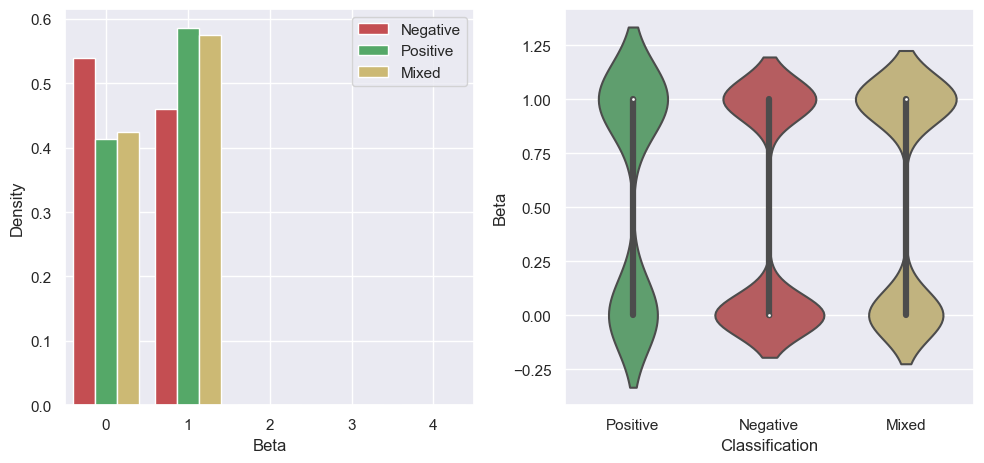

1    2853
0    2517
Name: Helix, dtype: int64


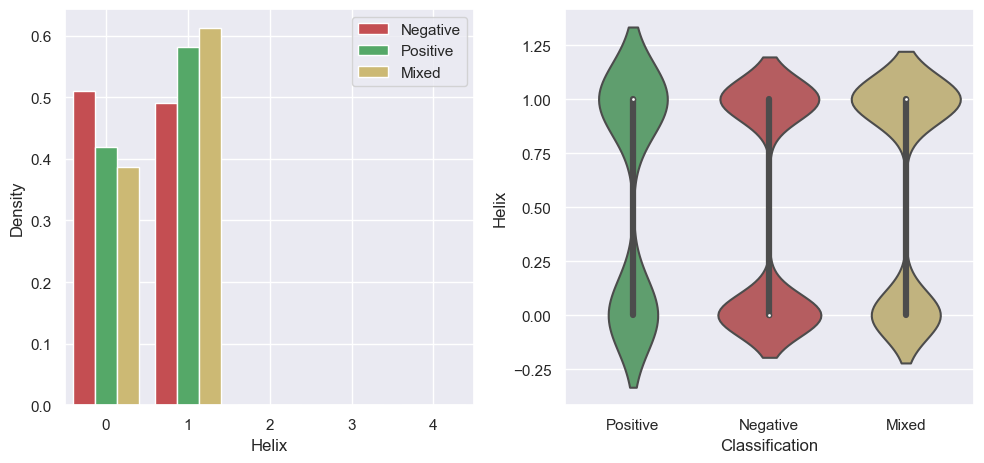

0    3668
1    1702
Name: Binding, dtype: int64


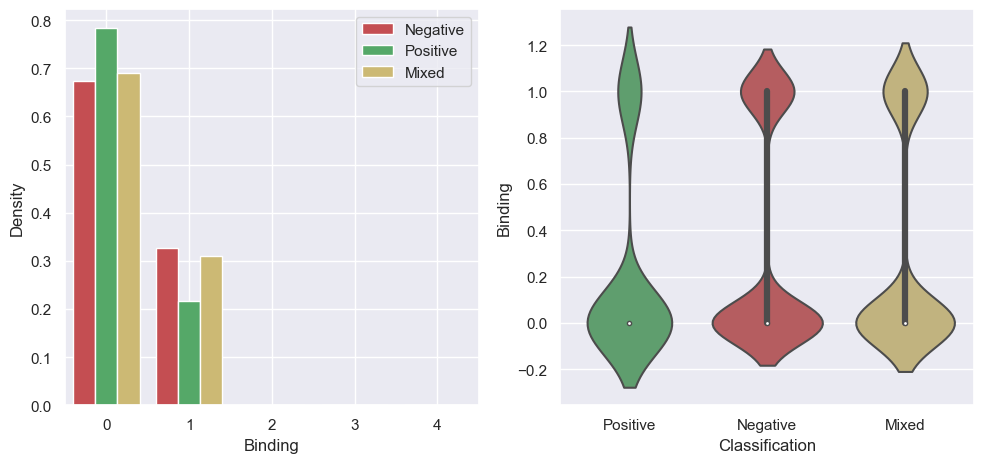

1    2886
0    2484
Name: Disordered, dtype: int64


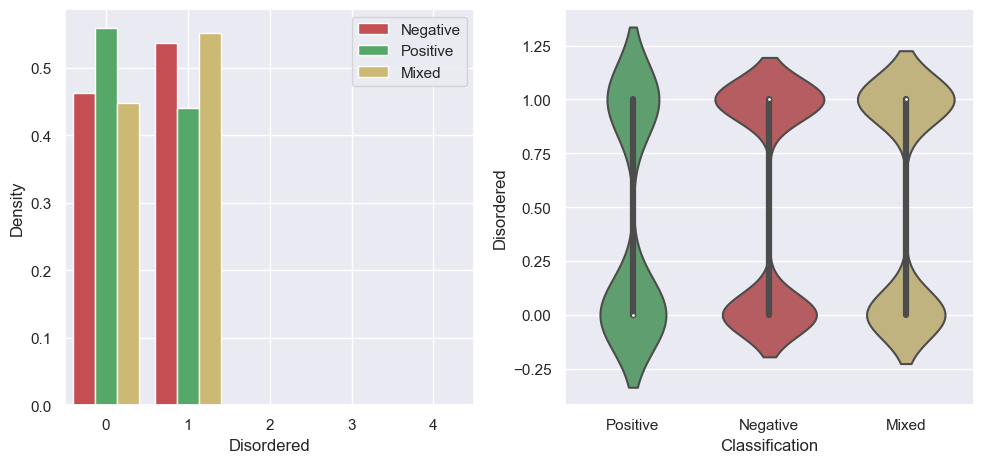

0    2965
1    2405
Name: Turn, dtype: int64


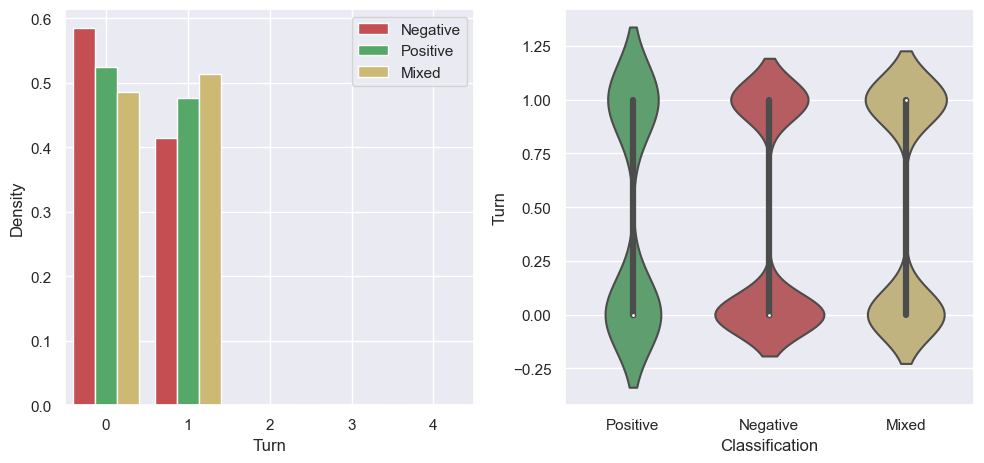

0    3960
1    1410
Name: Polar, dtype: int64


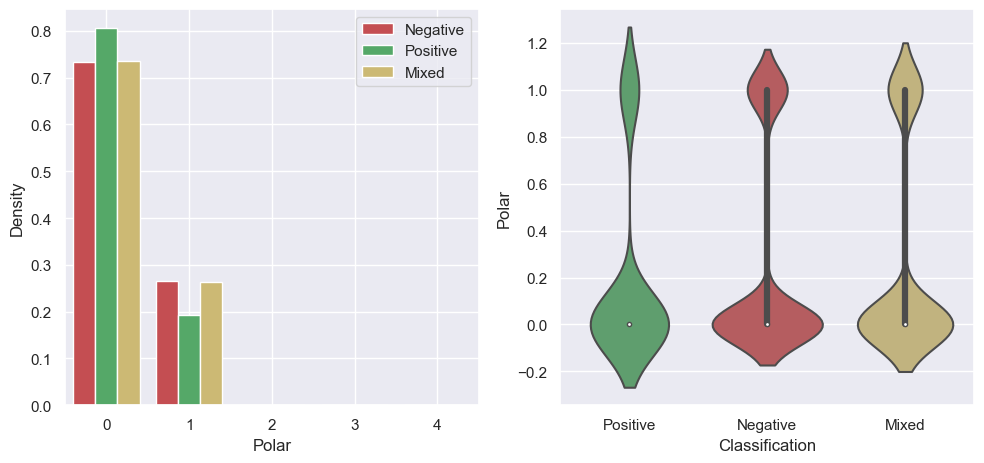

0    4539
1     831
Name: Helical, dtype: int64


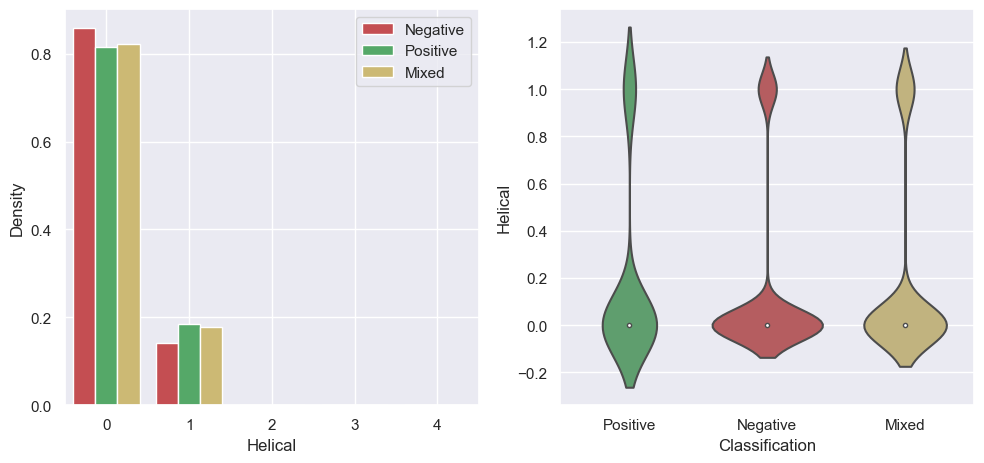

0    4131
1    1239
Name: Basic, dtype: int64


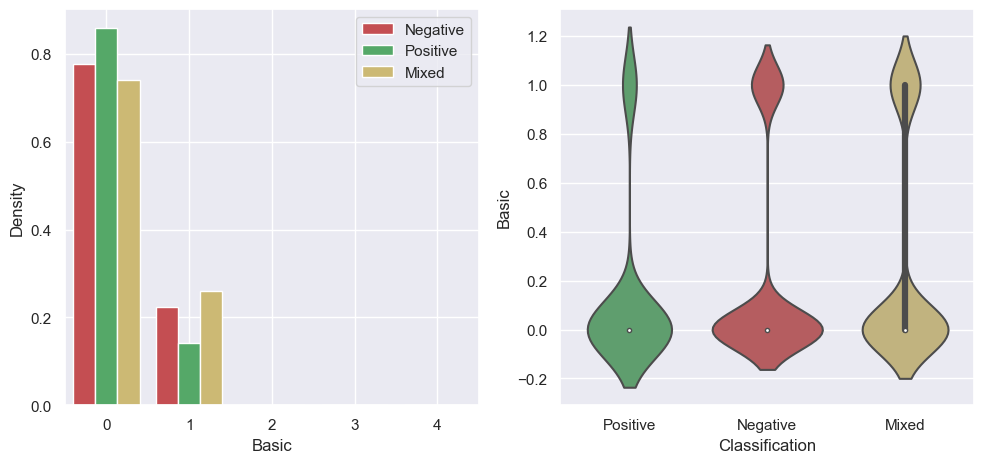

0    4618
1     752
Name: Cytoplasmic, dtype: int64


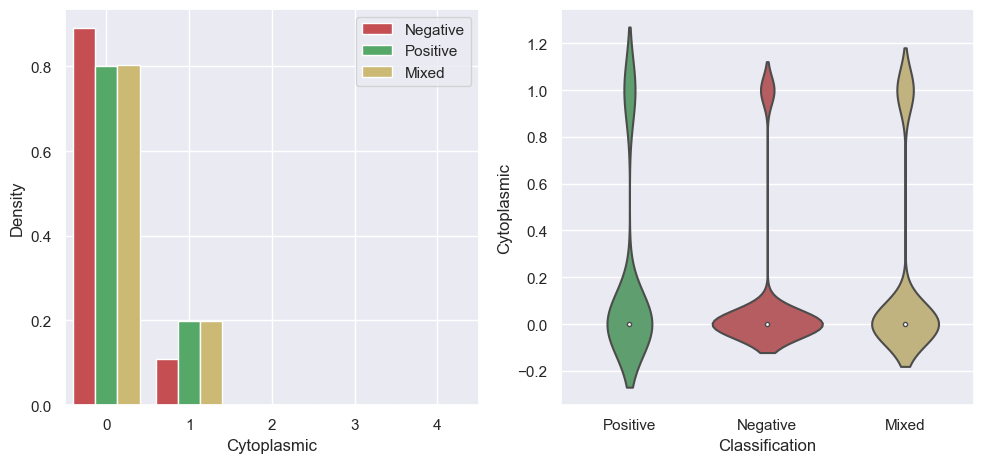

0    4899
1     471
Name: Extracellular, dtype: int64


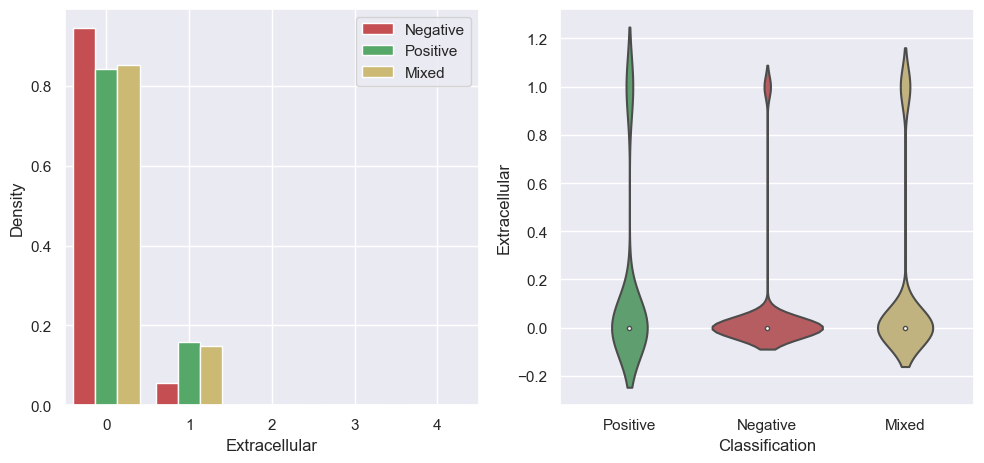

0    4760
1     610
Name: Coiled, dtype: int64


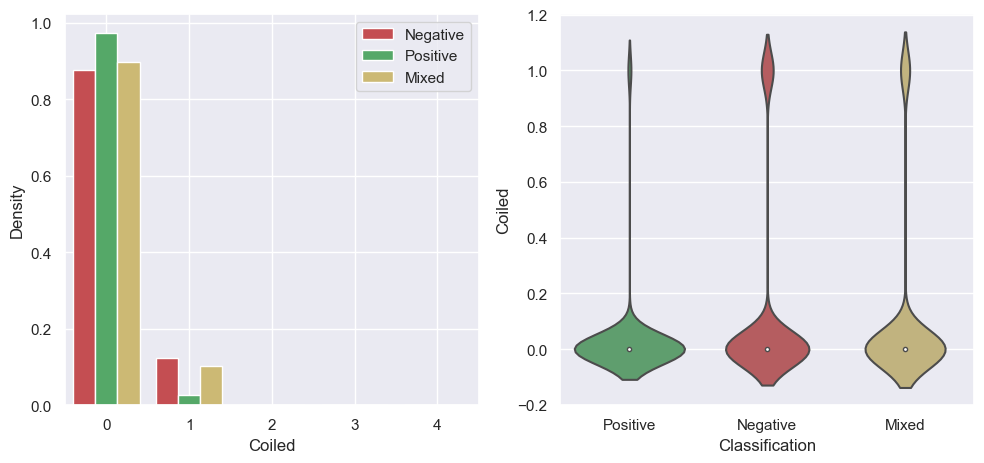

0    4135
1    1235
Name: Initiator_Methionine, dtype: int64


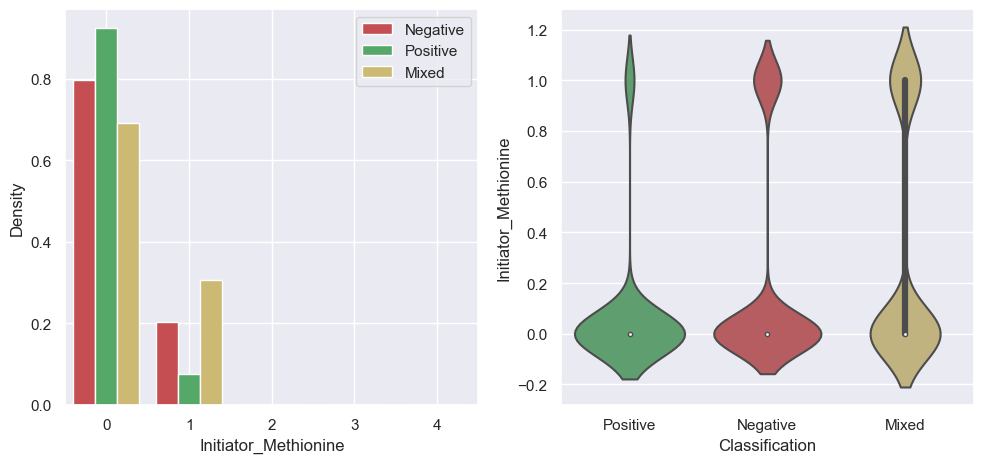

0    4256
1    1114
Name: Cleavage, dtype: int64


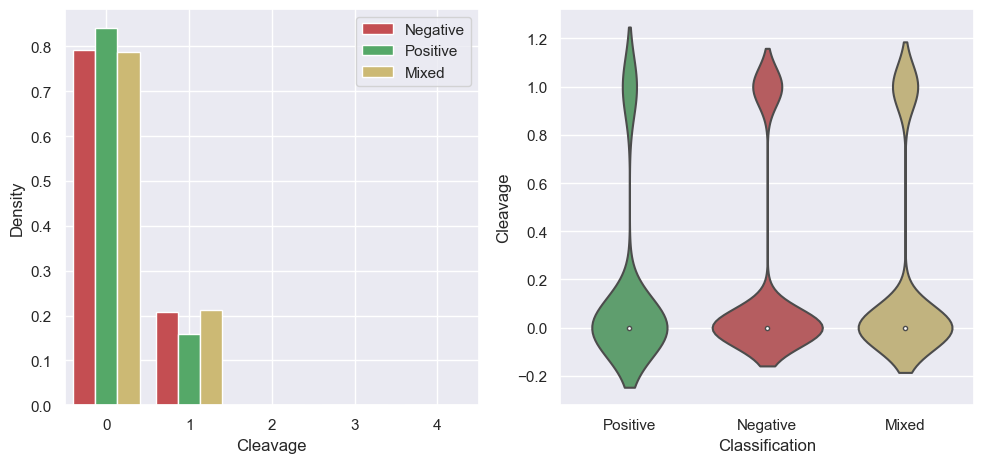

In [88]:
groupedcoverage = coveragedf.groupby(['Classification'])
for f in features:
    print(coveragedf[f].value_counts())
    fig, ax1 = plt.subplots(1,2)
    fig.set_figwidth(10)
    ax1[0].hist([groupedcoverage[f].get_group('Negative'), groupedcoverage[f].get_group('Positive'),groupedcoverage[f].get_group('Mixed')],bins=np.arange(25) - 0.5
     ,density=True,color=['r','g','y'])
    ax1[0].set_xlim([-0.5, 4.5])
    #finishes the plot
    ax1[0].set_ylabel("Density")
    ax1[0].set_xlabel(f)
    ax1[0].legend(['Negative','Positive','Mixed'])
    ax1[0].set_xticks(np.arange(0, 5, step=1))
    ax1[1] = sns.violinplot(data=coveragedf, x="Classification", y=f,palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
    plt.tight_layout()
    plt.show() 

0    4721
1     649
Name: Disulfide, dtype: int64


/var/folders/zx/9wq85h090yj8pmk6sbvl93n80000gn/T/ipykernel_1814/1169192460.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Not Found','Found'])


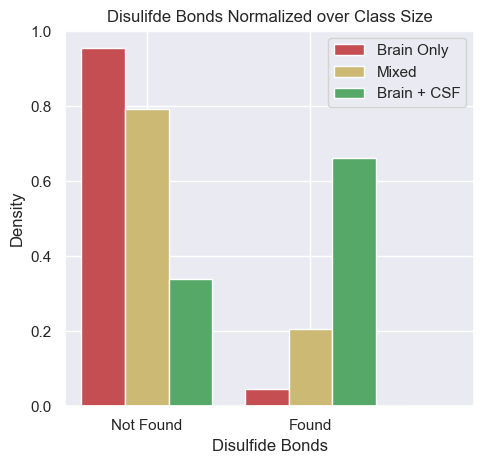

In [89]:
print(coveragedf['Disulfide'].value_counts())
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(5)
ax1.hist([groupedcoverage['Disulfide'].get_group('Negative'),groupedcoverage['Disulfide'].get_group('Mixed'), groupedcoverage['Disulfide'].get_group('Positive')],bins=np.arange(25) - 0.5
 ,density=True,color=['r','y','g'])
ax1.set_xlim([-0.5, 1])
#finishes the plot
ax1.set_title("Disulifde Bonds Normalized over Class Size")
ax1.set_ylabel("Density")
ax1.set_xticklabels(['Not Found','Found'])
ax1.set_xlabel("Disulfide Bonds")
ax1.legend(['Brain Only','Mixed','Brain + CSF'])
ax1.set_xticks(np.arange(0, 2.5, step=1))
plt.tight_layout()
plt.show()

0     896
1     491
2     376
3     353
4     326
     ... 
48      1
60      1
51      1
63      1
49      1
Name: Ubiquitination, Length: 67, dtype: int64


/var/folders/zx/9wq85h090yj8pmk6sbvl93n80000gn/T/ipykernel_1814/2838852432.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Not Found','Found'])


FileNotFoundError: [Errno 2] No such file or directory: 'Figures/Ubiquitination_Protein.png'

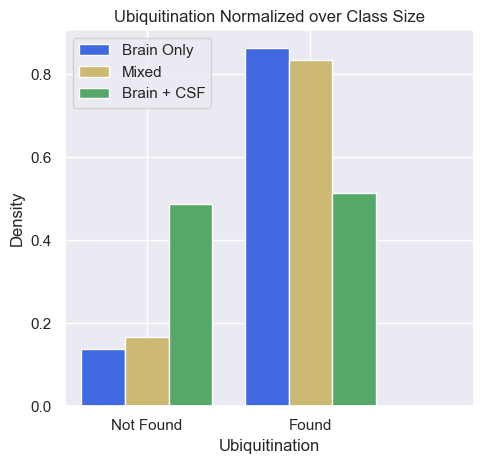

In [90]:
print(coveragedf['Ubiquitination'].value_counts())
coveragedf['Ubiquitination'] = coveragedf['Ubiquitination'].apply(lambda x: 1 if x != 0 else 0)
groupedcoverage = coveragedf.groupby(['Filtered_Classification'])
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(5)
ax1.hist([groupedcoverage['Ubiquitination'].get_group('Negative'),groupedcoverage['Ubiquitination'].get_group('Mixed'), groupedcoverage['Ubiquitination'].get_group('Positive')],bins=np.arange(25) - 0.5
 ,density=True,color=['royalblue','y','g'])
ax1.set_xlim([-0.5, 1])
#finishes the plot
ax1.set_title("Ubiquitination Normalized over Class Size")
ax1.set_ylabel("Density")
ax1.set_xticklabels(['Not Found','Found'])
ax1.set_xlabel("Ubiquitination")
ax1.legend(['Brain Only','Mixed','Brain + CSF'])
ax1.set_xticks(np.arange(0, 2.5, step=1))
plt.tight_layout()
plt.savefig('Figures/Ubiquitination_Protein.png')
plt.show()

0     4390
1      221
2      158
3      139
4      111
5       71
6       64
7       47
8       38
9       25
10      24
12      15
11      13
13       9
14       7
16       6
19       5
15       4
26       3
18       3
17       3
20       2
22       2
25       2
35       2
45       2
34       1
48       1
21       1
38       1
Name: Glycosylation, dtype: int64


/var/folders/zx/9wq85h090yj8pmk6sbvl93n80000gn/T/ipykernel_1814/3304532785.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Not Found','Found'])


FileNotFoundError: [Errno 2] No such file or directory: 'Figures/Glycosylation_Protein.png'

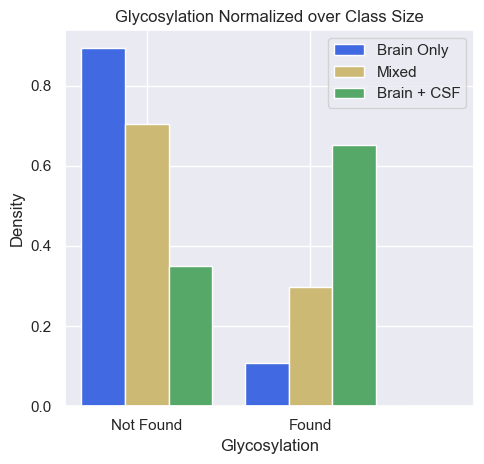

In [91]:
print(coveragedf['Glycosylation'].value_counts())
coveragedf['Glycosylation'] = coveragedf['Glycosylation'].apply(lambda x: 1 if x != 0 else 0)
groupedcoverage = coveragedf.groupby(['Region_Classification'])
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(5)
ax1.hist([groupedcoverage['Glycosylation'].get_group('Negative'),groupedcoverage['Glycosylation'].get_group('Mixed'), groupedcoverage['Glycosylation'].get_group('Positive')],bins=np.arange(25) - 0.5
 ,density=True,color=['royalblue','y','g'])
ax1.set_xlim([-0.5, 1])
#finishes the plot
ax1.set_title("Glycosylation Normalized over Class Size")
ax1.set_ylabel("Density")
ax1.set_xticklabels(['Not Found','Found'])
ax1.set_xlabel("Glycosylation")
ax1.legend(['Brain Only','Mixed','Brain + CSF'])
ax1.set_xticks(np.arange(0, 2.5, step=1))
plt.tight_layout()
plt.savefig('Figures/Glycosylation_Protein.png')
plt.show()

KeyError: 'Column not found: Ectodomain'

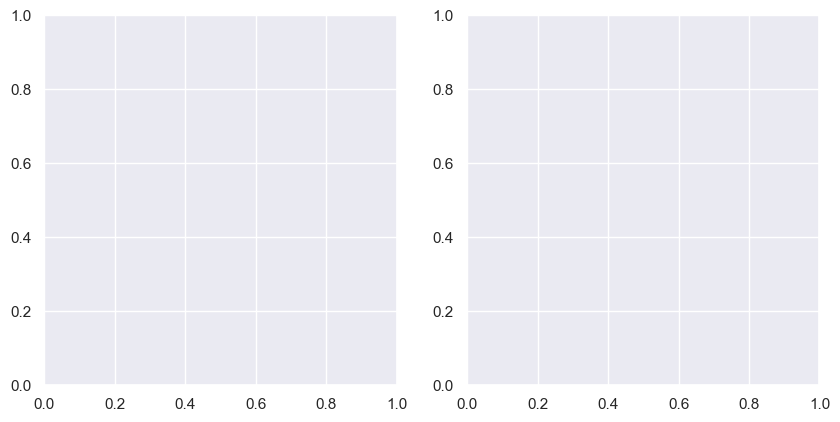

In [92]:
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([groupedcoverage['Ectodomain'].get_group('Negative'), groupedcoverage['Ectodomain'].get_group('Positive'),groupedcoverage['Ectodomain'].get_group('Mixed')]
 ,density=True,color=['r','g','y'])
ax1[0].set_xlim([-4.5, 4.5])
#finishes the plot
ax1[0].set_ylabel("Density")
ax1[0].set_xlabel("S-Score Shedding Events")
ax1[0].legend(['Brain Only','Brain + CSF','Mixed'])
ax1[0].set_xticks(np.arange(-4.5, 4.5, step=1))
ax1[1] = sns.violinplot(data=coveragedf, x="Classification", y="Ectodomain",palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
ax1[1].set_xticklabels(['Brain Only','Mixed','Brain + CSF'])
plt.tight_layout()
plt.show()

/var/folders/zx/9wq85h090yj8pmk6sbvl93n80000gn/T/ipykernel_1814/2800857032.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['Not Found','Found'])


FileNotFoundError: [Errno 2] No such file or directory: 'Figures/Isoforms.png'

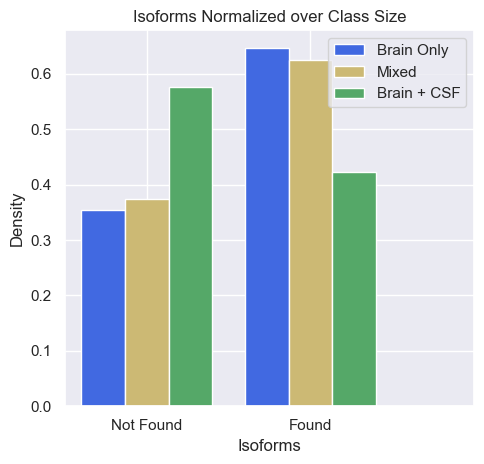

In [93]:
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(5)
ax1.hist([groupedcoverage['Isoforms'].get_group('Negative'),groupedcoverage['Isoforms'].get_group('Mixed'), groupedcoverage['Isoforms'].get_group('Positive')],bins=np.arange(25) - 0.5
 ,density=True,color=['royalblue','y','g'])
ax1.set_xlim([-0.5, 1])
#finishes the plot
ax1.set_title("Isoforms Normalized over Class Size")
ax1.set_ylabel("Density")
ax1.set_xlabel("Isoforms")
ax1.set_xticklabels(['Not Found','Found'])
ax1.legend(['Brain Only','Mixed','Brain + CSF'])
ax1.set_xticks(np.arange(0, 2.5, step=1))
plt.tight_layout()
plt.savefig('Figures/Isoforms.png')
plt.show()

In [ ]:
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([groupedcoverage['GPI'].get_group('Negative'), groupedcoverage['GPI'].get_group('Positive'),groupedcoverage['GPI'].get_group('Mixed')],bins=np.arange(25) - 0.5
 ,density=True,color=['r','g','y'])
ax1[0].set_xlim([-0.5, 4.5])
#finishes the plot
ax1[0].set_ylabel("Density")
ax1[0].set_xlabel("GPI")
ax1[0].legend(['Negative','Positive','Mixed'])
ax1[0].set_xticks(np.arange(0, 5, step=1))
ax1[1] = sns.violinplot(data=coveragedf, x="Classification", y="GPI",palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
plt.tight_layout()
plt.show()

In [ ]:
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([groupedcoverage['Anchor'].get_group('Negative'), groupedcoverage['Anchor'].get_group('Positive'),groupedcoverage['Anchor'].get_group('Mixed')],bins=np.arange(25) - 0.5
 ,density=True,color=['r','g','y'])
ax1[0].set_xlim([-0.5, 4.5])
#finishes the plot
ax1[0].set_ylabel("Density")
ax1[0].set_xlabel("Anchor")
ax1[0].legend(['Negative','Positive','Mixed'])
ax1[0].set_xticks(np.arange(0, 5, step=1))
ax1[1] = sns.violinplot(data=coveragedf, x="Classification", y="Anchor",palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
add_stat_annotation(ax1[1], data=coveragedf, x="Classification", y="Anchor",
                    box_pairs=[("Negative", "Mixed"), ("Mixed", "Positive"), ("Negative", "Positive")],
                    test='Kruskal', text_format='star', loc='outside', verbose=3)
plt.tight_layout()
plt.show()

In [ ]:
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(5)
ax1.hist([groupedcoverage['Transmembrane'].get_group('Negative'),groupedcoverage['Transmembrane'].get_group('Mixed'), groupedcoverage['Transmembrane'].get_group('Positive')],bins=np.arange(25) - 0.5
 ,density=True,color=['royalblue','y','g'])
ax1.set_xlim([-0.5, 4.5])
#finishes the plot
ax1.set_ylabel("Density")
ax1.set_xlabel("Transmembrane Components in Protein")
ax1.legend(['Negative','Mixed','Positive'])
ax1.set_xticks(np.arange(0, 5, step=1))
ax1.set_title("Transmembrane Normalized over Class Size")
plt.tight_layout()
plt.savefig('Figures/Transmembrane')
plt.show()

In [ ]:
coveragedf.columns

In [ ]:
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,1)
fig.set_figwidth(5)
ax1.hist([groupedcoverage['Signal_Peptide'].get_group('Negative'),groupedcoverage['Signal_Peptide'].get_group('Mixed'), groupedcoverage['Signal_Peptide'].get_group('Positive')],bins=np.arange(25) - 0.5
 ,density=True,color=['royalblue','y','g'])
ax1.set_xlim([-0.5, 1])
#finishes the plot
ax1.set_title("Signal_Peptide Normalized over Class Size")
ax1.set_ylabel("Density")
ax1.set_xlabel("Signal_Peptide")
ax1.set_xticklabels(['Not Found','Found'])
ax1.legend(['Brain Only','Mixed','Brain + CSF'])
ax1.set_xticks(np.arange(0, 2.5, step=1))
plt.tight_layout()
plt.savefig('Figures/Signal_Peptide_Protein.png')
plt.show()

In [ ]:
groupedcoverage = coveragedf.groupby(['Classification'])
fig, ax1 = plt.subplots(1,2)
fig.set_figwidth(10)
ax1[0].hist([groupedcoverage['Acetylation'].get_group('Negative'), groupedcoverage['Acetylation'].get_group('Positive'),groupedcoverage['Acetylation'].get_group('Mixed')],bins=np.arange(5) - 0.5
 ,density=True,color=['r','g','y'])
ax1[0].set_xlim([-0.5, 2.5])
#finishes the plot
ax1[0].set_ylabel("Density")
ax1[0].set_xlabel("Acetylation")
ax1[0].legend(['Negative','Positive','Mixed'])
ax1[0].set_xticks(np.arange(0, 5, step=1))
ax1[1] = sns.boxplot(data=coveragedf, x="Classification", y="Acetylation",palette={"Negative": "r", "Positive": "g", "Mixed": "y"})
plt.tight_layout()
plt.show()

#### Correlation of all protein features

Correlation coverage vs Number_peptides 0.5499241391044026


FileNotFoundError: [Errno 2] No such file or directory: 'Figures/Correlation_Heatmap.png'

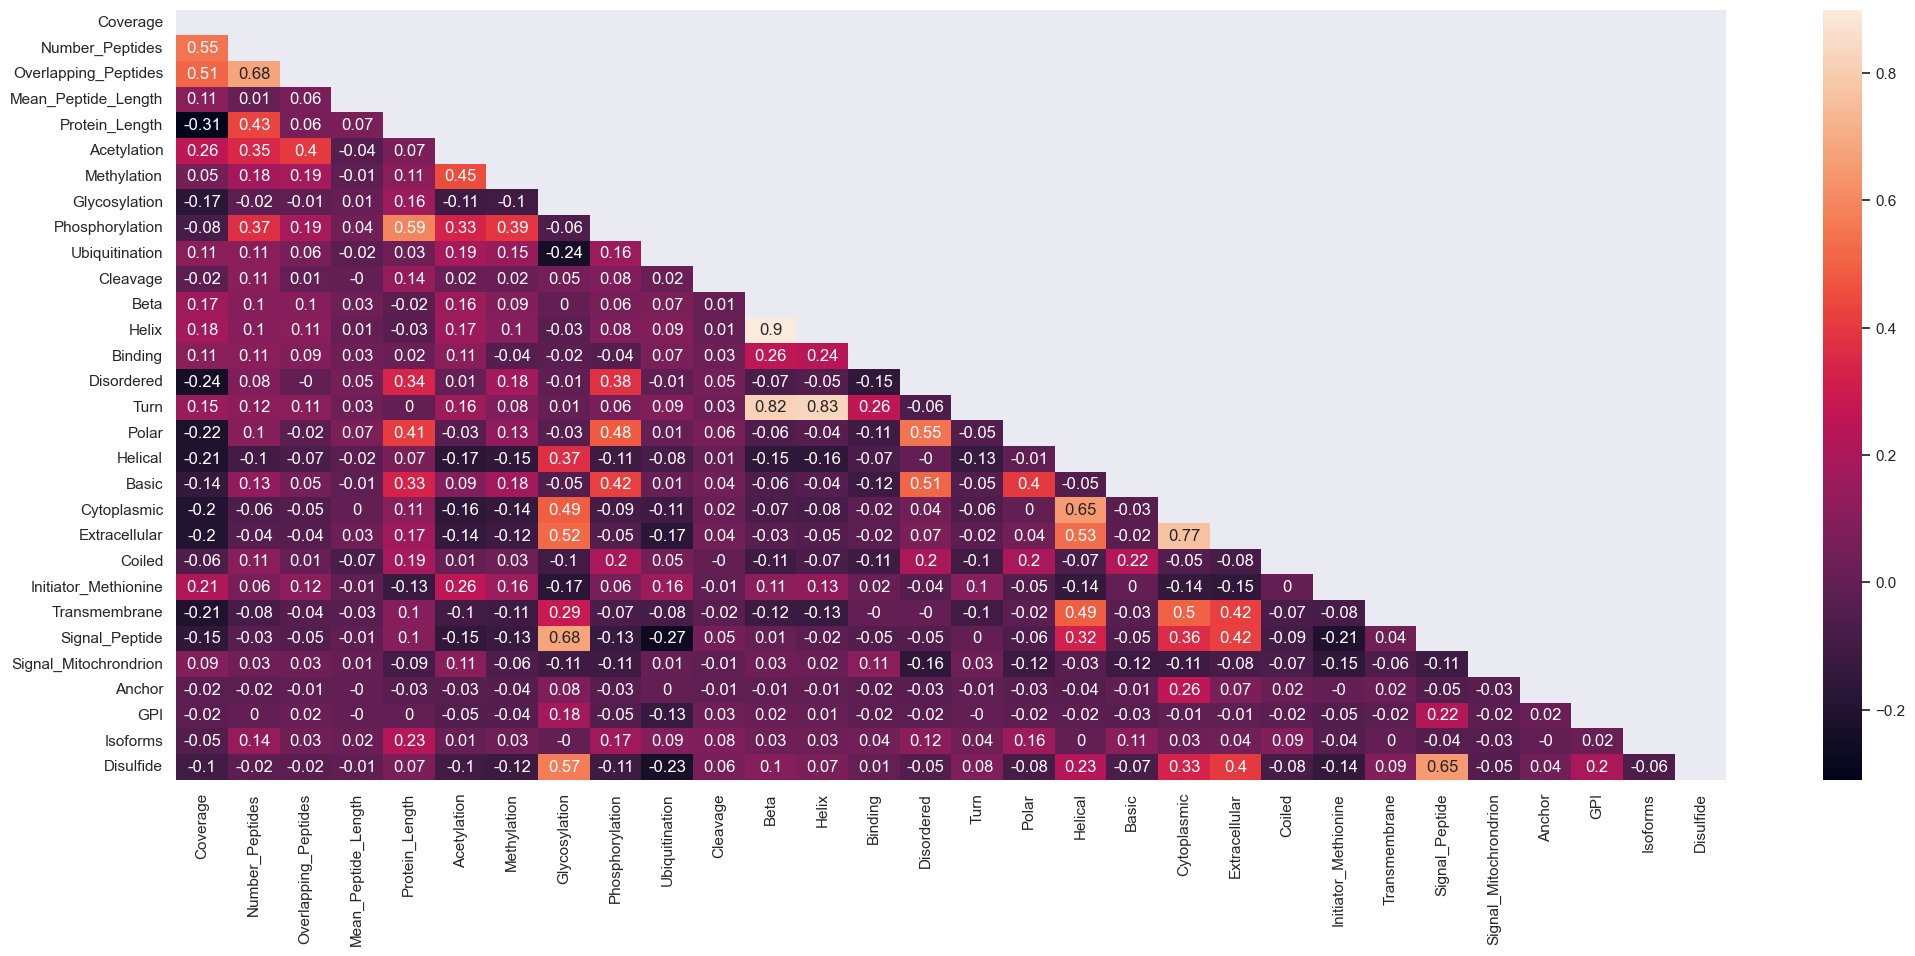

In [94]:
# correlation coverage and number peptides
print('Correlation coverage vs Number_peptides',coveragedf['Coverage'].corr(coveragedf['Number_Peptides']))
fig, ax = plt.subplots(figsize=(25, 10))
corr_matrix = coveragedf.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr_matrix)

sns.heatmap(round(corr_matrix,2), 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values,
               annot=True , mask=matrix)
plt.savefig('Figures/Correlation_Heatmap')
plt.show()

Correlation coverage vs Number_peptides 0.4302640393025618


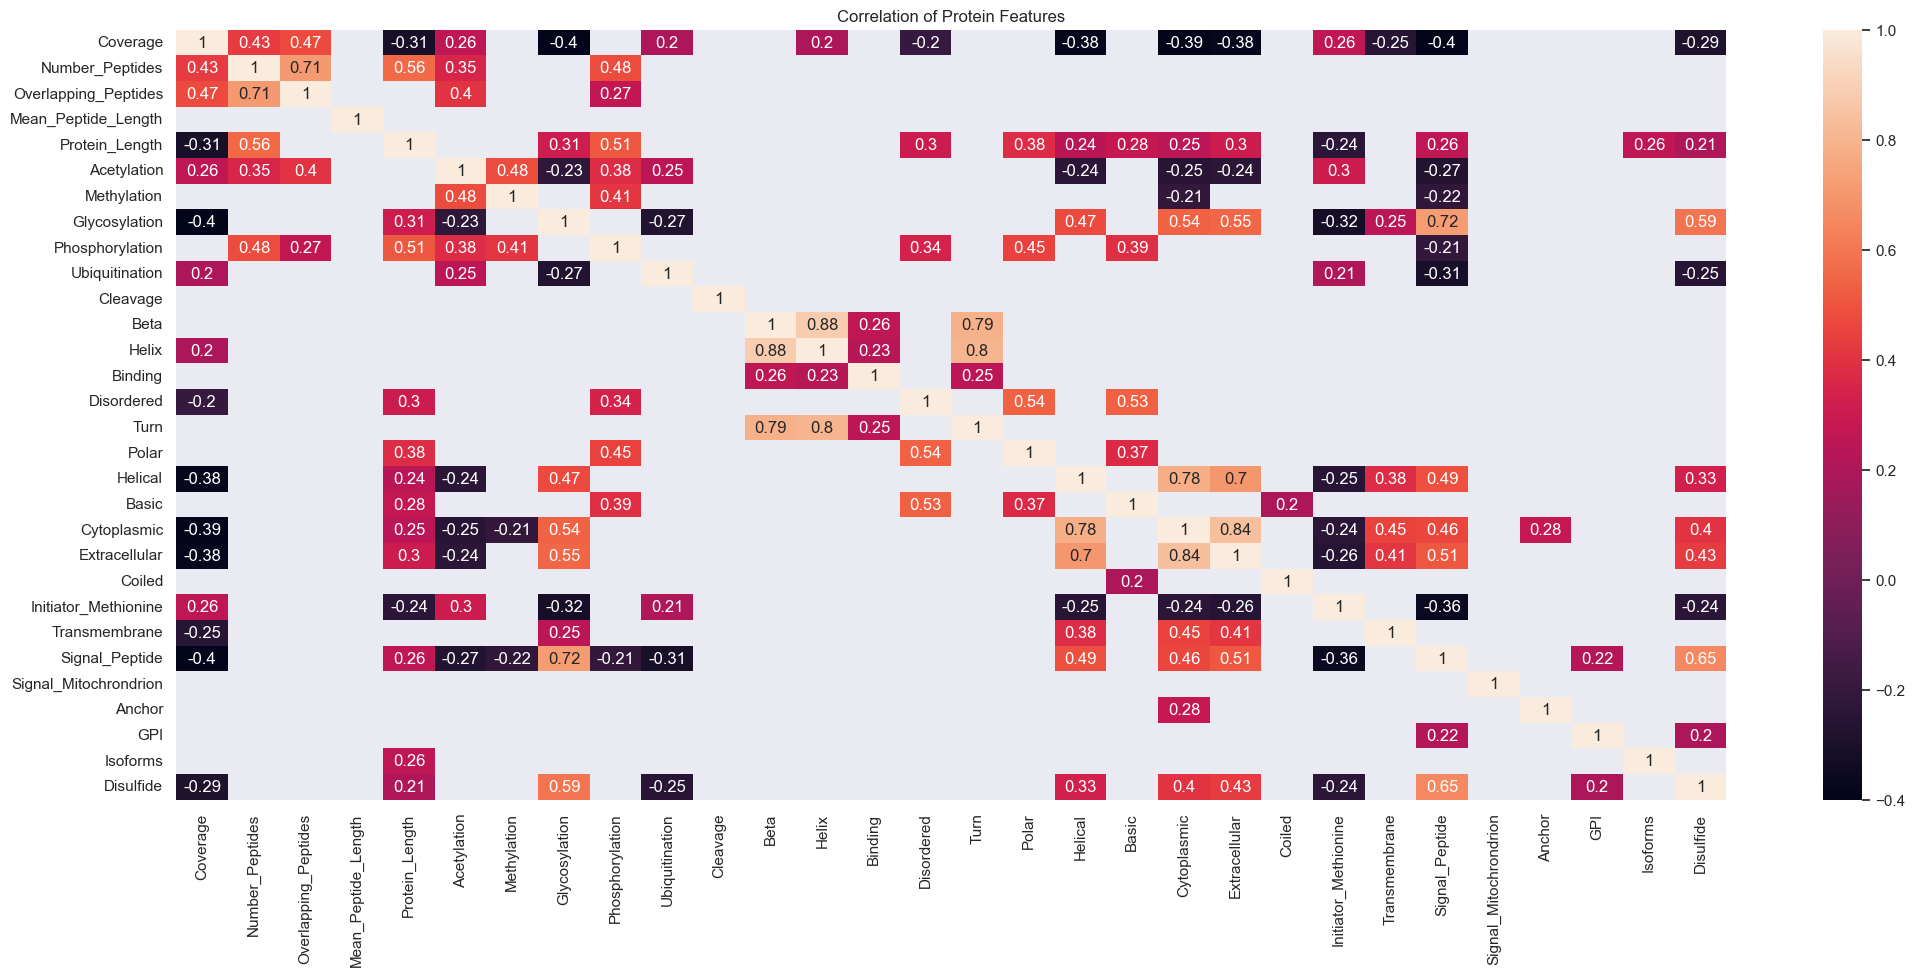

In [95]:
# correlation coverage and number peptides
mixeddf = coveragedf[coveragedf['Classification']=='Mixed']
print('Correlation coverage vs Number_peptides',mixeddf['Coverage'].corr(mixeddf['Number_Peptides']))
fig, ax = plt.subplots(figsize=(25, 10))
corr_matrix = mixeddf.corr()
kot = corr_matrix[abs(corr_matrix)>=.2]
sns.heatmap(round(kot,2), 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values,
               annot=True).set(title='Correlation of Protein Features')

plt.show()

In [96]:
coveragedf['Transmembrane'].describe()
len(coveragedf[coveragedf['Transmembrane']!=0])
trans = coveragedf[coveragedf['Transmembrane']==1]
sum(trans['Transmembrane'])
#groupedcoverage['Transmembrane'].get_group('Mixed')

563

In [97]:
mixedproteins = coveragedf[coveragedf['Classification']=='Mixed']
mixedproteins.columns
len(mixedproteins[mixedproteins['Ectodomain']<0])
len(mixedproteins[mixedproteins['Ectodomain']>0])

KeyError: 'Ectodomain'

#### Checking labels of peptides from cytoplasmic and extracellular peptides

In [98]:
topological_domain = proteinfeatures[proteinfeatures['Type']=='Topological domain']
topological_domain = topological_domain[topological_domain['Protein'].isin(strict['Protein'].unique())]
topological_domain = topological_domain[(topological_domain['Description']=='Cytoplasmic')|(proteinfeatures['Description']=='Extracellular')]
#len(transmembrane['Protein'].unique())
topological_domain
transmembraneproteins = strict[strict['Protein'].isin(topological_domain['Protein'].unique())]
transmembraneproteins = transmembraneproteins[transmembraneproteins['Protein'].isin(mixedproteins['Protein'].unique())]
print(len(transmembraneproteins),'peptides')
print(len(transmembraneproteins['Protein'].unique()),'Protein')
ex_pos = 0
cy_pos = 0
ex_neg = 0
cy_neg = 0
for i,pep in transmembraneproteins.iterrows():
    pro = pep['Protein']
    index = np.arange(pep['Position_in_Protein'],pep['Position_in_Protein']+pep['Sequence_Length'])
    temp = topological_domain[topological_domain['Protein']==pro]
    for n,p in temp.iterrows():
        pindex = np.arange(p['Start'],p['End'])
        isin = np.isin(index,pindex) # check if theoritical sequence index is in range of peptide sequences index
        if True in isin:
            if p['Description'] == 'Cytoplasmic' and pep['CSF'] == 'Brain + CSF':
                cy_pos += 1
            if p['Description'] == 'Cytoplasmic' and pep['CSF'] == 'Brain Only':
                cy_neg += 1
            if p['Description'] == 'Extracellular' and pep['CSF'] == 'Brain + CSF':
                ex_pos += 1
            if p['Description'] == 'Extracellular' and pep['CSF'] == 'Brain Only':
                ex_neg += 1
print(ex_pos)
print(cy_pos)
print(ex_neg)
print(cy_neg)

/var/folders/zx/9wq85h090yj8pmk6sbvl93n80000gn/T/ipykernel_1814/3573384710.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  topological_domain = topological_domain[(topological_domain['Description']=='Cytoplasmic')|(proteinfeatures['Description']=='Extracellular')]


4919 peptides
325 Protein
1522
394
1002
1516


### Explore number of mixed proteins we can explain

In [99]:
pd.set_option('display.max_rows',400)
GPI = mixedproteins[mixedproteins['GPI']==1]['Protein'].unique()
strict[strict['Protein'].isin(GPI)].sort_values(by=['Protein','Position_in_Protein'])

Peptide_Sequence  Sequence_Length Protein  Brain  \
43444                          NDAPLHEINGDHLK             14.0  O75487   True   
57046                       SVVSEQCNHLQAVFASR             17.0  O75487   True   
58168                         TFAQGLAVAGDVVSK             15.0  O75487   True   
34534                       LEGPFNIESVMDPIDVK             17.0  O75487   True   
46678                           QCQPSDTVCASVR             13.0  O94772   True   
30416                                ITDPSSSR              8.0  O94772   True   
30417                               ITDPSSSRK              9.0  O94772   True   
41398                              MCASSCDFVK             10.0  O94772   True   
50327                      RHFFSDYLMGFINSGILK             18.0  O94772   True   
25175                       HFFSDYLMGFINSGILK             17.0  O94772   True   
62379                                VDVDCCEK              8.0  O94772   True   
18356                           FISQETGNLYISK             13.0  O94779   True   
23484                       GQPIDFEEEGGHFESIR             17.0  O94779   True   
66498                       VVATNPIGTGDPSTPSR             17.0  O94779   True   
46912                          QEGHSNSQVIETQK             14.0  O94779   True   
38528                      LQAVVPLPDAGVYIIEVR             18.0  O94779   True   
6204                          AYSEGGDGTASSQIR             15.0  O94779   True   
69414                             YPGQGSPGGNR             11.0  P04156   True   
25825  HMAGAAAAGAVVGGLGGYMLGSAMSRPIIHFGSDYEDR             38.0  P04156   True   
69455           YPNQVYYRPMDEYSNQNNFVHDCVNITIK             29.0  P04156   True   
47516                               QHTVTTTTK              9.0  P04156   True   
21022                              GENFTETDVK             10.0  P04156   True   
66581                            VVEQMCITQYER             12.0  P04156   True   
15977                                ESQAYYQR              8.0  P04156   True   
46029                     NVIMFLGDGMGVSTVTAAR             19.0  P05186   True   
19045                                FPFVALSK              8.0  P05186   True   
3837                           ANEGTVGVSAATER             14.0  P05186   True   
56782                               SVGIVTTTR              9.0  P05186   True   
8274                              DIAYQLMHNIR             11.0  P05186   True   
34110                             LDGLDLVDTWK             11.0  P05186   True   
21206                              GFFLLVEGGR             10.0  P05186   True   
46503                             QALHEAVEMDR             11.0  P05186   True   
61134                        TVGWNVPVGYLVESGR             16.0  P08582   True   
65138                               VPAHAVVVR              9.0  P08582   True   
10365             DSTSELVPIATQTYEAWLGHEYLHAMK             27.0  P08582   True   
67272                             WCVLSTPEIQK             11.0  P08582   True   
61466            TYGLVPAAGEHYAPEDSSNSYYVVAVVR             28.0  P08582   True   
57787                             TDLLNVCMDAK             11.0  P14207   True   
43183                          NACCTASTSQELHK             14.0  P14207   True   
18481                                FLDVPLCK              8.0  P14207   True   
24642                              GWDWTSGVNK             10.0  P14207   True   
58201                  TFESYFPTPAALCEGLWSHSYK             22.0  P14207   True   
46916                               QEGMEAFLK              9.0  P14384   True   
44887                               NLWVLVVGR              9.0  P14384   True   
27920                                 IGIPEFK              7.0  P14384   True   
69940                           YVANMHGDETVGR             13.0  P14384   True   
28136                        IHIMPSMNPDGFEAVK             16.0  P14384   True   
32465                              KPDCYYSIGR             10.0  P14384   True   
15055                              ENYNQYDLNR             10

In [100]:
mixedproteins = mixedproteins[mixedproteins['Region_Classification']=='Mixed']
pd.set_option('display.max_rows',400)
GPI = mixedproteins[mixedproteins['Signal_Peptide']==1]['Protein'].unique()
strict[strict['Protein'].isin(GPI)].sort_values(by=['Protein','Position_in_Protein'])

Peptide_Sequence  Sequence_Length Protein  Brain          CSF  \
19385          FSATVSVADTAQR             13.0  O14522   True   Brain Only   
52543       SDGGSGVSNYAELIVK             16.0  O14522   True  Brain + CSF   
60926     TTTGTWAETHIVDSPNYK             18.0  O14522   True  Brain + CSF   
64379  VLLTRPGEGGTGPPGPPLTTR             21.0  O14522   True  Brain + CSF   
48185        QLTLQWEPFGYAVTR             15.0  O14522   True   Brain Only   
...                      ...              ...     ...    ...          ...   
20136               FYYLGPFK              8.0  Q9Y6N8   True  Brain + CSF   
30190         ISIEDVDEPPVFSR             14.0  Q9Y6N8   True  Brain + CSF   
9596              DPDSISSPIR             10.0  Q9Y6N8   True  Brain + CSF   
8361             DIIPETLFIPR             11.0  Q9Y6N8   True   Brain Only   
51664           RTPTAPDNTDVR             12.0  Q9Y6N8   True   Brain Only   

                       Author  Detectability  Detection_Probability  \
19385  Faigle, Rydbirk, Duong            1.0               0.728834   
52543  Faigle, Rydbirk, Duong            1.0               0.805454   
60926         Faigle, Rydbirk            1.0               0.834311   
64379         Faigle, Rydbirk            1.0               0.898810   
48185  Faigle, Rydbirk, Duong            0.0               0.445122   
...                       ...            ...                    ...   
20136  Faigle, Rydbirk, Duong            1.0               0.899265   
30190          Rydbirk, Duong            1.0               0.597120   
9596           Rydbirk, Duong            1.0               0.729329   
8361   Faigle, Rydbirk, Duong            1.0               0.772551   
51664         Faigle, Rydbirk            1.0               0.662214   

                                        Protein_Sequence  Protein_Length  ...  \
19385  MASLAALALSLLLRLQLPPLPGARAQSAAGGCSFDEHYSNCGYSVA...          1441.0  ...   
52543  MASLAALALSLLLRLQLPPLPGARAQSAAGGCSFDEHYSNCGYSVA...          1441.0  ...   
60926  MASLAALALSLLLRLQLPPLPGARAQSAAGGCSFDEHYSNCGYSVA...          1441.0  ...   
64379  MASLAALALSLLLRLQLPPLPGARAQSAAGGCSFDEHYSNCGYSVA...          1441.0  ...   
48185  MASLAALALSLLLRLQLPPLPGARAQSAAGGCSFDEHYSNCGYSVA...          1441.0  ...   
...                                                  ...             ...  ...   
20136  MTIHQFLLLFLFWVCLPHFCSPEIMFRRTPVPQQRILSSRVPRSDG...           788.0  ...   
30190  MTIHQFLLLFLFWVCLPHFCSPEIMFRRTPVPQQRILSSRVPRSDG...           788.0  ...   
9596   MTIHQFLLLFLFWVCLPHFCSPEIMFRRTPVPQQRILSSRVPRSDG...           788.0  ...   
8361   MTIHQFLLLFLFWVCLPHFCSPEIMFRRTPVPQQRILSSRVPRSDG...           788.0  ...   
51664  MTIHQFLLLFLFWVCLPHFCSPEIMFRRTPVPQQRILSSRVPRSDG...           788.0  ...   

         Z    J    X           MZ    Charge      Weight  Hydrophobicity  \
19385  0.0  0.0  0.0   676.843861 -0.001573  1352.46684        0.161538   
52543  0.0  0.0  0.0   798.399191 -1.000940  1595.72634       -0.050000   
60926  0.0  0.0  0.0  1010.984156 -0.910030  2021.17064       -0.866667   
64379  0.0  0.0  0.0  1037.076166  0.999753  2073.37994       -0.461905   
48185  0.0  0.0  0.0   904.970121 -0.001094  1809.05444       -0.280000   
...    ...  ...  ...          ...       ...         ...             ...   
20136  0.0  0.0  0.0   517.770916  0.995988  1034.22254        0.112500   
30190  0.0  0.0  0.0   801.904106 -2.997576  1602.76134       -0.221429   
9596   0.0  0.0  0.0   543.774916 -1.001126  1086.16674       -0.810000   
8361   0.0  0.0  0.0   657.376801 -0.999797  1313.55954        0.427273   
51664  0.0  0.0  0.0   671.839111 -0.001129  1342.43134       -1.566667   

       Hydrophobic_Moment  Instability   Structure  
19385            0.435950        -8.86        beta  
52543            0.498292        24.78       alpha  
60926            0.248863        29.77        beta  
64379            0.380798        31.24  alpha+beta  
48185            0.469875        61.21  alpha_beta  
...                   ...          ...    

In [101]:
print('all',len(mixedproteins),'Glycosylation',len(mixedproteins[mixedproteins['Glycosylation']!=0]),'Transmembrane',len(mixedproteins[mixedproteins['Transmembrane']!=0]),'Signal_Peptide',len(mixedproteins[mixedproteins['Signal_Peptide']!=0]),'Ectodomain',len(mixedproteins[mixedproteins['Ectodomain']>0]),'Isoforms',len(mixedproteins[mixedproteins['Isoforms']!=0]))
print('Glycosylation removed',len(mixedproteins[mixedproteins['Glycosylation']!=0]))
print('Transmembranes removed',len(mixedproteins[mixedproteins['Transmembrane']!=0]))
print('Extracellular removed',len(mixedproteins[mixedproteins['Extracellular']!=0]))
print('GPI removed',len(mixedproteins[mixedproteins['GPI']!=0]))
print('signal peptides removed',len(mixedproteins[mixedproteins['Signal_Peptide']!=0]))
# print('ectodomain removed',len(mixedproteins[mixedproteins['Ectodomain']>0]))
print('isoforms removed',len( mixedproteins[mixedproteins['Isoforms']!=0]))
# leftover['Protein']

KeyError: 'Ectodomain'

#### Since protein can have multiple explanations, counts the number without any explanations at all

In [ ]:
print('all',len(mixedproteins),'Glycosylation',len(mixedproteins[mixedproteins['Glycosylation']!=0]),'Transmembrane',len(mixedproteins[mixedproteins['Transmembrane']!=0]),'Signal_Peptide',len(mixedproteins[mixedproteins['Signal_Peptide']!=0]),'Ectodomain',len(mixedproteins[mixedproteins['Ectodomain']>0]),'Isoforms',len(mixedproteins[mixedproteins['Isoforms']!=0]))
leftover = mixedproteins[mixedproteins['Glycosylation']==0]
print('Glycosylation removed',len(leftover))
leftover = leftover[leftover['Transmembrane']==0]
print('Transmembranes removed',len(leftover))
leftover = leftover[leftover['Extracellular']==0]
print('Extracellular removed',len(leftover))
leftover = leftover[leftover['GPI']==0]
print('GPI removed',len(leftover))
leftover = leftover[leftover['Signal_Peptide']==0]
print('signal peptides removed',len(leftover))
# # leftover = leftover[leftover['Ectodomain']>0]
# print('ectodomain removed',len(leftover))
leftover = leftover[leftover['Isoforms']==0]
print('isoforms removed',len(leftover))
leftover['Protein']

A6NE02


FileNotFoundError: [Errno 2] No such file or directory: 'Figures/Mixed_Protein.png'

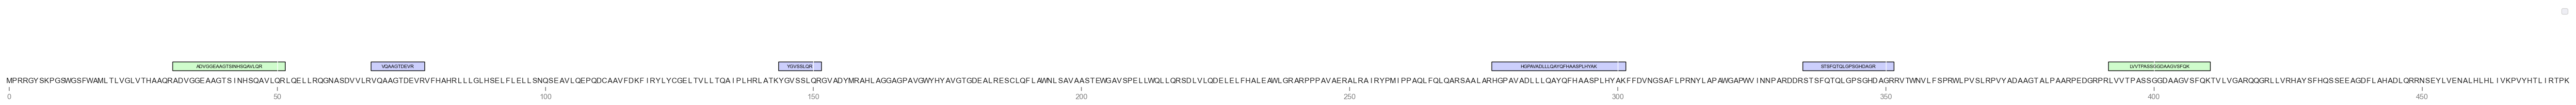

In [102]:
legend_elements = [Patch(facecolor='#cffccc', edgecolor='k',label='Brain and CSF'),
                   Patch(facecolor='#ffcccc', edgecolor='k',label='Only Brain'),
                  Patch(facecolor='#ffd700', edgecolor='k',label='PTMs'),
                  Patch(facecolor='lightgray', edgecolor='k',label='Domains')]
sample = strict['Protein'].unique()
for protein in ['A6NE02']:
    legend_elements = []
    print(protein)
    temp = strict[strict['Protein']==protein]
    featureslist = []
    for t in temp.iterrows():
        if t[1]['CSF'] == 'Brain + CSF':
            c = "#cffccc"
        else: c = "#cccffc"
        featureslist.append(GraphicFeature(start=t[1]["Position_in_Protein"], end=t[1]["Position_in_Protein"]+len(t[1]['Peptide_Sequence']), strand=0, color=c,
                       label=t[1]['Peptide_Sequence'],legend_text='True',linewidth=1,thickness=13,box_linewidth=0,fontdict={'fontsize': 7}))
    record = GraphicRecord(sequence_length = len(temp['Protein_Sequence'].values[0]),
                           sequence=temp['Protein_Sequence'].values[0],features=featureslist, 
                            plots_indexing='biopython', labels_spacing=1, ticks_resolution='auto')
    ax1, _ = record.plot(figure_width=len(temp['Protein_Sequence'].values[0])/7,annotate_inline=True,level_offset=0,draw_line=False,plot_sequence=True)
    plt.legend(handles=legend_elements, loc='upper right')
    ax1.figure.savefig('sequence_and_translation.png', bbox_inches='tight')
    plt.savefig('Figures/Mixed_Protein')
    plt.show()

In [103]:
strict[strict['Protein']==protein]
coveragedf[coveragedf['Protein']==protein]
proteinfeatures[proteinfeatures['Type']=='Modified residue']['Description'].value_counts()[:10]

Phosphorylation                 87614
Ubiquitination                  42246
Acetylation                     13658
Methylation                      7679
Glycosylation                    4642
Succinylation                    1033
Hydroxylation                     354
N6-glutaryllysine; alternate       51
Sulfotyrosine                      48
S-nitrosocysteine                  39
Name: Description, dtype: int64

Saving Final Databases

In [104]:
proteinfeatures.to_csv('austin_db/proteinfeatures.csv',index=False)  
strict.to_csv('austin_db/model_final.csv',index=False)  
coveragedf.to_csv('austin_db/model_protein_coverage.csv',index=False)  

In [105]:
np.savetxt(r'protein_sequences.txt', coveragedf['Protein_Sequence'],fmt='%s')